# UC San Diego: Neural Data Science

## Doorway Entrance Classification with iEEG

## Permissions

Place an X in the appropriate bracket below to specify if you would like your group's project to be made available to the public. (Note that student names will be included (but PIDs will be scraped from any groups who include their PIDs).

- [X] YES - make available
- [ ] NO - keep private

## Names

- Fei Yin
- Mary Kovic
- Pramit Mazumder
- Rey Mendoza
- Nicholas Munoz

# Overview

We studied whether we can detect doorway entrance events using supervised classifiers on labeled epochs of iEEG recordings. We first annotated timestamps of doorway entrance in GoPro videos and eye-tracking videos to extract the labels. We then epoched the iEEG recordings and separated them by labels. Finally, we apply classifiers on the annotated epochs of various kinds and compare their performance. We also partitioned the epochs by frequency bands and time ranges around each doorway entrance event to study whether they influence classification performance. 

# Research Question

Do temporary boundaries, specifically doorways, trigger boundary-anchored neural mechanisms such that their presence are detectable from neural signals?

# Background & Prior Work

The research of Wireless Programmable Recording and Stimulation of Deep Brain Activity in Freely Moving Humans, which Professor Cory Inman of UCLA was involved in, recorded synchronized multivariate data in epilepsy patients by developing the mobile deep brain recording and stimulation (Mo-DBRS) platform. The platform records data including, but not limited to, scalp EEG, eye tracking, video captured from first person view, and most importantly, intracranial EEG recording on specific brain area(s) varying by patient (Uros Topalovic et al., 2020). 

Using the same Mo-DBRS platform, subsequent studies discovered that spatial proximity to boundaries, both by first-person experience and observation, increases patients’ oscillatory power in the theta frequency band in the medial temporal lobe (Stangl, M. et al., 2021). Based on this result, and having access to a subset of data recorded by the Mo-DBRS platform, we postulate that temporary boundaries, such as doors, can result in similar neural reactions. If this is true, such neural reactions may be related to the freezing of gait (FOG) in patients with Parkinson’s disease (Cowie D et al., 2011). Previous studies have found correlations with FOG and connectivity between the presupplementary motor area and the subthalamic nucleus (Matar et al., 2019). We hope to validate such postulation in this project and potentially predict the presence of doors in the patient’s field of view given their recorded neural signals.   

References
- Cowie D, Limousin P, Peters A, Hariz M, Day BL. Doorway-provoked freezing of gait in Parkinson's disease. Mov Disord. 2012 Apr;27(4):492-9. doi: 10.1002/mds.23990. Epub 2011 Oct 13. PMID: 21997389.
- Matar E, Shine JM, Gilat M, Ehgoetz Martens KA, Ward PB, Frank MJ, Moustafa AA, Naismith SL, Lewis SJG. Identifying the neural correlates of doorway freezing in Parkinson's disease. Hum Brain Mapp. 2019 May;40(7):2055-2064. doi: 10.1002/hbm.24506. Epub 2019 Jan 13. PMID: 30637883; PMCID: PMC6865388.
- Stangl, M., Topalovic, U., Inman, C.S. et al. Boundary-anchored neural mechanisms of location-encoding for self and others. Nature 589, 420–425 (2021). https://doi.org/10.1038/s41586-020-03073-y
- Uros Topalovic, Zahra M. Aghajan, Diane Villaroman, Sonja Hiller, Leonardo Christov-Moore, Tyler J. Wishard, Matthias Stangl, Nicholas R. Hasulak, Cory S. Inman, Tony A. Fields, Vikram R. Rao, Dawn Eliashiv, Itzhak Fried, Nanthia Suthana, Wireless Programmable Recording and Stimulation of Deep Brain Activity in Freely Moving Humans, Neuron, Volume 108, Issue 2, 2020, Pages 322-334.e9, ISSN 0896-6273, https://doi.org/10.1016/j.neuron.2020.08.021.

# Hypothesis

1. When entering doorways, distinct neural signals can be detected from iEEG recordings such that we can classify whether the patient is entering doorways given their iEEG recordings.
2. Frequency bands and time ranges around each doorway entrance event may affect classification performance.

# Datasets

We make use of three proprietary datasets provided by Professor Cory Inman. Each dataset records a patient walking around the UCLA campus. The patient is equipped with the Mo-DBRS platform for the entire duration of the walk. Among the many kinds of data recorded, we are provided with the following types of data in each dataset:

- GoPro video
- 4-channel iEEG recording recorded at 250Hz
- 360 video
- Eye-tracking video
- Biometric data
- Phone sensor recordings (including accelerometer, gyroscope, ambient light, GPS, audio, as well as magnetic marks and time drift record for synchronization)
- Raspberry Pie time recordings (for synchronization)

Since all recorded data are already synchronized by Professor Inman's team, we only make use of GoPro video, Eye-tracking video, and iEEG recording in each of the three datasets.

We utilize the GoPro video and eye-tracking video to annotate timestamps when the patient:
1. enters a doorway
2. focuses, for the first time, on a doorway
3. sees another person entering a doorway
4. focuses, for the first time, on a doorway that is subsequently entered by another person

With the annotations, we extract the relevant time ranges, each corresponding to a doorway entrance event, from the iEEG recording. We turn entrance events into epochs and test classification algorithms on them.

Based on prior knowledge, each subject has iEEG signals recorded from a potentially different part of their brain. Furthermore, each person's brain signal recordings are often different. Therefore we do not combine the three datasets in classification.

# Catalogue

1. Data Preprocessing
2. Annotation Processing & Epoching
3. Classifications
4. Result Visualizations
5. Feature Importance Visualizations

In [1]:
import os
import mne
import numpy as np
import pandas as pd
import mat73
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

import scripts.data_processing_utils as dp_utils
import scripts.epoching_utils as e_utils
import scripts.classification_utils as c_utils

In [2]:
## For better visualizations
%config InlineBackend.figure_format = 'svg'
dpi = 300

# 1. Data Preprocessing

In data preprocessing, we extract, clean, and re-save iEEG data from the massive datasets provided.

The cleaning process mainly mitigates markers, in the form of large-amplitude negative impulses, artificially introduced for time synchronization. Since there is no built-in means to extract time from iEEG electrodes, Professor Inman's team decided to artificially incur markers simultaneously from multiple sources. With those markers, the team may later align the recorded iEEG signals by comparing the marker positions to other devices with built-in system time.

Although the pattern of these artificial markers are known, the challenge in data cleaning comes from the fact that each marker brings the amplitude to its allowed minimum, and that multiple markers can overlap. Consequently, there is no way to perfectly reconstruct the signal without markers. 

To mitigate this problem, we detect all time samples where the amplitude is at its minimum (determined by < -500). If there are multiple markers within a certain range (5 time samples), we merge those markers into ranges. Then, we replace each marker range with data to the left and right of it, up to the length of the marker range itself, by the following rules:
1. If enough data are available both to the left and right, take the average of the two sides
2. If only data from the left is available, use data from the left
3. If only data from the right is available, use data from the right
4. If neither side has enough data, concatenate the two sides and upsample to the needed length

Note that "enough" means data with the length of the marker range to the left or right of the marker does not overlap with any other marker range.

The rationale behind the implemented solution is that if a classifier determines that certain patterns are characteristic of entrance events, replacing marker ranges with data around each of them would minimize the classification error with respect to time.

In addition, although the iEEG recordings and GoPro videos have their time synchronized. The starting times for the two are different, and neither starts at 0 according to the synchronized system time. Since our annotations are based on the GoPro videos, we make the starting time of the GoPro videos 0 and adjust the starting times of iEEG recordings accordingly.

#### Input Path Settings

In [3]:
cwd = os.getcwd()
data_dir = os.path.join(cwd, 'data')

walk1_dir = os.path.join(data_dir, 'Walk1_essential')
walk2_dir = os.path.join(data_dir, 'Walk2_essential')
walk3_dir = os.path.join(data_dir, 'Walk3_essential')

walk1_photon_path = os.path.join(walk1_dir, 'photon_export.mat')
walk2_photon_path = os.path.join(walk2_dir, 'photon_export.mat')
walk3_photon_path = os.path.join(walk3_dir, 'photon_export.mat')

#### Output Path Settings

In [4]:
walk1_processed_data_save_path = os.path.join(data_dir, 'walk1_processed.npz')
walk2_processed_data_save_path = os.path.join(data_dir, 'walk2_processed.npz')
walk3_processed_data_save_path = os.path.join(data_dir, 'walk3_processed.npz')

In [ ]:
## Load data
walk1_photon_data = mat73.loadmat(walk1_photon_path)
walk2_photon_data = mat73.loadmat(walk2_photon_path)
walk3_photon_data = mat73.loadmat(walk3_photon_path)

## 1a. Process Walk1 Dataset

In [ ]:
## Load GoPro data
gopro_time = walk1_photon_data['photon_export']['gopro']['video_time']

## Load iEEG data
ieeg_data = walk1_photon_data['photon_export']['rns']['data']
ieeg_time = walk1_photon_data['photon_export']['rns']['time']
ieeg_marks = walk1_photon_data['photon_export']['rns']['mark_idx']
ieeg_fs = float(walk1_photon_data['photon_export']['rns']['fs'])

## Standardizing ieeg time to that of gopro time
ieeg_time = ieeg_time - gopro_time[0]

In [ ]:
## Plot raw iEEG data
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
for i in range(4):
    axs[i // 2, i % 2].plot(ieeg_data[i, :].flatten())
    axs[i // 2, i % 2].set_xlabel('Time Samples')
    axs[i // 2, i % 2].set_ylabel('Magnitude')
    axs[i // 2, i % 2].set_title('Channel ' + str(i + 1))

In [ ]:
for ieeg_data_channel in ieeg_data:
    
    ## Use indices of signals with amplitude < -500 as list of mark indices
    ieeg_mark_indices = np.where(ieeg_data_channel < -500)[0]
    
    ## Merge mark indices into ranges that are within a certain distance between each other
    merged_ieeg_mark_ranges = dp_utils.merge_ieeg_mark_indices(ieeg_mark_indices, mark_artifact_span=5)
    
    ## Replace each mark range with data around it
    dp_utils.replace_ieeg_mark_ranges(ieeg_data_channel, merged_ieeg_mark_ranges)

In [ ]:
## Plot cleaned iEEG data
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
for i in range(4):
    axs[i // 2, i % 2].plot(ieeg_data[i, :].flatten())
    axs[i // 2, i % 2].set_xlabel('Time Samples')
    axs[i // 2, i % 2].set_ylabel('Magnitude')
    axs[i // 2, i % 2].set_title('Channel ' + str(i + 1))

In [ ]:
## Save processed data
np.savez(walk1_processed_data_save_path, data=ieeg_data, time=ieeg_time)

## 1b. Process Walk2 Dataset

In [ ]:
## Load GoPro data
gopro_time = walk2_photon_data['photon_export']['gopro']['video_time']

## Load iEEG data
ieeg_data = walk2_photon_data['photon_export']['rns']['data']
ieeg_time = walk2_photon_data['photon_export']['rns']['time']
ieeg_marks = walk2_photon_data['photon_export']['rns']['mark_idx']
ieeg_fs = float(walk2_photon_data['photon_export']['rns']['fs'])

## Standardizing ieeg time to that of gopro time
ieeg_time = ieeg_time - gopro_time[0]

In [ ]:
## Plot raw iEEG data
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
for i in range(4):
    axs[i // 2, i % 2].plot(ieeg_data[i, :].flatten())
    axs[i // 2, i % 2].set_xlabel('Time Samples')
    axs[i // 2, i % 2].set_ylabel('Magnitude')
    axs[i // 2, i % 2].set_title('Channel ' + str(i + 1))

In [ ]:
for ieeg_data_channel in ieeg_data:
    
    ## Use indices of signals with amplitude < -500 as list of mark indices
    ieeg_mark_indices = np.where(ieeg_data_channel < -500)[0]
    
    ## Merge mark indices into ranges that are within a certain distance between each other
    merged_ieeg_mark_ranges = dp_utils.merge_ieeg_mark_indices(ieeg_mark_indices, mark_artifact_span=5)
    
    ## Replace each mark range with data around it
    dp_utils.replace_ieeg_mark_ranges(ieeg_data_channel, merged_ieeg_mark_ranges)

In [ ]:
## Plot cleaned iEEG data
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
for i in range(4):
    axs[i // 2, i % 2].plot(ieeg_data[i, :].flatten())
    axs[i // 2, i % 2].set_xlabel('Time Samples')
    axs[i // 2, i % 2].set_ylabel('Magnitude')
    axs[i // 2, i % 2].set_title('Channel ' + str(i + 1))

In [ ]:
## Save processed data
np.savez(walk2_processed_data_save_path, data=ieeg_data, time=ieeg_time)

## 1c. Process Walk3 Dataset

In [ ]:
## Load GoPro data
gopro_time = walk3_photon_data['photon_export']['gopro']['video_time']

## Load iEEG data
ieeg_data = walk3_photon_data['photon_export']['rns']['data']
ieeg_time = walk3_photon_data['photon_export']['rns']['time']
ieeg_marks = walk3_photon_data['photon_export']['rns']['mark_idx']
ieeg_fs = float(walk3_photon_data['photon_export']['rns']['fs'])

## Standardizing ieeg time to that of gopro time
ieeg_time = ieeg_time - gopro_time[0]

In [ ]:
## Plot raw iEEG data
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
for i in range(4):
    axs[i // 2, i % 2].plot(ieeg_data[i, :].flatten())
    axs[i // 2, i % 2].set_xlabel('Time Samples')
    axs[i // 2, i % 2].set_ylabel('Magnitude')
    axs[i // 2, i % 2].set_title('Channel ' + str(i + 1))

In [ ]:
for ieeg_data_channel in ieeg_data:
    
    ## Use indices of signals with amplitude < -500 as list of mark indices
    ieeg_mark_indices = np.where(ieeg_data_channel < -500)[0]
    
    ## Merge mark indices into ranges that are within a certain distance between each other
    merged_ieeg_mark_ranges = dp_utils.merge_ieeg_mark_indices(ieeg_mark_indices, mark_artifact_span=5)
    
    ## Replace each mark range with data around it
    dp_utils.replace_ieeg_mark_ranges(ieeg_data_channel, merged_ieeg_mark_ranges)

In [ ]:
## Plot cleaned iEEG data
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
for i in range(4):
    axs[i // 2, i % 2].plot(ieeg_data[i, :].flatten())
    axs[i // 2, i % 2].set_xlabel('Time Samples')
    axs[i // 2, i % 2].set_ylabel('Magnitude')
    axs[i // 2, i % 2].set_title('Channel ' + str(i + 1))

In [ ]:
## Save processed data
np.savez(walk3_processed_data_save_path, data=ieeg_data, time=ieeg_time)

# 2. Annotation Processing & Epoching

We create 3 types of epochs: **patient-entrance**, **others-entrance**, and **non-entrance**: 

**Patient-entrance epochs** are epochs during which the patient themself enters a doorway.<br>
**Others-entrance epochs** are epochs during which the patient sees another person entering a doorway.<br>
**Non-entrance epochs** are epochs during which non of the above two epochs takes place (have no temporal overlaps with them). The non-entrance epochs serve as the negative class for subsequent binary classifiers whereas the patient-entrance and others-entrance epochs serve as the positive class. 

Walk1 has 12 patient-entrance events and 9 others-entrance events.<br>
Walk2 has 12 patient-entrance events and 0 others-entrance event.<br>
Walk3 has 12 patient-entrance events and 1 others-entrance event.<br>
Due to a lack of data, we disregard the others-entrance events for Walk2 and Walk3.

<font color='red'>Note 1:</font> we take 5 seconds (or 1250 time samples) before and after the entrance event in forming the corresponding epoch. After processing, the resulting patient-entrance epochs for Walk1 has dimension **12 x 4 x 2500**, that is, **[# entrance events] x [# channels] x [# time samples]**

<font color='red'>Note 2:</font> for non-entrance epochs, we randomly sample **n = 10 x ([# patient-entrance epochs] + [# others-entrance epochs])** from all possible non-entrance epochs, which would be 210 for Walk1 and 120 each for Walk2 and Walk3.

In addition, we plan to investigate if certain frequency bands and time ranges produce better classification performance. To to that, we further partition the standard epochs by frequency bands, by time ranges, and by both frequency bands and time ranges. 

We can partition each epoch into 6 frequency bands: <br>
delta: 1 ~ 4 HZ <br>
theta: 4 ~ 8 Hz <br>
alpha: 8 ~ 13 Hz <br>
beta: 13 ~ 30 Hz <br> 
low gamma: 30 ~ 70 Hz <br>
high gamma: 70 ~ 120 Hz <br>
Since we want the pass band to be within 1/2 of the sampling frequency of 250 Hz, we changed the upper passband of high gamma from 150 Hz to 120 Hz.

We referred to https://en.wikipedia.org/wiki/Neural_oscillation for information on frequency bands.

We can also partition each epoch into 5 time ranges where each time range is 2 seconds (500 time samples). 

Partitioning by frequency bands only, the resulting patient-entrance epochs for Walk1 has dimension **12 x 6 x 4 x 2500**, that is, **[# entrance events] x [# frequency bands] x [# channels] x [# time samples]**

Partitioning by time ranges only, the resulting patient-entrance epochs for Walk1 has dimension **12 x 5 x 4 x 500**, that is, **[# entrance events] x [# time ranges] x [# channels] x [# time samples]**

Partitioning by both frequency bands and time ranges, the resulting patient-entrance epochs for Walk1 has dimension **12 x 6 x 5 x 4 x 500**, that is, **[# entrance events] x [# frequency bands] x [# time ranges] x [# channels] x [# time samples]**

#### Input Path Settings

In [ ]:
## Path to annotations csv file
annotations_csv_path = os.path.join(cwd, 'annotations/annotations.csv')

## Paths to processed walk data
w1_processed_data_path = os.path.join(data_dir, 'walk1_processed.npz')
w2_processed_data_path = os.path.join(data_dir, 'walk2_processed.npz')
w3_processed_data_path = os.path.join(data_dir, 'walk3_processed.npz')

#### Output Path Settings

In [ ]:
### Patient entrance epochs
pt_entrance_epochs_dir = os.path.join(data_dir, 'patient_entrance_epochs')

if not os.path.isdir(pt_entrance_epochs_dir):
    os.mkdir(pt_entrance_epochs_dir)

## (To be generated) Paths to patient entrance epochs with all frequency bands and time ranges
w1_pt_entrance_epochs_path = os.path.join(pt_entrance_epochs_dir, 'walk1_patient_entrance_epochs.npy')
w2_pt_entrance_epochs_path = os.path.join(pt_entrance_epochs_dir, 'walk2_patient_entrance_epochs.npy')
w3_pt_entrance_epochs_path = os.path.join(pt_entrance_epochs_dir, 'walk3_patient_entrance_epochs.npy')

## (To be generated) Paths to patient entrance epochs partitioned by frequency bands but not time ranges
w1_pt_entrance_epochs_fb_path = os.path.join(pt_entrance_epochs_dir, 'walk1_patient_entrance_epochs_fb.npy')
w2_pt_entrance_epochs_fb_path = os.path.join(pt_entrance_epochs_dir, 'walk2_patient_entrance_epochs_fb.npy')
w3_pt_entrance_epochs_fb_path = os.path.join(pt_entrance_epochs_dir, 'walk3_patient_entrance_epochs_fb.npy')

## (To be generated) Paths to patient entrance epochs partitioned by time ranges but not frequency bands
w1_pt_entrance_epochs_tr_path = os.path.join(pt_entrance_epochs_dir, 'walk1_patient_entrance_epochs_tr.npy')
w2_pt_entrance_epochs_tr_path = os.path.join(pt_entrance_epochs_dir, 'walk2_patient_entrance_epochs_tr.npy')
w3_pt_entrance_epochs_tr_path = os.path.join(pt_entrance_epochs_dir, 'walk3_patient_entrance_epochs_tr.npy')

## (To be generated) Paths to patient entrance epochs partitioned by both frequency bands and time ranges
w1_pt_entrance_epochs_fbtr_path = os.path.join(pt_entrance_epochs_dir, 'walk1_patient_entrance_epochs_fbtr.npy')
w2_pt_entrance_epochs_fbtr_path = os.path.join(pt_entrance_epochs_dir, 'walk2_patient_entrance_epochs_fbtr.npy')
w3_pt_entrance_epochs_fbtr_path = os.path.join(pt_entrance_epochs_dir, 'walk3_patient_entrance_epochs_fbtr.npy')


### Others entrance epochs
ot_entrance_epochs_dir = os.path.join(data_dir, 'others_entrance_epochs')

if not os.path.isdir(ot_entrance_epochs_dir):
    os.mkdir(ot_entrance_epochs_dir)

## (To be generated) Paths to others entrance epochs with all frequency bands and time ranges
w1_ot_entrance_epochs_path = os.path.join(ot_entrance_epochs_dir, 'walk1_others_entrance_epochs.npy')

## (To be generated) Paths to others entrance epochs partitioned by frequency bands but not time ranges
w1_ot_entrance_epochs_fb_path = os.path.join(ot_entrance_epochs_dir, 'walk1_others_entrance_epochs_fb.npy')

## (To be generated) Paths to others entrance epochs partitioned by time ranges but not frequency bands
w1_ot_entrance_epochs_tr_path = os.path.join(ot_entrance_epochs_dir, 'walk1_others_entrance_epochs_tr.npy')

## (To be generated) Paths to others entrance epochs partitioned by both frequency bands and time ranges
w1_ot_entrance_epochs_fbtr_path = os.path.join(ot_entrance_epochs_dir, 'walk1_others_entrance_epochs_fbtr.npy')


### Non entrance epochs
non_entrance_epochs_dir = os.path.join(data_dir, 'non_entrance_epochs')

if not os.path.isdir(non_entrance_epochs_dir):
    os.mkdir(non_entrance_epochs_dir)

## (To be generated) Paths to non entrance epochs with all frequency bands and time ranges
w1_non_entrance_epochs_path = os.path.join(non_entrance_epochs_dir, 'walk1_non_entrance_epochs.npy')
w2_non_entrance_epochs_path = os.path.join(non_entrance_epochs_dir, 'walk2_non_entrance_epochs.npy')
w3_non_entrance_epochs_path = os.path.join(non_entrance_epochs_dir, 'walk3_non_entrance_epochs.npy')

## (To be generated) Paths to non entrance epochs partitioned by frequency bands but not time ranges
w1_non_entrance_epochs_fb_path = os.path.join(non_entrance_epochs_dir, 'walk1_non_entrance_epochs_fb.npy')
w2_non_entrance_epochs_fb_path = os.path.join(non_entrance_epochs_dir, 'walk2_non_entrance_epochs_fb.npy')
w3_non_entrance_epochs_fb_path = os.path.join(non_entrance_epochs_dir, 'walk3_non_entrance_epochs_fb.npy')

## (To be generated) Paths to non entrance epochs partitioned by time ranges but not frequency bands
w1_non_entrance_epochs_tr_path = os.path.join(non_entrance_epochs_dir, 'walk1_non_entrance_epochs_tr.npy')
w2_non_entrance_epochs_tr_path = os.path.join(non_entrance_epochs_dir, 'walk2_non_entrance_epochs_tr.npy')
w3_non_entrance_epochs_tr_path = os.path.join(non_entrance_epochs_dir, 'walk3_non_entrance_epochs_tr.npy')

## (To be generated) Paths to non entrance epochs partitioned by both frequency bands and time ranges
w1_non_entrance_epochs_fbtr_path = os.path.join(non_entrance_epochs_dir, 'walk1_non_entrance_epochs_fbtr.npy')
w2_non_entrance_epochs_fbtr_path = os.path.join(non_entrance_epochs_dir, 'walk2_non_entrance_epochs_fbtr.npy')
w3_non_entrance_epochs_fbtr_path = os.path.join(non_entrance_epochs_dir, 'walk3_non_entrance_epochs_fbtr.npy')

#### Define Constants

In [ ]:
ieeg_num_channels = 4
ieeg_frequency = 250  ## Hz
pre_entrance_time = 5  ## seconds
post_entrance_time = 5  ## seconds
pre_entrance_idx = pre_entrance_time * ieeg_frequency
post_entrance_idx = post_entrance_time * ieeg_frequency
entrance_idx_range = pre_entrance_idx + post_entrance_idx

frequency_bands = [[1, 4], [4, 8], [8, 13], [13, 30], [30, 70], [70, 120]]
time_ranges = [[0, 500], [500, 1000], [1000, 1500], [1500, 2000], [2000, 2500]]

## Extract Annotations

In [ ]:
## Format annotations
doorways = e_utils.process_annotations(annotations_csv_path)

### Searching and Printing

We formatted our annotations such that we can search events based on four parameters: 
1. event list
2. walk #
3. door #
4. event type (S or P) (S for others; P for patient)

For example We can search for all events for doorway # 10:

In [ ]:
s_events = e_utils.search_events(doorways, door=10)
e_utils.print_events(s_events)

We can also filter with multiple parameters at once:

In [ ]:
s_events = e_utils.search_events(doorways, walk=3, door=10, event_type='P')
e_utils.print_events(s_events)

And we can use the event id to get the time:

In [ ]:
s_events[42]['t_focus']

## 2a. Walk1 Data Epoching

In [ ]:
## Load walk1 data
w1_processed = np.load(w1_processed_data_path)
w1_data = w1_processed['data']
w1_time = w1_processed['time']

### Create standard epochs

In [ ]:
## Extract entrance events for patient and others
w1_pt_entrance_events = e_utils.search_events(doorways, walk=1, event_type='P')
w1_ot_entrance_events = e_utils.search_events(doorways, walk=1, event_type='S')

## Find corresponding ieeg data indices for the entrance events,
##   then extract the range around each index to form epochs
w1_pt_entrance_epochs, w1_pt_entrance_indices = e_utils.get_epochs(w1_data,
                                                                 w1_time,
                                                                 w1_pt_entrance_events,
                                                                 pre_entrance_idx,
                                                                 post_entrance_idx)

w1_ot_entrance_epochs, w1_ot_entrance_indices = e_utils.get_epochs(w1_data,
                                                                 w1_time,
                                                                 w1_ot_entrance_events,
                                                                 pre_entrance_idx,
                                                                 post_entrance_idx)

print('walk 1 patient entrance epochs shape: ', w1_pt_entrance_epochs.shape)
print('walk 1 others entrance epochs shape: ', w1_ot_entrance_epochs.shape)
print('walk 1 patient entrance indices shape: ', w1_pt_entrance_indices.shape)
print('walk 1 others entrance indices shape: ', w1_ot_entrance_indices.shape)

## Use the entrance indices to create non entrance epochs
w1_non_entrance_epochs = e_utils.get_non_entrance_epochs(w1_data,
                                                       pre_entrance_idx, 
                                                       post_entrance_idx, 
                                                       w1_pt_entrance_indices, 
                                                       w1_ot_entrance_indices)

print('walk 1 non entrance epochs shape: ', w1_non_entrance_epochs.shape)

In [ ]:
num_pt_entrance_events = w1_pt_entrance_epochs.shape[0]
num_ot_entrance_events = w1_ot_entrance_epochs.shape[0]
num_non_entrance_events = w1_non_entrance_epochs.shape[0]

### Create epochs partitioned by frequency bands

In [ ]:
w1_pt_entrance_epochs_fb = np.zeros((num_pt_entrance_events,
                                     len(frequency_bands),
                                     ieeg_num_channels,
                                     entrance_idx_range))

w1_ot_entrance_epochs_fb = np.zeros((num_ot_entrance_events,
                                     len(frequency_bands),
                                     ieeg_num_channels,
                                     entrance_idx_range))

w1_non_entrance_epochs_fb = np.zeros((num_non_entrance_events,
                                      len(frequency_bands),
                                      ieeg_num_channels,
                                      entrance_idx_range))

for i, frequency_band in enumerate(frequency_bands):
    
    ## Patient entrance
    for epoch_idx in range(num_pt_entrance_events):
        w1_pt_entrance_epoch = w1_pt_entrance_epochs[epoch_idx, :, :]
        w1_pt_entrance_epoch_fb = e_utils.band_pass_filter(w1_pt_entrance_epoch,
                                                         lower_passband=frequency_band[0],
                                                         upper_passband=frequency_band[1])
        w1_pt_entrance_epochs_fb[epoch_idx, i, :, :] = w1_pt_entrance_epoch_fb
        
    ## Others entrance
    for epoch_idx in range(num_ot_entrance_events):
        w1_ot_entrance_epoch = w1_ot_entrance_epochs[epoch_idx, :, :]
        w1_ot_entrance_epoch_fb = e_utils.band_pass_filter(w1_ot_entrance_epoch,
                                                         lower_passband=frequency_band[0],
                                                         upper_passband=frequency_band[1])
        w1_ot_entrance_epochs_fb[epoch_idx, i, :, :] = w1_ot_entrance_epoch_fb
        
    ## Non entrance
    for epoch_idx in range(num_non_entrance_events):
        w1_non_entrance_epoch = w1_non_entrance_epochs[epoch_idx, :, :]
        w1_non_entrance_epoch_fb = e_utils.band_pass_filter(w1_non_entrance_epoch,
                                                          lower_passband=frequency_band[0],
                                                          upper_passband=frequency_band[1])
        w1_non_entrance_epochs_fb[epoch_idx, i, :, :] = w1_non_entrance_epoch_fb

print('walk 1 patient entrance epochs (partitioned by frequency band) shape: ', w1_pt_entrance_epochs_fb.shape)
print('walk 1 others entrance epochs (partitioned by frequency band) shape: ', w1_ot_entrance_epochs_fb.shape)
print('walk 1 non entrance epochs (partitioned by frequency band) shape: ', w1_non_entrance_epochs_fb.shape)

In [ ]:
plt.plot(w1_pt_entrance_epochs_fb[0, 1, 0])

### Create epochs partitioned by time ranges

In [ ]:
w1_pt_entrance_epochs_tr = np.zeros((num_pt_entrance_events,
                                     len(time_ranges),
                                     ieeg_num_channels,
                                     int(entrance_idx_range / len(time_ranges))))

w1_ot_entrance_epochs_tr = np.zeros((num_ot_entrance_events,
                                     len(time_ranges),
                                     ieeg_num_channels,
                                     int(entrance_idx_range / len(time_ranges))))

w1_non_entrance_epochs_tr = np.zeros((num_non_entrance_events,
                                      len(time_ranges),
                                      ieeg_num_channels,
                                      int(entrance_idx_range / len(time_ranges))))

for i, time_range in enumerate(time_ranges):
    
    ## Patient entrance
    for epoch_idx in range(num_pt_entrance_events):
        w1_pt_entrance_epoch = w1_pt_entrance_epochs[epoch_idx, :, :]
        w1_pt_entrance_epoch_tr = w1_pt_entrance_epoch[:, time_range[0] : time_range[1]]
        w1_pt_entrance_epochs_tr[epoch_idx, i, :, :] = w1_pt_entrance_epoch_tr
        
    ## Others entrance
    for epoch_idx in range(num_ot_entrance_events):
        w1_ot_entrance_epoch = w1_ot_entrance_epochs[epoch_idx, :, :]
        w1_ot_entrance_epoch_tr = w1_ot_entrance_epoch[:, time_range[0] : time_range[1]]
        w1_ot_entrance_epochs_tr[epoch_idx, i, :, :] = w1_ot_entrance_epoch_tr
        
    ## Non entrance
    for epoch_idx in range(num_non_entrance_events):
        w1_non_entrance_epoch = w1_non_entrance_epochs[epoch_idx, :, :]
        w1_non_entrance_epoch_tr = w1_non_entrance_epoch[:, time_range[0] : time_range[1]]
        w1_non_entrance_epochs_tr[epoch_idx, i, :, :] = w1_non_entrance_epoch_tr

print('walk 1 patient entrance epochs (partitioned by time range) shape: ', w1_pt_entrance_epochs_tr.shape)
print('walk 1 others entrance epochs (partitioned by time range) shape: ', w1_ot_entrance_epochs_tr.shape)
print('walk 1 non entrance epochs (partitioned by time range) shape: ', w1_non_entrance_epochs_tr.shape)

In [ ]:
plt.plot(w1_pt_entrance_epochs_tr[0, 2, 0])

### Create epochs partitioned by both frequency bands and time ranges

In [ ]:
w1_pt_entrance_epochs_fbtr = np.zeros((num_pt_entrance_events,
                                       len(frequency_bands),
                                       len(time_ranges),
                                       ieeg_num_channels,
                                       int(entrance_idx_range / len(time_ranges))))

w1_ot_entrance_epochs_fbtr = np.zeros((num_ot_entrance_events,
                                       len(frequency_bands),
                                       len(time_ranges),
                                       ieeg_num_channels,
                                       int(entrance_idx_range / len(time_ranges))))

w1_non_entrance_epochs_fbtr = np.zeros((num_non_entrance_events,
                                        len(frequency_bands),
                                        len(time_ranges),
                                        ieeg_num_channels,
                                        int(entrance_idx_range / len(time_ranges))))

for i, frequency_band in enumerate(frequency_bands):
    
    for j, time_range in enumerate(time_ranges):
    
        ## Patient entrance
        for epoch_idx in range(num_pt_entrance_events):
            w1_pt_entrance_epoch = w1_pt_entrance_epochs[epoch_idx, :, :]
            w1_pt_entrance_epoch_tr = w1_pt_entrance_epoch[:, time_range[0] : time_range[1]]
            w1_pt_entrance_epoch_fbtr = e_utils.band_pass_filter(w1_pt_entrance_epoch_tr,
                                                               lower_passband=frequency_band[0],
                                                               upper_passband=frequency_band[1])
            w1_pt_entrance_epochs_fbtr[epoch_idx, i, j, :, :] = w1_pt_entrance_epoch_fbtr
            
        ## Others entrance
        for epoch_idx in range(num_ot_entrance_events):
            w1_ot_entrance_epoch = w1_ot_entrance_epochs[epoch_idx, :, :]
            w1_ot_entrance_epoch_tr = w1_ot_entrance_epoch[:, time_range[0] : time_range[1]]
            w1_ot_entrance_epoch_fbtr = e_utils.band_pass_filter(w1_ot_entrance_epoch_tr,
                                                               lower_passband=frequency_band[0],
                                                               upper_passband=frequency_band[1])
            w1_ot_entrance_epochs_fbtr[epoch_idx, i, j, :, :] = w1_ot_entrance_epoch_fbtr
            
        ## Non entrance
        for epoch_idx in range(num_non_entrance_events):
            w1_non_entrance_epoch = w1_non_entrance_epochs[epoch_idx, :, :]
            w1_non_entrance_epoch_tr = w1_non_entrance_epoch[:, time_range[0] : time_range[1]]
            w1_non_entrance_epoch_fbtr = e_utils.band_pass_filter(w1_non_entrance_epoch_tr,
                                                               lower_passband=frequency_band[0],
                                                               upper_passband=frequency_band[1])
            w1_non_entrance_epochs_fbtr[epoch_idx, i, j, :, :] = w1_non_entrance_epoch_fbtr

print('walk 1 patient entrance epochs (partitioned by frequency band and time range) shape: ', w1_pt_entrance_epochs_fbtr.shape)
print('walk 1 others entrance epochs (partitioned by frequency band and time range) shape: ', w1_ot_entrance_epochs_fbtr.shape)
print('walk 1 non entrance epochs (partitioned by frequency band and time range) shape: ', w1_non_entrance_epochs_fbtr.shape)

In [ ]:
plt.plot(w1_pt_entrance_epochs_fbtr[0, 1, 2, 0])

In [ ]:
## Save all Walk1 epochs
np.save(w1_pt_entrance_epochs_path, w1_pt_entrance_epochs)
np.save(w1_ot_entrance_epochs_path, w1_ot_entrance_epochs)
np.save(w1_non_entrance_epochs_path, w1_non_entrance_epochs)

np.save(w1_pt_entrance_epochs_fb_path, w1_pt_entrance_epochs_fb)
np.save(w1_ot_entrance_epochs_fb_path, w1_ot_entrance_epochs_fb)
np.save(w1_non_entrance_epochs_fb_path, w1_non_entrance_epochs_fb)

np.save(w1_pt_entrance_epochs_tr_path, w1_pt_entrance_epochs_tr)
np.save(w1_ot_entrance_epochs_tr_path, w1_ot_entrance_epochs_tr)
np.save(w1_non_entrance_epochs_tr_path, w1_non_entrance_epochs_tr)

np.save(w1_pt_entrance_epochs_fbtr_path, w1_pt_entrance_epochs_fbtr)
np.save(w1_ot_entrance_epochs_fbtr_path, w1_ot_entrance_epochs_fbtr)
np.save(w1_non_entrance_epochs_fbtr_path, w1_non_entrance_epochs_fbtr)

## 2b. Walk2 Data Epoching

In [ ]:
## Load walk2 data
w2_processed = np.load(w2_processed_data_path)
w2_data = w2_processed['data']
w2_time = w2_processed['time']

### Create standard epochs

In [ ]:
## Extract entrance events for patient and others
w2_pt_entrance_events = e_utils.search_events(doorways, walk=1, event_type='P')

## Find corresponding ieeg data indices for the entrance events,
##   then extract the range around each index to form epochs
w2_pt_entrance_epochs, w2_pt_entrance_indices = e_utils.get_epochs(w2_data,
                                                                 w2_time,
                                                                 w2_pt_entrance_events,
                                                                 pre_entrance_idx,
                                                                 post_entrance_idx)

print('walk 2 patient entrance epochs shape: ', w2_pt_entrance_epochs.shape)
print('walk 2 patient entrance indices shape: ', w2_pt_entrance_indices.shape)

## Use the entrance indices to create non entrance epochs
w2_non_entrance_epochs = e_utils.get_non_entrance_epochs(w2_data,
                                                       pre_entrance_idx, 
                                                       post_entrance_idx, 
                                                       w2_pt_entrance_indices)

print('walk 2 non entrance epochs shape: ', w2_non_entrance_epochs.shape)

In [ ]:
num_pt_entrance_events = w2_pt_entrance_epochs.shape[0]
num_non_entrance_events = w2_non_entrance_epochs.shape[0]

### Create epochs partitioned by frequency bands

In [ ]:
w2_pt_entrance_epochs_fb = np.zeros((num_pt_entrance_events,
                                     len(frequency_bands),
                                     ieeg_num_channels,
                                     entrance_idx_range))

w2_non_entrance_epochs_fb = np.zeros((num_non_entrance_events,
                                      len(frequency_bands),
                                      ieeg_num_channels,
                                      entrance_idx_range))

for i, frequency_band in enumerate(frequency_bands):
    
    ## Patient entrance
    for epoch_idx in range(num_pt_entrance_events):
        w2_pt_entrance_epoch = w2_pt_entrance_epochs[epoch_idx, :, :]
        w2_pt_entrance_epoch_fb = e_utils.band_pass_filter(w2_pt_entrance_epoch,
                                                         lower_passband=frequency_band[0],
                                                         upper_passband=frequency_band[1])
        w2_pt_entrance_epochs_fb[epoch_idx, i, :, :] = w2_pt_entrance_epoch_fb
        
    ## Non entrance
    for epoch_idx in range(num_non_entrance_events):
        w2_non_entrance_epoch = w2_non_entrance_epochs[epoch_idx, :, :]
        w2_non_entrance_epoch_fb = e_utils.band_pass_filter(w2_non_entrance_epoch,
                                                          lower_passband=frequency_band[0],
                                                          upper_passband=frequency_band[1])
        w2_non_entrance_epochs_fb[epoch_idx, i, :, :] = w2_non_entrance_epoch_fb

print('walk 2 patient entrance epochs (partitioned by frequency band) shape: ', w2_pt_entrance_epochs_fb.shape)
print('walk 2 non entrance epochs (partitioned by frequency band) shape: ', w2_non_entrance_epochs_fb.shape)

In [ ]:
plt.plot(w2_pt_entrance_epochs_fb[0, 1, 0])

### Create epochs partitioned by time ranges

In [ ]:
w2_pt_entrance_epochs_tr = np.zeros((num_pt_entrance_events,
                                     len(time_ranges),
                                     ieeg_num_channels,
                                     int(entrance_idx_range / len(time_ranges))))

w2_non_entrance_epochs_tr = np.zeros((num_non_entrance_events,
                                      len(time_ranges),
                                      ieeg_num_channels,
                                      int(entrance_idx_range / len(time_ranges))))

for i, time_range in enumerate(time_ranges):
    
    ## Patient entrance
    for epoch_idx in range(num_pt_entrance_events):
        w2_pt_entrance_epoch = w2_pt_entrance_epochs[epoch_idx, :, :]
        w2_pt_entrance_epoch_tr = w2_pt_entrance_epoch[:, time_range[0] : time_range[1]]
        w2_pt_entrance_epochs_tr[epoch_idx, i, :, :] = w2_pt_entrance_epoch_tr
        
    ## Non entrance
    for epoch_idx in range(num_non_entrance_events):
        w2_non_entrance_epoch = w2_non_entrance_epochs[epoch_idx, :, :]
        w2_non_entrance_epoch_tr = w2_non_entrance_epoch[:, time_range[0] : time_range[1]]
        w2_non_entrance_epochs_tr[epoch_idx, i, :, :] = w2_non_entrance_epoch_tr

print('walk 2 patient entrance epochs (partitioned by time range) shape: ', w2_pt_entrance_epochs_tr.shape)
print('walk 2 non entrance epochs (partitioned by time range) shape: ', w2_non_entrance_epochs_tr.shape)

In [ ]:
plt.plot(w2_pt_entrance_epochs_tr[0, 2, 0])

### Create epochs partitioned by both frequency bands and time ranges

In [ ]:
w2_pt_entrance_epochs_fbtr = np.zeros((num_pt_entrance_events,
                                       len(frequency_bands),
                                       len(time_ranges),
                                       ieeg_num_channels,
                                       int(entrance_idx_range / len(time_ranges))))

w2_non_entrance_epochs_fbtr = np.zeros((num_non_entrance_events,
                                        len(frequency_bands),
                                        len(time_ranges),
                                        ieeg_num_channels,
                                        int(entrance_idx_range / len(time_ranges))))

for i, frequency_band in enumerate(frequency_bands):
    
    for j, time_range in enumerate(time_ranges):
    
        ## Patient entrance
        for epoch_idx in range(num_pt_entrance_events):
            w2_pt_entrance_epoch = w2_pt_entrance_epochs[epoch_idx, :, :]
            w2_pt_entrance_epoch_tr = w2_pt_entrance_epoch[:, time_range[0] : time_range[1]]
            w2_pt_entrance_epoch_fbtr = e_utils.band_pass_filter(w2_pt_entrance_epoch_tr,
                                                               lower_passband=frequency_band[0],
                                                               upper_passband=frequency_band[1])
            w2_pt_entrance_epochs_fbtr[epoch_idx, i, j, :, :] = w2_pt_entrance_epoch_fbtr
            
        ## Non entrance
        for epoch_idx in range(num_non_entrance_events):
            w2_non_entrance_epoch = w2_non_entrance_epochs[epoch_idx, :, :]
            w2_non_entrance_epoch_tr = w2_non_entrance_epoch[:, time_range[0] : time_range[1]]
            w2_non_entrance_epoch_fbtr = e_utils.band_pass_filter(w2_non_entrance_epoch_tr,
                                                               lower_passband=frequency_band[0],
                                                               upper_passband=frequency_band[1])
            w2_non_entrance_epochs_fbtr[epoch_idx, i, j, :, :] = w2_non_entrance_epoch_fbtr

print('walk 2 patient entrance epochs (partitioned by frequency band and time range) shape: ', w2_pt_entrance_epochs_fbtr.shape)
print('walk 2 non entrance epochs (partitioned by frequency band and time range) shape: ', w2_non_entrance_epochs_fbtr.shape)

In [ ]:
plt.plot(w2_pt_entrance_epochs_fbtr[0, 1, 2, 0])

In [ ]:
## Save all Walk2 epochs
np.save(w2_pt_entrance_epochs_path, w2_pt_entrance_epochs)
np.save(w2_non_entrance_epochs_path, w2_non_entrance_epochs)

np.save(w2_pt_entrance_epochs_fb_path, w2_pt_entrance_epochs_fb)
np.save(w2_non_entrance_epochs_fb_path, w2_non_entrance_epochs_fb)

np.save(w2_pt_entrance_epochs_tr_path, w2_pt_entrance_epochs_tr)
np.save(w2_non_entrance_epochs_tr_path, w2_non_entrance_epochs_tr)

np.save(w2_pt_entrance_epochs_fbtr_path, w2_pt_entrance_epochs_fbtr)
np.save(w2_non_entrance_epochs_fbtr_path, w2_non_entrance_epochs_fbtr)

## 2c. Walk3 Data Epoching

In [ ]:
## Load walk3 data
w3_processed = np.load(w3_processed_data_path)
w3_data = w3_processed['data']
w3_time = w3_processed['time']

### Create standard epochs

In [ ]:
## Extract entrance events for patient and others
w3_pt_entrance_events = e_utils.search_events(doorways, walk=1, event_type='P')

## Find corresponding ieeg data indices for the entrance events,
##   then extract the range around each index to form epochs
w3_pt_entrance_epochs, w3_pt_entrance_indices = e_utils.get_epochs(w3_data,
                                                                 w3_time,
                                                                 w3_pt_entrance_events,
                                                                 pre_entrance_idx,
                                                                 post_entrance_idx)

print('walk 2 patient entrance epochs shape: ', w3_pt_entrance_epochs.shape)
print('walk 2 patient entrance indices shape: ', w3_pt_entrance_indices.shape)

## Use the entrance indices to create non entrance epochs
w3_non_entrance_epochs = e_utils.get_non_entrance_epochs(w3_data,
                                                       pre_entrance_idx, 
                                                       post_entrance_idx, 
                                                       w3_pt_entrance_indices)

print('walk 2 non entrance epochs shape: ', w3_non_entrance_epochs.shape)

In [ ]:
num_pt_entrance_events = w3_pt_entrance_epochs.shape[0]
num_non_entrance_events = w3_non_entrance_epochs.shape[0]

### Create epochs partitioned by frequency bands

In [ ]:
w3_pt_entrance_epochs_fb = np.zeros((num_pt_entrance_events,
                                     len(frequency_bands),
                                     ieeg_num_channels,
                                     entrance_idx_range))

w3_non_entrance_epochs_fb = np.zeros((num_non_entrance_events,
                                      len(frequency_bands),
                                      ieeg_num_channels,
                                      entrance_idx_range))

for i, frequency_band in enumerate(frequency_bands):
    
    ## Patient entrance
    for epoch_idx in range(num_pt_entrance_events):
        w3_pt_entrance_epoch = w3_pt_entrance_epochs[epoch_idx, :, :]
        w3_pt_entrance_epoch_fb = e_utils.band_pass_filter(w3_pt_entrance_epoch,
                                                         lower_passband=frequency_band[0],
                                                         upper_passband=frequency_band[1])
        w3_pt_entrance_epochs_fb[epoch_idx, i, :, :] = w3_pt_entrance_epoch_fb
        
    ## Non entrance
    for epoch_idx in range(num_non_entrance_events):
        w3_non_entrance_epoch = w3_non_entrance_epochs[epoch_idx, :, :]
        w3_non_entrance_epoch_fb = e_utils.band_pass_filter(w3_non_entrance_epoch,
                                                          lower_passband=frequency_band[0],
                                                          upper_passband=frequency_band[1])
        w3_non_entrance_epochs_fb[epoch_idx, i, :, :] = w3_non_entrance_epoch_fb

print('walk 3 patient entrance epochs (partitioned by frequency band) shape: ', w3_pt_entrance_epochs_fb.shape)
print('walk 3 non entrance epochs (partitioned by frequency band) shape: ', w3_non_entrance_epochs_fb.shape)

In [ ]:
plt.plot(w3_pt_entrance_epochs_fb[0, 1, 0])

### Create epochs partitioned by time ranges

In [ ]:
w3_pt_entrance_epochs_tr = np.zeros((num_pt_entrance_events,
                                     len(time_ranges),
                                     ieeg_num_channels,
                                     int(entrance_idx_range / len(time_ranges))))

w3_non_entrance_epochs_tr = np.zeros((num_non_entrance_events,
                                      len(time_ranges),
                                      ieeg_num_channels,
                                      int(entrance_idx_range / len(time_ranges))))

for i, time_range in enumerate(time_ranges):
    
    ## Patient entrance
    for epoch_idx in range(num_pt_entrance_events):
        w3_pt_entrance_epoch = w3_pt_entrance_epochs[epoch_idx, :, :]
        w3_pt_entrance_epoch_tr = w3_pt_entrance_epoch[:, time_range[0] : time_range[1]]
        w3_pt_entrance_epochs_tr[epoch_idx, i, :, :] = w3_pt_entrance_epoch_tr
        
    ## Non entrance
    for epoch_idx in range(num_non_entrance_events):
        w3_non_entrance_epoch = w3_non_entrance_epochs[epoch_idx, :, :]
        w3_non_entrance_epoch_tr = w3_non_entrance_epoch[:, time_range[0] : time_range[1]]
        w3_non_entrance_epochs_tr[epoch_idx, i, :, :] = w3_non_entrance_epoch_tr

print('walk 3 patient entrance epochs (partitioned by time range) shape: ', w3_pt_entrance_epochs_tr.shape)
print('walk 3 non entrance epochs (partitioned by time range) shape: ', w3_non_entrance_epochs_tr.shape)

In [ ]:
plt.plot(w3_pt_entrance_epochs_tr[0, 2, 0])

### Create epochs partitioned by both frequency bands and time ranges

In [ ]:
w3_pt_entrance_epochs_fbtr = np.zeros((num_pt_entrance_events,
                                       len(frequency_bands),
                                       len(time_ranges),
                                       ieeg_num_channels,
                                       int(entrance_idx_range / len(time_ranges))))

w3_non_entrance_epochs_fbtr = np.zeros((num_non_entrance_events,
                                        len(frequency_bands),
                                        len(time_ranges),
                                        ieeg_num_channels,
                                        int(entrance_idx_range / len(time_ranges))))

for i, frequency_band in enumerate(frequency_bands):
    
    for j, time_range in enumerate(time_ranges):
    
        ## Patient entrance
        for epoch_idx in range(num_pt_entrance_events):
            w3_pt_entrance_epoch = w3_pt_entrance_epochs[epoch_idx, :, :]
            w3_pt_entrance_epoch_tr = w3_pt_entrance_epoch[:, time_range[0] : time_range[1]]
            w3_pt_entrance_epoch_fbtr = e_utils.band_pass_filter(w3_pt_entrance_epoch_tr,
                                                               lower_passband=frequency_band[0],
                                                               upper_passband=frequency_band[1])
            w3_pt_entrance_epochs_fbtr[epoch_idx, i, j, :, :] = w3_pt_entrance_epoch_fbtr
            
        ## Non entrance
        for epoch_idx in range(num_non_entrance_events):
            w3_non_entrance_epoch = w3_non_entrance_epochs[epoch_idx, :, :]
            w3_non_entrance_epoch_tr = w3_non_entrance_epoch[:, time_range[0] : time_range[1]]
            w3_non_entrance_epoch_fbtr = e_utils.band_pass_filter(w3_non_entrance_epoch_tr,
                                                               lower_passband=frequency_band[0],
                                                               upper_passband=frequency_band[1])
            w3_non_entrance_epochs_fbtr[epoch_idx, i, j, :, :] = w3_non_entrance_epoch_fbtr

print('walk 3 patient entrance epochs (partitioned by frequency band and time range) shape: ', w3_pt_entrance_epochs_fbtr.shape)
print('walk 3 non entrance epochs (partitioned by frequency band and time range) shape: ', w3_non_entrance_epochs_fbtr.shape)

In [ ]:
plt.plot(w3_pt_entrance_epochs_fbtr[0, 1, 2, 0])

In [ ]:
## Save all Walk3 epochs
np.save(w3_pt_entrance_epochs_path, w3_pt_entrance_epochs)
np.save(w3_non_entrance_epochs_path, w3_non_entrance_epochs)

np.save(w3_pt_entrance_epochs_fb_path, w3_pt_entrance_epochs_fb)
np.save(w3_non_entrance_epochs_fb_path, w3_non_entrance_epochs_fb)

np.save(w3_pt_entrance_epochs_tr_path, w3_pt_entrance_epochs_tr)
np.save(w3_non_entrance_epochs_tr_path, w3_non_entrance_epochs_tr)

np.save(w3_pt_entrance_epochs_fbtr_path, w3_pt_entrance_epochs_fbtr)
np.save(w3_non_entrance_epochs_fbtr_path, w3_non_entrance_epochs_fbtr)

# 3. Classifications

We apply six supervised classification algorithms on the four types of epochs. 

The classification algorithms include:
1. LSTM (long short-term memory)
2. Baseline neural network
3. SVM (support vector machine)
4. Random Forest
5. LDA (linear discriminant analysis)
6. CSP (common spatial pattern) + LDA

The four types of epochs include:
1. Regular epoch: [# entrance events] x [# channels] (4) x [# time samples] (2500)
2. Partitioned by frequency bands: [# entrance events] x [# frequency bands] (6) x [# channels] (4) x [# time samples] (2500)
3. Partitioned by time ranges: [# entrance events] x [# time ranges] (5) x [# channels] (4) x [# time samples] (500)
4. Partitioned by both frequency bands and time ranges: [# entrance events] x [# frequency bands] (6) x [# time ranges] (5) x [# channels] (4) x [# time samples] (500)

We use 2-to-1 train-test split. We run all classifiers on all epochs for 10 instances, each time with a different random seed for train-test split. We evaluate both training and testing accuracy and save them to files for subsequent analysis.

To adjust for the imbalance in entrance and non-entrance events, we use revolving window to generate more data and balance the two classes. As a result, the accuracy metric can be meaningfully used.

#### Input Path Settings

In [5]:
### Patient entrance epochs
pt_entrance_epochs_dir = os.path.join(data_dir, 'patient_entrance_epochs')

if not os.path.isdir(pt_entrance_epochs_dir):
    os.mkdir(pt_entrance_epochs_dir)

## Paths to patient entrance epochs with all frequency bands and time ranges
pt_entrance_epochs_paths = []
for i in range(1, 4):
    pt_entrance_epochs_paths.append(os.path.join(pt_entrance_epochs_dir, 
                                                 'walk' + str(i) + '_patient_entrance_epochs.npy'))

## Paths to patient entrance epochs partitioned by frequency bands but not time ranges
pt_entrance_epochs_fb_paths = []
for i in range(1, 4):
    pt_entrance_epochs_fb_paths.append(os.path.join(pt_entrance_epochs_dir, 
                                                    'walk' + str(i) + '_patient_entrance_epochs_fb.npy'))

## Paths to patient entrance epochs partitioned by time ranges but not frequency bands
pt_entrance_epochs_tr_paths = []
for i in range(1, 4):
    pt_entrance_epochs_tr_paths.append(os.path.join(pt_entrance_epochs_dir, 
                                                    'walk' + str(i) + '_patient_entrance_epochs_tr.npy'))

## Paths to patient entrance epochs partitioned by both frequency bands and time ranges
pt_entrance_epochs_fbtr_paths = []
for i in range(1, 4):
    pt_entrance_epochs_fbtr_paths.append(os.path.join(pt_entrance_epochs_dir, 
                                                    'walk' + str(i) + '_patient_entrance_epochs_fbtr.npy'))


### Others entrance epochs
ot_entrance_epochs_dir = os.path.join(data_dir, 'others_entrance_epochs')

if not os.path.isdir(ot_entrance_epochs_dir):
    os.mkdir(ot_entrance_epochs_dir)

## Paths to others entrance epochs with all frequency bands and time ranges
w1_ot_entrance_epochs_path = os.path.join(ot_entrance_epochs_dir, 'walk1_others_entrance_epochs.npy')

## Paths to others entrance epochs partitioned by frequency bands but not time ranges
w1_ot_entrance_epochs_fb_path = os.path.join(ot_entrance_epochs_dir, 'walk1_others_entrance_epochs_fb.npy')

## Paths to others entrance epochs partitioned by time ranges but not frequency bands
w1_ot_entrance_epochs_tr_path = os.path.join(ot_entrance_epochs_dir, 'walk1_others_entrance_epochs_tr.npy')

## Paths to others entrance epochs partitioned by both frequency bands and time ranges
w1_ot_entrance_epochs_fbtr_path = os.path.join(ot_entrance_epochs_dir, 'walk1_others_entrance_epochs_fbtr.npy')


### Non entrance epochs
non_entrance_epochs_dir = os.path.join(data_dir, 'non_entrance_epochs')

if not os.path.isdir(non_entrance_epochs_dir):
    os.mkdir(non_entrance_epochs_dir)

## Paths to non entrance epochs with all frequency bands and time ranges
non_entrance_epochs_paths = []
for i in range(1, 4):
    non_entrance_epochs_paths.append(os.path.join(non_entrance_epochs_dir, 
                                                 'walk' + str(i) + '_non_entrance_epochs.npy'))

## Paths to non entrance epochs partitioned by frequency bands but not time ranges
non_entrance_epochs_fb_paths = []
for i in range(1, 4):
    non_entrance_epochs_fb_paths.append(os.path.join(non_entrance_epochs_dir, 
                                                    'walk' + str(i) + '_non_entrance_epochs_fb.npy'))

## Paths to non entrance epochs partitioned by time ranges but not frequency bands
non_entrance_epochs_tr_paths = []
for i in range(1, 4):
    non_entrance_epochs_tr_paths.append(os.path.join(non_entrance_epochs_dir, 
                                                    'walk' + str(i) + '_non_entrance_epochs_tr.npy'))

## Paths to non entrance epochs partitioned by both frequency bands and time ranges
non_entrance_epochs_fbtr_paths = []
for i in range(1, 4):
    non_entrance_epochs_fbtr_paths.append(os.path.join(non_entrance_epochs_dir, 
                                                    'walk' + str(i) + '_non_entrance_epochs_fbtr.npy'))

#### Output Path Settings

In [6]:
results_dir = os.path.join(cwd, 'results')

if not os.path.isdir(results_dir):
    os.mkdir(results_dir)

experiment_results_path = os.path.join(results_dir, 'experiment_results.npy')
experiment_results_fb_path = os.path.join(results_dir, 'experiment_results_fb.npy')
experiment_results_tr_path = os.path.join(results_dir, 'experiment_results_tr.npy')
experiment_results_fbtr_path = os.path.join(results_dir, 'experiment_results_fbtr.npy')

#### Define Constants

In [7]:
num_experiments = 10
num_subjects = 3
num_frequency_bands = 6
num_time_ranges = 5
num_classifiers = 6
num_losses = 2
test_split = 0.33

## 3a. Classifications on Data with Regular Epochs

In [ ]:
experiment_results = np.zeros((num_experiments, 
                               num_subjects, 
                               num_classifiers, 
                               num_losses))

for exp_idx in range(num_experiments):
    for subject_idx in range(num_subjects):
        
        print('Running classification experiment ', str(exp_idx), ' for subject ', str(subject_idx))
        
        ## Load epochs
        pt_entrance_epochs = np.load(pt_entrance_epochs_paths[subject_idx])
        non_entrance_epochs = np.load(non_entrance_epochs_paths[subject_idx])
        
        data = np.concatenate((pt_entrance_epochs, non_entrance_epochs), axis=0)
        labels = np.concatenate((np.ones(pt_entrance_epochs.shape[0]), np.zeros(non_entrance_epochs.shape[0]))) 
        
        ## Use revolving window to generate more data
        window_data, window_labels = c_utils.revolving_window(data, 
                                                              labels, 
                                                              min_data_length=400,
                                                              max_duplication=20)
        
        ## Train test split
        X_train, X_test, y_train, y_test = train_test_split(window_data, 
                                                            window_labels, 
                                                            test_size=test_split, 
                                                            random_state=exp_idx)

        ## LSTM classification
        y_train_predicted_____lstm, y_test_predicted_____lstm, history_lstm = c_utils.lstm(X_train, y_train, X_test)
        y_train_predicted_____lstm = np.argmax(y_train_predicted_____lstm, axis=1)
        y_test_predicted_____lstm = np.argmax(y_test_predicted_____lstm, axis=1)
        print('\tLSTM finished')
        
        ## Baseline classification
        y_train_predicted_baseline, y_test_predicted_baseline, history_baseline = c_utils.baseline(X_train, y_train, X_test)
        y_train_predicted_baseline = np.argmax(y_train_predicted_baseline, axis=1)
        y_test_predicted_baseline = np.argmax(y_test_predicted_baseline, axis=1)
        print('\tBaseline finished')
        
        ## SVM classification
        y_train_predicted______svm, y_test_predicted______svm = c_utils.svm(X_train, y_train, X_test)
        print('\tSVM finished')
        
        ## Random forest classification
        y_train_predicted_______rf, y_test_predicted_______rf = c_utils.random_forest(X_train, y_train, X_test)
        print('\tRandom forest finished')
        
        ## LDA classification
        y_train_predicted______lda, y_test_predicted______lda = c_utils.lda(X_train, y_train, X_test)
        print('\tLDA finished')
        
        ## CSP + LDA classification
        y_train_predicted__csp_lda, y_test_predicted__csp_lda = c_utils.csp_lda(X_train, y_train, X_test)
        print('\tCSP+LDA finished')

        ## Evaluate performances
        experiment_results[exp_idx, subject_idx, 0, 0] = accuracy_score(y_train, y_train_predicted_____lstm)
        experiment_results[exp_idx, subject_idx, 1, 0] = accuracy_score(y_train, y_train_predicted_baseline)
        experiment_results[exp_idx, subject_idx, 2, 0] = accuracy_score(y_train, y_train_predicted______svm)
        experiment_results[exp_idx, subject_idx, 3, 0] = accuracy_score(y_train, y_train_predicted_______rf)
        experiment_results[exp_idx, subject_idx, 4, 0] = accuracy_score(y_train, y_train_predicted______lda)
        experiment_results[exp_idx, subject_idx, 5, 0] = accuracy_score(y_train, y_train_predicted__csp_lda)
        
        experiment_results[exp_idx, subject_idx, 0, 1] = accuracy_score(y_test, y_test_predicted_____lstm)
        experiment_results[exp_idx, subject_idx, 1, 1] = accuracy_score(y_test, y_test_predicted_baseline)
        experiment_results[exp_idx, subject_idx, 2, 1] = accuracy_score(y_test, y_test_predicted______svm)
        experiment_results[exp_idx, subject_idx, 3, 1] = accuracy_score(y_test, y_test_predicted_______rf)
        experiment_results[exp_idx, subject_idx, 4, 1] = accuracy_score(y_test, y_test_predicted______lda)
        experiment_results[exp_idx, subject_idx, 5, 1] = accuracy_score(y_test, y_test_predicted__csp_lda)

## Output results
np.save(experiment_results_path, experiment_results)

## 3b. Classifications on Data with Epochs Partitioned by Frequency Bands

In [ ]:
experiment_results_fb = np.zeros((num_experiments, 
                                  num_subjects, 
                                  num_frequency_bands, 
                                  num_classifiers, 
                                  num_losses))

for exp_idx in range(num_experiments):
    for subject_idx in range(num_subjects):
        
        print('Running classification experiment ', str(exp_idx), ' for subject ', str(subject_idx))
        
        ## Load epochs
        pt_entrance_epochs_fb = np.load(pt_entrance_epochs_fb_paths[subject_idx])
        non_entrance_epochs_fb = np.load(non_entrance_epochs_fb_paths[subject_idx])
        
        data = np.concatenate((pt_entrance_epochs_fb, non_entrance_epochs_fb), axis=0)
        labels = np.concatenate((np.ones(pt_entrance_epochs_fb.shape[0]), np.zeros(non_entrance_epochs_fb.shape[0]))) 
        
        for fb_idx in range(num_frequency_bands):
            
            data_ = data[:, fb_idx, :, :]
            
            ## Use revolving window to generate more data
            window_data, window_labels = c_utils.revolving_window(data_, 
                                                                  labels, 
                                                                  min_data_length=1000, 
                                                                  max_duplication=20)
    
            ## Train test split
            X_train, X_test, y_train, y_test = train_test_split(window_data, 
                                                                window_labels, 
                                                                test_size=test_split, 
                                                                random_state=exp_idx)
    
            ## LSTM classification
            y_train_predicted_____lstm, y_test_predicted_____lstm, history_lstm = c_utils.lstm(X_train, y_train, X_test)
            y_train_predicted_____lstm = np.argmax(y_train_predicted_____lstm, axis=1)
            y_test_predicted_____lstm = np.argmax(y_test_predicted_____lstm, axis=1)
            print('\tLSTM finished')
            
            ## Baseline classification
            y_train_predicted_baseline, y_test_predicted_baseline, history_baseline = c_utils.baseline(X_train, y_train, X_test)
            y_train_predicted_baseline = np.argmax(y_train_predicted_baseline, axis=1)
            y_test_predicted_baseline = np.argmax(y_test_predicted_baseline, axis=1)
            print('\tBaseline finished')
            
            ## SVM classification
            y_train_predicted______svm, y_test_predicted______svm = c_utils.svm(X_train, y_train, X_test)
            print('\tSVM finished')
            
            ## Random forest classification
            y_train_predicted_______rf, y_test_predicted_______rf = c_utils.random_forest(X_train, y_train, X_test)
            print('\tRandom forest finished')
            
            ## LDA classification
            y_train_predicted______lda, y_test_predicted______lda = c_utils.lda(X_train, y_train, X_test)
            print('\tLDA finished')
            
            ## CSP + LDA classification
            y_train_predicted__csp_lda, y_test_predicted__csp_lda = c_utils.csp_lda(X_train, y_train, X_test)
            print('\tCSP+LDA finished')
    
            ## Evaluate performances
            experiment_results_fb[exp_idx, subject_idx, fb_idx, 0, 0] = accuracy_score(y_train, y_train_predicted_____lstm)
            experiment_results_fb[exp_idx, subject_idx, fb_idx, 1, 0] = accuracy_score(y_train, y_train_predicted_baseline)
            experiment_results_fb[exp_idx, subject_idx, fb_idx, 2, 0] = accuracy_score(y_train, y_train_predicted______svm)
            experiment_results_fb[exp_idx, subject_idx, fb_idx, 3, 0] = accuracy_score(y_train, y_train_predicted_______rf)
            experiment_results_fb[exp_idx, subject_idx, fb_idx, 4, 0] = accuracy_score(y_train, y_train_predicted______lda)
            experiment_results_fb[exp_idx, subject_idx, fb_idx, 5, 0] = accuracy_score(y_train, y_train_predicted__csp_lda)

            experiment_results_fb[exp_idx, subject_idx, fb_idx, 0, 1] = accuracy_score(y_test, y_test_predicted_____lstm)
            experiment_results_fb[exp_idx, subject_idx, fb_idx, 1, 1] = accuracy_score(y_test, y_test_predicted_baseline)
            experiment_results_fb[exp_idx, subject_idx, fb_idx, 2, 1] = accuracy_score(y_test, y_test_predicted______svm)
            experiment_results_fb[exp_idx, subject_idx, fb_idx, 3, 1] = accuracy_score(y_test, y_test_predicted_______rf)
            experiment_results_fb[exp_idx, subject_idx, fb_idx, 4, 1] = accuracy_score(y_test, y_test_predicted______lda)
            experiment_results_fb[exp_idx, subject_idx, fb_idx, 5, 1] = accuracy_score(y_test, y_test_predicted__csp_lda)

## Output results
np.save(experiment_results_fb_path, experiment_results_fb)

## 3c. Classifications on Data with Epochs Partitioned by Time Ranges

In [ ]:
experiment_results_tr = np.zeros((num_experiments, 
                                  num_subjects, 
                                  num_time_ranges, 
                                  num_classifiers, 
                                  num_losses))

for exp_idx in range(num_experiments):
    for subject_idx in range(num_subjects):
        
        print('Running classification experiment ', str(exp_idx), ' for subject ', str(subject_idx))
        
        ## Load epochs
        pt_entrance_epochs_tr = np.load(pt_entrance_epochs_tr_paths[subject_idx])
        non_entrance_epochs_tr = np.load(non_entrance_epochs_tr_paths[subject_idx])
        
        data = np.concatenate((pt_entrance_epochs_tr, non_entrance_epochs_tr), axis=0)
        labels = np.concatenate((np.ones(pt_entrance_epochs_tr.shape[0]), np.zeros(non_entrance_epochs_tr.shape[0]))) 
        
        for tr_idx in range(num_time_ranges):
            
            data_ = data[:, tr_idx, :, :]
            
            ## Use revolving window to generate more data
            window_data, window_labels = c_utils.revolving_window(data_, 
                                                                  labels, 
                                                                  min_data_length=400, 
                                                                  max_duplication=20)
            
            ## Train test split
            X_train, X_test, y_train, y_test = train_test_split(window_data, 
                                                                window_labels, 
                                                                test_size=test_split, 
                                                                random_state=exp_idx)
    
            ## LSTM classification
            y_train_predicted_____lstm, y_test_predicted_____lstm, history_lstm = c_utils.lstm(X_train, y_train, X_test)
            y_train_predicted_____lstm = np.argmax(y_train_predicted_____lstm, axis=1)
            y_test_predicted_____lstm = np.argmax(y_test_predicted_____lstm, axis=1)
            print('\tLSTM finished')
            
            ## Baseline classification
            y_train_predicted_baseline, y_test_predicted_baseline, history_baseline = c_utils.baseline(X_train, y_train, X_test)
            y_train_predicted_baseline = np.argmax(y_train_predicted_baseline, axis=1)
            y_test_predicted_baseline = np.argmax(y_test_predicted_baseline, axis=1)
            print('\tBaseline finished')
            
            ## SVM classification
            y_train_predicted______svm, y_test_predicted______svm = c_utils.svm(X_train, y_train, X_test)
            print('\tSVM finished')
            
            ## Random forest classification
            y_train_predicted_______rf, y_test_predicted_______rf = c_utils.random_forest(X_train, y_train, X_test)
            print('\tRandom forest finished')
            
            ## LDA classification
            y_train_predicted______lda, y_test_predicted______lda = c_utils.lda(X_train, y_train, X_test)
            print('\tLDA finished')
            
            ## CSP + LDA classification
            y_train_predicted__csp_lda, y_test_predicted__csp_lda = c_utils.csp_lda(X_train, y_train, X_test)
            print('\tCSP+LDA finished')
    
            ## Evaluate performances
            experiment_results_tr[exp_idx, subject_idx, tr_idx, 0, 0] = accuracy_score(y_train, y_train_predicted_____lstm)
            experiment_results_tr[exp_idx, subject_idx, tr_idx, 1, 0] = accuracy_score(y_train, y_train_predicted_baseline)
            experiment_results_tr[exp_idx, subject_idx, tr_idx, 2, 0] = accuracy_score(y_train, y_train_predicted______svm)
            experiment_results_tr[exp_idx, subject_idx, tr_idx, 3, 0] = accuracy_score(y_train, y_train_predicted_______rf)
            experiment_results_tr[exp_idx, subject_idx, tr_idx, 4, 0] = accuracy_score(y_train, y_train_predicted______lda)
            experiment_results_tr[exp_idx, subject_idx, tr_idx, 5, 0] = accuracy_score(y_train, y_train_predicted__csp_lda)

            experiment_results_tr[exp_idx, subject_idx, tr_idx, 0, 1] = accuracy_score(y_test, y_test_predicted_____lstm)
            experiment_results_tr[exp_idx, subject_idx, tr_idx, 1, 1] = accuracy_score(y_test, y_test_predicted_baseline)
            experiment_results_tr[exp_idx, subject_idx, tr_idx, 2, 1] = accuracy_score(y_test, y_test_predicted______svm)
            experiment_results_tr[exp_idx, subject_idx, tr_idx, 3, 1] = accuracy_score(y_test, y_test_predicted_______rf)
            experiment_results_tr[exp_idx, subject_idx, tr_idx, 4, 1] = accuracy_score(y_test, y_test_predicted______lda)
            experiment_results_tr[exp_idx, subject_idx, tr_idx, 5, 1] = accuracy_score(y_test, y_test_predicted__csp_lda)

## Output results
np.save(experiment_results_tr_path, experiment_results_tr)

## 3d. Classifications on Data with Epochs Partitioned by Both Frequency Bands and Time Ranges

In [8]:
experiment_results_fbtr = np.zeros((num_experiments, 
                                    num_subjects, 
                                    num_frequency_bands, 
                                    num_time_ranges, 
                                    num_classifiers, 
                                    num_losses))

for exp_idx in range(num_experiments):
    for subject_idx in range(num_subjects):
        
        print('Running classification experiment ', str(exp_idx), ' for subject ', str(subject_idx))
        
        ## Load epochs
        pt_entrance_epochs_fbtr = np.load(pt_entrance_epochs_fbtr_paths[subject_idx])
        non_entrance_epochs_fbtr = np.load(non_entrance_epochs_fbtr_paths[subject_idx])
        
        data = np.concatenate((pt_entrance_epochs_fbtr, non_entrance_epochs_fbtr), axis=0)
        labels = np.concatenate((np.ones(pt_entrance_epochs_fbtr.shape[0]), np.zeros(non_entrance_epochs_fbtr.shape[0]))) 
        
        for fb_idx in range(num_frequency_bands):
            for tr_idx in range(num_time_ranges):
            
                data_ = data[:, fb_idx, tr_idx, :, :]

                ## Use revolving window to generate more data
                window_data, window_labels = c_utils.revolving_window(data_, 
                                                                      labels, 
                                                                      min_data_length=400, 
                                                                      max_duplication=20)
        
                ## Train test split
                X_train, X_test, y_train, y_test = train_test_split(window_data, 
                                                                    window_labels, 
                                                                    test_size=test_split, 
                                                                    random_state=exp_idx)
        
                ## LSTM classification
                y_train_predicted_____lstm, y_test_predicted_____lstm, history_lstm = c_utils.lstm(X_train, y_train, X_test)
                y_train_predicted_____lstm = np.argmax(y_train_predicted_____lstm, axis=1)
                y_test_predicted_____lstm = np.argmax(y_test_predicted_____lstm, axis=1)
                print('\tLSTM finished')
                
                ## Baseline classification
                y_train_predicted_baseline, y_test_predicted_baseline, history_baseline = c_utils.baseline(X_train, y_train, X_test)
                y_train_predicted_baseline = np.argmax(y_train_predicted_baseline, axis=1)
                y_test_predicted_baseline = np.argmax(y_test_predicted_baseline, axis=1)
                print('\tBaseline finished')
                
                ## SVM classification
                y_train_predicted______svm, y_test_predicted______svm = c_utils.svm(X_train, y_train, X_test)
                print('\tSVM finished')
                
                ## Random forest classification
                y_train_predicted_______rf, y_test_predicted_______rf = c_utils.random_forest(X_train, y_train, X_test)
                print('\tRandom forest finished')
                
                ## LDA classification
                y_train_predicted______lda, y_test_predicted______lda = c_utils.lda(X_train, y_train, X_test)
                print('\tLDA finished')
                
                ## CSP + LDA classification
                try:
                    y_train_predicted__csp_lda, y_test_predicted__csp_lda = c_utils.csp_lda(X_train, y_train, X_test)
                except:
                    print('[WARNING] CSP Failed')
                    
                print('\tCSP+LDA finished')
        
                ## Evaluate performances
                experiment_results_fbtr[exp_idx, subject_idx, fb_idx, tr_idx, 0, 0] = accuracy_score(y_train, y_train_predicted_____lstm)
                experiment_results_fbtr[exp_idx, subject_idx, fb_idx, tr_idx, 1, 0] = accuracy_score(y_train, y_train_predicted_baseline)
                experiment_results_fbtr[exp_idx, subject_idx, fb_idx, tr_idx, 2, 0] = accuracy_score(y_train, y_train_predicted______svm)
                experiment_results_fbtr[exp_idx, subject_idx, fb_idx, tr_idx, 3, 0] = accuracy_score(y_train, y_train_predicted_______rf)
                experiment_results_fbtr[exp_idx, subject_idx, fb_idx, tr_idx, 4, 0] = accuracy_score(y_train, y_train_predicted______lda)
                experiment_results_fbtr[exp_idx, subject_idx, fb_idx, tr_idx, 5, 0] = accuracy_score(y_train, y_train_predicted__csp_lda)
    
                experiment_results_fbtr[exp_idx, subject_idx, fb_idx, tr_idx, 0, 1] = accuracy_score(y_test, y_test_predicted_____lstm)
                experiment_results_fbtr[exp_idx, subject_idx, fb_idx, tr_idx, 1, 1] = accuracy_score(y_test, y_test_predicted_baseline)
                experiment_results_fbtr[exp_idx, subject_idx, fb_idx, tr_idx, 2, 1] = accuracy_score(y_test, y_test_predicted______svm)
                experiment_results_fbtr[exp_idx, subject_idx, fb_idx, tr_idx, 3, 1] = accuracy_score(y_test, y_test_predicted_______rf)
                experiment_results_fbtr[exp_idx, subject_idx, fb_idx, tr_idx, 4, 1] = accuracy_score(y_test, y_test_predicted______lda)
                experiment_results_fbtr[exp_idx, subject_idx, fb_idx, tr_idx, 5, 1] = accuracy_score(y_test, y_test_predicted__csp_lda)

## Output results
np.save(experiment_results_fbtr_path, experiment_results_fbtr)

Running classification experiment  0  for subject  0
Epoch 1/10


2022-03-16 23:57:58.211626: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-03-16 23:57:58.211656: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (inffzy-System-Product-Name): /proc/driver/nvidia/version does not exist
2022-03-16 23:57:58.212687: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


6/6 [==============================] - 1s 5ms/step - loss: 0.7754 - accuracy: 0.4798
Epoch 2/10
6/6 [==============================] - 0s 5ms/step - loss: 0.7251 - accuracy: 0.4953
Epoch 3/10
6/6 [==============================] - 0s 4ms/step - loss: 0.7058 - accuracy: 0.5358
Epoch 4/10
6/6 [==============================] - 0s 4ms/step - loss: 0.7285 - accuracy: 0.5109
Epoch 5/10
6/6 [==============================] - 0s 4ms/step - loss: 0.7245 - accuracy: 0.5140
Epoch 6/10
6/6 [==============================] - 0s 4ms/step - loss: 0.7198 - accuracy: 0.5327
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7181 - accuracy: 0.5358
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7130 - accuracy: 0.4891
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7165 - accuracy: 0.4984
Epoch 10/10
6/6 [==============================] - 0s 4ms/step - loss: 0.7277 - accuracy: 0.4829
	LSTM finished
Model: "sequential_1"
_____________

6/6 [==============================] - 1s 4ms/step - loss: 0.7687 - accuracy: 0.4237
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7261 - accuracy: 0.4984
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7095 - accuracy: 0.5265
Epoch 4/10
6/6 [==============================] - 0s 4ms/step - loss: 0.7079 - accuracy: 0.5607
Epoch 5/10
6/6 [==============================] - 0s 4ms/step - loss: 0.6991 - accuracy: 0.4953
Epoch 6/10
6/6 [==============================] - 0s 4ms/step - loss: 0.6958 - accuracy: 0.5389
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7129 - accuracy: 0.4984
Epoch 8/10
6/6 [==============================] - 0s 4ms/step - loss: 0.7048 - accuracy: 0.5358
Epoch 9/10
6/6 [==============================] - 0s 5ms/step - loss: 0.7045 - accuracy: 0.5421
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7020 - accuracy: 0.5202
	LSTM finished
Model: "sequential_13"
____________

6/6 [==============================] - 1s 3ms/step - loss: 0.7846 - accuracy: 0.4673
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7235 - accuracy: 0.4798
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7118 - accuracy: 0.5047
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7105 - accuracy: 0.5016
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7009 - accuracy: 0.5296
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7005 - accuracy: 0.5296
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7086 - accuracy: 0.5265
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7005 - accuracy: 0.5265
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6954 - accuracy: 0.5389
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6969 - accuracy: 0.5421
	LSTM finished
Model: "sequential_19"
____________

6/6 [==============================] - 1s 4ms/step - loss: 0.7836 - accuracy: 0.4174
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7190 - accuracy: 0.5202
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7049 - accuracy: 0.5171
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7007 - accuracy: 0.5389
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7001 - accuracy: 0.5047
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7097 - accuracy: 0.5421
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7041 - accuracy: 0.5483
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7003 - accuracy: 0.5296
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7085 - accuracy: 0.5389
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7255 - accuracy: 0.5047
	LSTM finished
Model: "sequential_25"
____________

6/6 [==============================] - 1s 3ms/step - loss: 0.7771 - accuracy: 0.4579
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7127 - accuracy: 0.5171
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7123 - accuracy: 0.5078
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7044 - accuracy: 0.5078
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7070 - accuracy: 0.5202
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7109 - accuracy: 0.5047
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7030 - accuracy: 0.5202
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6996 - accuracy: 0.5234
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6878 - accuracy: 0.5701
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6978 - accuracy: 0.5389
	LSTM finished
Model: "sequential_37"
____________

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.8023 - accuracy: 0.4642
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7144 - accuracy: 0.5296
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7170 - accuracy: 0.5202
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6953 - accuracy: 0.5171
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7087 - accuracy: 0.5047
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7090 - accuracy: 0.5109
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7167 - accuracy: 0.5109
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7126 - accuracy: 0.5202
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6933 - accuracy: 0.5639
Epoch 10/10
6/6 [==============================] - 0s 2ms/step - loss: 0.6941 - accuracy: 0.5670
	LSTM finished
Model: "sequential_43"
_

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7796 - accuracy: 0.5202
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7268 - accuracy: 0.5296
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7299 - accuracy: 0.5016
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7213 - accuracy: 0.5421
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7196 - accuracy: 0.5389
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7234 - accuracy: 0.5483
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7068 - accuracy: 0.5358
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6982 - accuracy: 0.5483
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7104 - accuracy: 0.4953
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7131 - accuracy: 0.4860
	LSTM finished
Model: "sequential_49"
_

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7858 - accuracy: 0.4798
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7249 - accuracy: 0.5078
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7132 - accuracy: 0.4953
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7044 - accuracy: 0.5389
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7182 - accuracy: 0.5140
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7057 - accuracy: 0.5202
Epoch 7/10
6/6 [==============================] - 0s 2ms/step - loss: 0.7002 - accuracy: 0.5327
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7232 - accuracy: 0.4984
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7293 - accuracy: 0.4922
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7338 - accuracy: 0.5234
	LSTM finished
Model: "sequential_61"
_

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7874 - accuracy: 0.4330
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7190 - accuracy: 0.4922
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7199 - accuracy: 0.4735
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7165 - accuracy: 0.5140
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7051 - accuracy: 0.5389
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7040 - accuracy: 0.5421
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7201 - accuracy: 0.4579
Epoch 8/10
6/6 [==============================] - 0s 2ms/step - loss: 0.7045 - accuracy: 0.5016
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7010 - accuracy: 0.5296
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7108 - accuracy: 0.5109
	LSTM finished
Model: "sequential_67"
_

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7726 - accuracy: 0.4766
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7192 - accuracy: 0.5109
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7190 - accuracy: 0.4860
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7093 - accuracy: 0.5234
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7017 - accuracy: 0.5265
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7078 - accuracy: 0.5234
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7119 - accuracy: 0.5452
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7070 - accuracy: 0.5421
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7098 - accuracy: 0.5078
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7140 - accuracy: 0.4829
	LSTM finished
Model: "sequential_73"
_

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7559 - accuracy: 0.4735
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7224 - accuracy: 0.4953
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7003 - accuracy: 0.5452
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6880 - accuracy: 0.5545
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7211 - accuracy: 0.4860
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7065 - accuracy: 0.5047
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6967 - accuracy: 0.5514
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6909 - accuracy: 0.5296
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7044 - accuracy: 0.4953
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7018 - accuracy: 0.5296
	LSTM finished
Model: "sequential_79"
_

/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:183: RuntimeWarning: invalid value encountered in true_divide
  c1_trial_cov = c1_trial_prod / (np.trace(c1_trial_prod))
/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:189: RuntimeWarning: invalid value encountered in true_divide
  c2_trial_cov = c2_trial_prod / (np.trace(c2_trial_prod))


6/6 [==============================] - 1s 3ms/step - loss: 0.7756 - accuracy: 0.4361
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7291 - accuracy: 0.4579
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7158 - accuracy: 0.4984
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7166 - accuracy: 0.5140
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7074 - accuracy: 0.5265
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7015 - accuracy: 0.5421
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7108 - accuracy: 0.5140
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7162 - accuracy: 0.4984
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7031 - accuracy: 0.5202
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7048 - accuracy: 0.5109
	LSTM finished
Model: "sequential_81"
____________

6/6 [==============================] - 1s 3ms/step - loss: 0.7956 - accuracy: 0.4579
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7185 - accuracy: 0.5296
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7324 - accuracy: 0.4891
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7137 - accuracy: 0.5078
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7165 - accuracy: 0.4735
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7110 - accuracy: 0.4829
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7144 - accuracy: 0.5327
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7003 - accuracy: 0.5358
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7070 - accuracy: 0.4984
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7135 - accuracy: 0.5202
	LSTM finished
Model: "sequential_87"
____________

/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:183: RuntimeWarning: invalid value encountered in true_divide
  c1_trial_cov = c1_trial_prod / (np.trace(c1_trial_prod))
/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:189: RuntimeWarning: invalid value encountered in true_divide
  c2_trial_cov = c2_trial_prod / (np.trace(c2_trial_prod))


6/6 [==============================] - 1s 3ms/step - loss: 0.7702 - accuracy: 0.4019
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7140 - accuracy: 0.5171
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7137 - accuracy: 0.5545
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7053 - accuracy: 0.5202
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6990 - accuracy: 0.5514
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7030 - accuracy: 0.5140
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6931 - accuracy: 0.5389
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6972 - accuracy: 0.5265
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6979 - accuracy: 0.5358
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7085 - accuracy: 0.5171
	LSTM finished
Model: "sequential_91"
____________

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7628 - accuracy: 0.4642
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7037 - accuracy: 0.5358
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7092 - accuracy: 0.5171
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6922 - accuracy: 0.5545
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6970 - accuracy: 0.5545
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7164 - accuracy: 0.4922
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7128 - accuracy: 0.4922
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7053 - accuracy: 0.5140
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7065 - accuracy: 0.5047
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7038 - accuracy: 0.5296
	LSTM finished
Model: "sequential_97"
_

/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:183: RuntimeWarning: invalid value encountered in true_divide
  c1_trial_cov = c1_trial_prod / (np.trace(c1_trial_prod))
/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:189: RuntimeWarning: invalid value encountered in true_divide
  c2_trial_cov = c2_trial_prod / (np.trace(c2_trial_prod))


6/6 [==============================] - 1s 3ms/step - loss: 0.7827 - accuracy: 0.4393
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7079 - accuracy: 0.5545
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7359 - accuracy: 0.4798
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7202 - accuracy: 0.5109
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7240 - accuracy: 0.5109
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7041 - accuracy: 0.5234
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7001 - accuracy: 0.5202
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6942 - accuracy: 0.5826
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7014 - accuracy: 0.5171
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7036 - accuracy: 0.5202
	LSTM finished
Model: "sequential_101"
___________

/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:183: RuntimeWarning: invalid value encountered in true_divide
  c1_trial_cov = c1_trial_prod / (np.trace(c1_trial_prod))
/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:189: RuntimeWarning: invalid value encountered in true_divide
  c2_trial_cov = c2_trial_prod / (np.trace(c2_trial_prod))


6/6 [==============================] - 1s 3ms/step - loss: 0.7746 - accuracy: 0.4393
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7279 - accuracy: 0.5234
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7373 - accuracy: 0.5109
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7187 - accuracy: 0.5047
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7173 - accuracy: 0.4984
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7147 - accuracy: 0.5514
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7115 - accuracy: 0.5140
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7204 - accuracy: 0.5078
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7159 - accuracy: 0.4922
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7057 - accuracy: 0.5265
	LSTM finished
Model: "sequential_111"
___________

/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:183: RuntimeWarning: invalid value encountered in true_divide
  c1_trial_cov = c1_trial_prod / (np.trace(c1_trial_prod))
/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:189: RuntimeWarning: invalid value encountered in true_divide
  c2_trial_cov = c2_trial_prod / (np.trace(c2_trial_prod))


Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7556 - accuracy: 0.4704
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7271 - accuracy: 0.4891
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7022 - accuracy: 0.5358
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7119 - accuracy: 0.5202
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7153 - accuracy: 0.5234
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7137 - accuracy: 0.5202
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7214 - accuracy: 0.5078
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7162 - accuracy: 0.4891
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7093 - accuracy: 0.5078
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7103 - accuracy: 0.5078
	LSTM finished
Model: "sequential_121"


Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7540 - accuracy: 0.4984
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7217 - accuracy: 0.4704
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7214 - accuracy: 0.4704
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7157 - accuracy: 0.5171
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7135 - accuracy: 0.5140
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6988 - accuracy: 0.5607
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7025 - accuracy: 0.5047
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7083 - accuracy: 0.5234
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7102 - accuracy: 0.4922
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7055 - accuracy: 0.4984
	LSTM finished
Model: "sequential_127"


Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7605 - accuracy: 0.4922
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7239 - accuracy: 0.5202
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7068 - accuracy: 0.5358
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7032 - accuracy: 0.5016
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6983 - accuracy: 0.5483
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7034 - accuracy: 0.5234
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7068 - accuracy: 0.4984
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7118 - accuracy: 0.4860
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7005 - accuracy: 0.5327
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6996 - accuracy: 0.5452
	LSTM finished
Model: "sequential_133"


Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.8001 - accuracy: 0.4798
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7186 - accuracy: 0.4922
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7201 - accuracy: 0.5016
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7034 - accuracy: 0.5140
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6957 - accuracy: 0.5607
Epoch 6/10
6/6 [==============================] - 0s 4ms/step - loss: 0.6914 - accuracy: 0.5514
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6972 - accuracy: 0.5327
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7001 - accuracy: 0.5109
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7115 - accuracy: 0.4891
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7039 - accuracy: 0.5483
	LSTM finished
Model: "sequential_139"


Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7496 - accuracy: 0.4860
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7246 - accuracy: 0.4829
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7285 - accuracy: 0.4798
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7125 - accuracy: 0.4953
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7044 - accuracy: 0.5078
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6910 - accuracy: 0.5701
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7046 - accuracy: 0.5140
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7043 - accuracy: 0.5389
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6973 - accuracy: 0.5234
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7016 - accuracy: 0.5171
	LSTM finished
Model: "sequential_145"


Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.8012 - accuracy: 0.4393
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7202 - accuracy: 0.5109
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7077 - accuracy: 0.4798
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7109 - accuracy: 0.4953
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7049 - accuracy: 0.5109
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6994 - accuracy: 0.5421
Epoch 7/10
6/6 [==============================] - 0s 2ms/step - loss: 0.7152 - accuracy: 0.5016
Epoch 8/10
6/6 [==============================] - 0s 2ms/step - loss: 0.6972 - accuracy: 0.5202
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7134 - accuracy: 0.4891
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7059 - accuracy: 0.5171
	LSTM finished
Model: "sequential_151"


Epoch 1/10
6/6 [==============================] - 1s 4ms/step - loss: 0.7858 - accuracy: 0.4393
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7206 - accuracy: 0.5202
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7095 - accuracy: 0.5109
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7098 - accuracy: 0.5047
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7040 - accuracy: 0.4953
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7148 - accuracy: 0.4642
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7066 - accuracy: 0.5109
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7010 - accuracy: 0.5171
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7221 - accuracy: 0.4517
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7170 - accuracy: 0.5109
	LSTM finished
Model: "sequential_157"


Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.8029 - accuracy: 0.4548
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7169 - accuracy: 0.5140
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7137 - accuracy: 0.5016
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6992 - accuracy: 0.5234
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7145 - accuracy: 0.5483
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7167 - accuracy: 0.5078
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7187 - accuracy: 0.5358
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7261 - accuracy: 0.5202
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7085 - accuracy: 0.5576
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7271 - accuracy: 0.5607
	LSTM finished
Model: "sequential_163"


Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.8060 - accuracy: 0.4174
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7137 - accuracy: 0.4984
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7124 - accuracy: 0.5358
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7138 - accuracy: 0.5452
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7169 - accuracy: 0.5296
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7101 - accuracy: 0.5140
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6980 - accuracy: 0.5296
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7039 - accuracy: 0.5327
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7143 - accuracy: 0.5171
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7131 - accuracy: 0.5327
	LSTM finished
Model: "sequential_169"


Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7869 - accuracy: 0.4486
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7242 - accuracy: 0.4953
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7170 - accuracy: 0.5202
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7132 - accuracy: 0.5265
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7246 - accuracy: 0.4642
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7090 - accuracy: 0.5171
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7026 - accuracy: 0.5545
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7185 - accuracy: 0.5358
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7149 - accuracy: 0.5389
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7170 - accuracy: 0.5265
	LSTM finished
Model: "sequential_175"


Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7859 - accuracy: 0.4361
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7230 - accuracy: 0.5234
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7186 - accuracy: 0.4860
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7201 - accuracy: 0.5078
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7110 - accuracy: 0.5607
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7314 - accuracy: 0.5109
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7377 - accuracy: 0.4891
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7157 - accuracy: 0.5109
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7084 - accuracy: 0.5265
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7027 - accuracy: 0.5171
	LSTM finished
Model: "sequential_181"


Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7557 - accuracy: 0.5047
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7366 - accuracy: 0.4673
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7043 - accuracy: 0.5514
Epoch 4/10
6/6 [==============================] - 0s 4ms/step - loss: 0.7053 - accuracy: 0.5358
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6941 - accuracy: 0.5545
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7072 - accuracy: 0.5234
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7095 - accuracy: 0.5047
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7187 - accuracy: 0.5109
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7096 - accuracy: 0.5296
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7009 - accuracy: 0.5109
	LSTM finished
Model: "sequential_187"


Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7657 - accuracy: 0.4517
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7197 - accuracy: 0.4860
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7084 - accuracy: 0.5171
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7026 - accuracy: 0.5234
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7093 - accuracy: 0.4953
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7006 - accuracy: 0.5171
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7074 - accuracy: 0.5047
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6993 - accuracy: 0.5296
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6995 - accuracy: 0.5296
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7029 - accuracy: 0.4984
	LSTM finished
Model: "sequential_193"


Epoch 1/10
6/6 [==============================] - 1s 4ms/step - loss: 0.7865 - accuracy: 0.4206
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7209 - accuracy: 0.5016
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7131 - accuracy: 0.5265
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7138 - accuracy: 0.5421
Epoch 5/10
6/6 [==============================] - 0s 2ms/step - loss: 0.7078 - accuracy: 0.5452
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7088 - accuracy: 0.5140
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6988 - accuracy: 0.5265
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6986 - accuracy: 0.5483
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7070 - accuracy: 0.5202
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7004 - accuracy: 0.5234
	LSTM finished
Model: "sequential_199"


Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7491 - accuracy: 0.4953
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7157 - accuracy: 0.5171
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7087 - accuracy: 0.4953
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7108 - accuracy: 0.5078
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7107 - accuracy: 0.5047
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6962 - accuracy: 0.5452
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7046 - accuracy: 0.5421
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7088 - accuracy: 0.5452
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7075 - accuracy: 0.4766
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7026 - accuracy: 0.5234
	LSTM finished
Model: "sequential_205"


Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7469 - accuracy: 0.4642
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7192 - accuracy: 0.4704
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7275 - accuracy: 0.5234
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7245 - accuracy: 0.5047
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7091 - accuracy: 0.4953
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7078 - accuracy: 0.5234
Epoch 7/10
6/6 [==============================] - 0s 2ms/step - loss: 0.7051 - accuracy: 0.5016
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7119 - accuracy: 0.5078
Epoch 9/10
6/6 [==============================] - 0s 2ms/step - loss: 0.6955 - accuracy: 0.5607
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7083 - accuracy: 0.4860
	LSTM finished
Model: "sequential_211"


Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7698 - accuracy: 0.4486
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7128 - accuracy: 0.5016
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7102 - accuracy: 0.5234
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7037 - accuracy: 0.5016
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7097 - accuracy: 0.5171
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6967 - accuracy: 0.5296
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7017 - accuracy: 0.5171
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7076 - accuracy: 0.5171
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7019 - accuracy: 0.5109
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6920 - accuracy: 0.5545
	LSTM finished
Model: "sequential_217"


Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7944 - accuracy: 0.4611
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7137 - accuracy: 0.5078
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7173 - accuracy: 0.4922
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7139 - accuracy: 0.5047
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7151 - accuracy: 0.5078
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7059 - accuracy: 0.5358
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6977 - accuracy: 0.5607
Epoch 8/10
6/6 [==============================] - 0s 2ms/step - loss: 0.7126 - accuracy: 0.5389
Epoch 9/10
6/6 [==============================] - 0s 2ms/step - loss: 0.7085 - accuracy: 0.5171
Epoch 10/10
6/6 [==============================] - 0s 2ms/step - loss: 0.7105 - accuracy: 0.5327
	LSTM finished
Model: "sequential_223"


Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.8222 - accuracy: 0.4642
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7297 - accuracy: 0.5171
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7325 - accuracy: 0.5109
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7254 - accuracy: 0.5327
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7268 - accuracy: 0.4860
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7039 - accuracy: 0.5421
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7126 - accuracy: 0.5047
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7080 - accuracy: 0.5389
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7022 - accuracy: 0.5607
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7046 - accuracy: 0.5452
	LSTM finished
Model: "sequential_229"


Epoch 1/10
6/6 [==============================] - 1s 4ms/step - loss: 0.7568 - accuracy: 0.4517
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7222 - accuracy: 0.4922
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7229 - accuracy: 0.5234
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7221 - accuracy: 0.5389
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7229 - accuracy: 0.4953
Epoch 6/10
6/6 [==============================] - 0s 2ms/step - loss: 0.7260 - accuracy: 0.5327
Epoch 7/10
6/6 [==============================] - 0s 2ms/step - loss: 0.7278 - accuracy: 0.4860
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7209 - accuracy: 0.5296
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7209 - accuracy: 0.5327
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7271 - accuracy: 0.5140
	LSTM finished
Model: "sequential_235"


Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7874 - accuracy: 0.4735
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7326 - accuracy: 0.4860
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7201 - accuracy: 0.5234
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7026 - accuracy: 0.5389
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7162 - accuracy: 0.5202
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7139 - accuracy: 0.5483
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7192 - accuracy: 0.5389
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7045 - accuracy: 0.5389
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7068 - accuracy: 0.5421
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6973 - accuracy: 0.5296
	LSTM finished
Model: "sequential_241"


Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7543 - accuracy: 0.4829
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7401 - accuracy: 0.4673
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7104 - accuracy: 0.5202
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7136 - accuracy: 0.5171
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7002 - accuracy: 0.4953
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7082 - accuracy: 0.4735
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7111 - accuracy: 0.5140
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7121 - accuracy: 0.4891
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7077 - accuracy: 0.5327
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7077 - accuracy: 0.5483
	LSTM finished
Model: "sequential_247"


Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7720 - accuracy: 0.4393
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7263 - accuracy: 0.5171
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7226 - accuracy: 0.4860
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7144 - accuracy: 0.5047
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7064 - accuracy: 0.5296
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7047 - accuracy: 0.5078
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7061 - accuracy: 0.5171
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7128 - accuracy: 0.5234
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6996 - accuracy: 0.5327
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7058 - accuracy: 0.5421
	LSTM finished
Model: "sequential_253"


Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7605 - accuracy: 0.4112
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7177 - accuracy: 0.4953
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7094 - accuracy: 0.5202
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7010 - accuracy: 0.5109
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7128 - accuracy: 0.5016
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7121 - accuracy: 0.4922
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7137 - accuracy: 0.5047
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6988 - accuracy: 0.5639
Epoch 9/10
6/6 [==============================] - 0s 4ms/step - loss: 0.6942 - accuracy: 0.5389
Epoch 10/10
6/6 [==============================] - 0s 5ms/step - loss: 0.7052 - accuracy: 0.5109
	LSTM finished
Model: "sequential_259"


/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:183: RuntimeWarning: invalid value encountered in true_divide
  c1_trial_cov = c1_trial_prod / (np.trace(c1_trial_prod))
/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:189: RuntimeWarning: invalid value encountered in true_divide
  c2_trial_cov = c2_trial_prod / (np.trace(c2_trial_prod))


6/6 [==============================] - 1s 3ms/step - loss: 0.7629 - accuracy: 0.4984
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7166 - accuracy: 0.5078
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7132 - accuracy: 0.5140
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7040 - accuracy: 0.5202
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7054 - accuracy: 0.5078
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7101 - accuracy: 0.5047
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7076 - accuracy: 0.5078
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7087 - accuracy: 0.5078
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6954 - accuracy: 0.5421
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7144 - accuracy: 0.5265
	LSTM finished
Model: "sequential_261"
___________

/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:183: RuntimeWarning: invalid value encountered in true_divide
  c1_trial_cov = c1_trial_prod / (np.trace(c1_trial_prod))
/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:189: RuntimeWarning: invalid value encountered in true_divide
  c2_trial_cov = c2_trial_prod / (np.trace(c2_trial_prod))


Epoch 1/10
6/6 [==============================] - 1s 4ms/step - loss: 0.7943 - accuracy: 0.4424
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7304 - accuracy: 0.5047
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7213 - accuracy: 0.5140
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7135 - accuracy: 0.4829
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7177 - accuracy: 0.5109
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7088 - accuracy: 0.5047
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6989 - accuracy: 0.4953
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7027 - accuracy: 0.5078
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7010 - accuracy: 0.5670
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7033 - accuracy: 0.4984
	LSTM finished
Model: "sequential_271"


Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7786 - accuracy: 0.4361
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7149 - accuracy: 0.4735
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7003 - accuracy: 0.5358
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7091 - accuracy: 0.5109
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7075 - accuracy: 0.5078
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7129 - accuracy: 0.4984
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7102 - accuracy: 0.5202
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7040 - accuracy: 0.5109
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6975 - accuracy: 0.5421
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6998 - accuracy: 0.5389
	LSTM finished
Model: "sequential_277"


/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:183: RuntimeWarning: invalid value encountered in true_divide
  c1_trial_cov = c1_trial_prod / (np.trace(c1_trial_prod))
/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:189: RuntimeWarning: invalid value encountered in true_divide
  c2_trial_cov = c2_trial_prod / (np.trace(c2_trial_prod))


6/6 [==============================] - 1s 3ms/step - loss: 0.7802 - accuracy: 0.4486
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7112 - accuracy: 0.5047
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7265 - accuracy: 0.5078
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7273 - accuracy: 0.5171
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7126 - accuracy: 0.5483
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7076 - accuracy: 0.5234
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7135 - accuracy: 0.5327
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7081 - accuracy: 0.5421
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7132 - accuracy: 0.5078
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7142 - accuracy: 0.5047
	LSTM finished
Model: "sequential_281"
___________

6/6 [==============================] - 1s 3ms/step - loss: 0.8003 - accuracy: 0.4642
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7210 - accuracy: 0.5047
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7170 - accuracy: 0.4891
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7071 - accuracy: 0.5078
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7112 - accuracy: 0.5265
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7080 - accuracy: 0.5202
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7116 - accuracy: 0.5389
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7030 - accuracy: 0.5327
Epoch 9/10
6/6 [==============================] - 0s 2ms/step - loss: 0.6926 - accuracy: 0.5389
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7016 - accuracy: 0.5576
	LSTM finished
Model: "sequential_287"
___________

/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:183: RuntimeWarning: invalid value encountered in true_divide
  c1_trial_cov = c1_trial_prod / (np.trace(c1_trial_prod))
/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:189: RuntimeWarning: invalid value encountered in true_divide
  c2_trial_cov = c2_trial_prod / (np.trace(c2_trial_prod))


6/6 [==============================] - 1s 4ms/step - loss: 0.7763 - accuracy: 0.4579
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7124 - accuracy: 0.4984
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7270 - accuracy: 0.4984
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7323 - accuracy: 0.5078
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7115 - accuracy: 0.5265
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7226 - accuracy: 0.4798
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7105 - accuracy: 0.5452
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7257 - accuracy: 0.5296
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7048 - accuracy: 0.5327
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7283 - accuracy: 0.5265
	LSTM finished
Model: "sequential_291"
___________

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7531 - accuracy: 0.4922
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7146 - accuracy: 0.5078
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7178 - accuracy: 0.5016
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7090 - accuracy: 0.5109
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7135 - accuracy: 0.4953
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7079 - accuracy: 0.5140
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7137 - accuracy: 0.5171
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7134 - accuracy: 0.5078
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7195 - accuracy: 0.5296
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7079 - accuracy: 0.5421
	LSTM finished
Model: "sequential_297"


/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:183: RuntimeWarning: invalid value encountered in true_divide
  c1_trial_cov = c1_trial_prod / (np.trace(c1_trial_prod))
/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:189: RuntimeWarning: invalid value encountered in true_divide
  c2_trial_cov = c2_trial_prod / (np.trace(c2_trial_prod))


6/6 [==============================] - 1s 3ms/step - loss: 0.7597 - accuracy: 0.4860
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7331 - accuracy: 0.4984
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7129 - accuracy: 0.5078
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7136 - accuracy: 0.4829
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7129 - accuracy: 0.5047
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7084 - accuracy: 0.4953
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6911 - accuracy: 0.5327
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6912 - accuracy: 0.5358
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6963 - accuracy: 0.5202
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7017 - accuracy: 0.5016
	LSTM finished
Model: "sequential_301"
___________

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7746 - accuracy: 0.4019
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7193 - accuracy: 0.4953
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7160 - accuracy: 0.5047
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7032 - accuracy: 0.5389
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7151 - accuracy: 0.5078
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7084 - accuracy: 0.4798
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7014 - accuracy: 0.5234
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7044 - accuracy: 0.5078
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7140 - accuracy: 0.4922
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7027 - accuracy: 0.5514
	LSTM finished
Model: "sequential_307"


Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7747 - accuracy: 0.4642
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7153 - accuracy: 0.5389
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7015 - accuracy: 0.5296
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7102 - accuracy: 0.5171
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7011 - accuracy: 0.5296
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7066 - accuracy: 0.5202
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6951 - accuracy: 0.5234
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6996 - accuracy: 0.5483
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7131 - accuracy: 0.4860
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6892 - accuracy: 0.5514
	LSTM finished
Model: "sequential_313"


Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7729 - accuracy: 0.4486
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7322 - accuracy: 0.4984
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7088 - accuracy: 0.4953
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6996 - accuracy: 0.5047
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7031 - accuracy: 0.5358
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7150 - accuracy: 0.5171
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7194 - accuracy: 0.4891
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7173 - accuracy: 0.4922
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7059 - accuracy: 0.5109
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7006 - accuracy: 0.5265
	LSTM finished
Model: "sequential_319"


Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7556 - accuracy: 0.4735
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7121 - accuracy: 0.4922
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7093 - accuracy: 0.5327
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6953 - accuracy: 0.5389
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7006 - accuracy: 0.5639
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7124 - accuracy: 0.4673
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6992 - accuracy: 0.5327
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7019 - accuracy: 0.5109
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7015 - accuracy: 0.5234
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7093 - accuracy: 0.5514
	LSTM finished
Model: "sequential_325"


Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7585 - accuracy: 0.4642
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7176 - accuracy: 0.5016
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7143 - accuracy: 0.5389
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7187 - accuracy: 0.4953
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7027 - accuracy: 0.5327
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7081 - accuracy: 0.5296
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7100 - accuracy: 0.5078
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6975 - accuracy: 0.5109
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7066 - accuracy: 0.5109
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7122 - accuracy: 0.4984
	LSTM finished
Model: "sequential_331"


Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7590 - accuracy: 0.4517
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7198 - accuracy: 0.4798
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7141 - accuracy: 0.5016
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7057 - accuracy: 0.5514
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7026 - accuracy: 0.5327
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7024 - accuracy: 0.5047
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7022 - accuracy: 0.5296
Epoch 8/10
6/6 [==============================] - 0s 2ms/step - loss: 0.7069 - accuracy: 0.4860
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7034 - accuracy: 0.5327
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6973 - accuracy: 0.5421
	LSTM finished
Model: "sequential_337"


Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7853 - accuracy: 0.4579
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7186 - accuracy: 0.5327
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7154 - accuracy: 0.5327
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7085 - accuracy: 0.4953
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7021 - accuracy: 0.5358
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7064 - accuracy: 0.5327
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7023 - accuracy: 0.5639
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7075 - accuracy: 0.5202
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6996 - accuracy: 0.5576
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7055 - accuracy: 0.5265
	LSTM finished
Model: "sequential_343"


Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7978 - accuracy: 0.4579
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7251 - accuracy: 0.5140
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7277 - accuracy: 0.4829
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7086 - accuracy: 0.5327
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7044 - accuracy: 0.5358
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7138 - accuracy: 0.5607
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7196 - accuracy: 0.4922
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7146 - accuracy: 0.5140
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7059 - accuracy: 0.5265
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7020 - accuracy: 0.5421
	LSTM finished
Model: "sequential_349"


Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.8139 - accuracy: 0.4579
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7228 - accuracy: 0.5078
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7312 - accuracy: 0.4953
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7176 - accuracy: 0.5047
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7112 - accuracy: 0.5265
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7142 - accuracy: 0.4984
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6976 - accuracy: 0.5514
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6917 - accuracy: 0.5483
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7060 - accuracy: 0.5109
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6917 - accuracy: 0.5389
	LSTM finished
Model: "sequential_355"


Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7532 - accuracy: 0.4829
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6977 - accuracy: 0.5576
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7170 - accuracy: 0.4860
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7124 - accuracy: 0.5265
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7031 - accuracy: 0.5265
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7023 - accuracy: 0.5514
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6978 - accuracy: 0.5421
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6971 - accuracy: 0.5202
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6996 - accuracy: 0.4984
Epoch 10/10
6/6 [==============================] - 0s 2ms/step - loss: 0.7095 - accuracy: 0.5140
	LSTM finished
Model: "sequential_361"


Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7547 - accuracy: 0.5234
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7190 - accuracy: 0.5078
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7181 - accuracy: 0.5389
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7046 - accuracy: 0.5514
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7059 - accuracy: 0.5358
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6963 - accuracy: 0.5639
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7164 - accuracy: 0.5327
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6914 - accuracy: 0.5888
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7074 - accuracy: 0.5327
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7172 - accuracy: 0.5234
	LSTM finished
Model: "sequential_367"


6/6 [==============================] - 1s 3ms/step - loss: 0.7785 - accuracy: 0.4922
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7219 - accuracy: 0.5389
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7065 - accuracy: 0.5545
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7119 - accuracy: 0.4953
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6933 - accuracy: 0.5452
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6982 - accuracy: 0.5296
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6981 - accuracy: 0.5389
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6990 - accuracy: 0.5763
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7080 - accuracy: 0.5389
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7078 - accuracy: 0.5452
	LSTM finished
Model: "sequential_379"
___________

6/6 [==============================] - 1s 3ms/step - loss: 0.7589 - accuracy: 0.4984
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7113 - accuracy: 0.5421
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7020 - accuracy: 0.5452
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7002 - accuracy: 0.5421
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7002 - accuracy: 0.5296
Epoch 6/10
6/6 [==============================] - 0s 2ms/step - loss: 0.7135 - accuracy: 0.5171
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7001 - accuracy: 0.5358
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6941 - accuracy: 0.5452
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6947 - accuracy: 0.5701
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7089 - accuracy: 0.5389
	LSTM finished
Model: "sequential_385"
___________

6/6 [==============================] - 1s 3ms/step - loss: 0.7813 - accuracy: 0.4517
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7250 - accuracy: 0.5327
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6961 - accuracy: 0.5576
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6881 - accuracy: 0.5763
Epoch 5/10
6/6 [==============================] - 0s 2ms/step - loss: 0.6941 - accuracy: 0.5358
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6930 - accuracy: 0.5452
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7018 - accuracy: 0.5576
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6991 - accuracy: 0.5202
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7003 - accuracy: 0.5296
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7048 - accuracy: 0.5265
	LSTM finished
Model: "sequential_391"
___________

Epoch 1/10
6/6 [==============================] - 1s 6ms/step - loss: 0.7904 - accuracy: 0.4361
Epoch 2/10
6/6 [==============================] - 0s 5ms/step - loss: 0.7118 - accuracy: 0.5296
Epoch 3/10
6/6 [==============================] - 0s 4ms/step - loss: 0.7036 - accuracy: 0.5202
Epoch 4/10
6/6 [==============================] - 0s 4ms/step - loss: 0.7002 - accuracy: 0.5421
Epoch 5/10
6/6 [==============================] - 0s 4ms/step - loss: 0.6982 - accuracy: 0.5639
Epoch 6/10
6/6 [==============================] - 0s 4ms/step - loss: 0.6957 - accuracy: 0.5545
Epoch 7/10
6/6 [==============================] - 0s 4ms/step - loss: 0.6912 - accuracy: 0.5483
Epoch 8/10
6/6 [==============================] - 0s 4ms/step - loss: 0.6931 - accuracy: 0.5607
Epoch 9/10
6/6 [==============================] - 0s 5ms/step - loss: 0.6874 - accuracy: 0.5888
Epoch 10/10
6/6 [==============================] - 0s 4ms/step - loss: 0.6919 - accuracy: 0.5607
	LSTM finished
Model: "sequential_397"


6/6 [==============================] - 1s 4ms/step - loss: 0.7626 - accuracy: 0.4984
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7068 - accuracy: 0.5545
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7101 - accuracy: 0.5483
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7000 - accuracy: 0.5327
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6924 - accuracy: 0.5888
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7087 - accuracy: 0.5358
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7081 - accuracy: 0.5421
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7082 - accuracy: 0.5171
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7024 - accuracy: 0.5358
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7150 - accuracy: 0.5016
	LSTM finished
Model: "sequential_409"
___________

Epoch 1/10
6/6 [==============================] - 1s 4ms/step - loss: 0.7745 - accuracy: 0.4548
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7185 - accuracy: 0.5358
Epoch 3/10
6/6 [==============================] - 0s 4ms/step - loss: 0.7126 - accuracy: 0.5171
Epoch 4/10
6/6 [==============================] - 0s 4ms/step - loss: 0.7104 - accuracy: 0.5358
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6992 - accuracy: 0.5327
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6934 - accuracy: 0.5701
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6939 - accuracy: 0.5732
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6939 - accuracy: 0.5452
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6960 - accuracy: 0.5607
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7077 - accuracy: 0.5265
	LSTM finished
Model: "sequential_421"


6/6 [==============================] - 1s 3ms/step - loss: 0.7595 - accuracy: 0.4891
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7104 - accuracy: 0.5327
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6955 - accuracy: 0.5576
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7070 - accuracy: 0.5265
Epoch 5/10
6/6 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5514
Epoch 6/10
6/6 [==============================] - 0s 2ms/step - loss: 0.6990 - accuracy: 0.5607
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6938 - accuracy: 0.5763
Epoch 8/10
6/6 [==============================] - 0s 2ms/step - loss: 0.7046 - accuracy: 0.5296
Epoch 9/10
6/6 [==============================] - 0s 2ms/step - loss: 0.6991 - accuracy: 0.5389
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6972 - accuracy: 0.5514
	LSTM finished
Model: "sequential_427"
___________

6/6 [==============================] - 1s 3ms/step - loss: 0.7485 - accuracy: 0.5140
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7089 - accuracy: 0.5265
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7075 - accuracy: 0.4953
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7054 - accuracy: 0.5327
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6987 - accuracy: 0.5452
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7046 - accuracy: 0.5358
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6979 - accuracy: 0.5545
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6970 - accuracy: 0.5576
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6928 - accuracy: 0.5607
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7003 - accuracy: 0.5483
	LSTM finished
Model: "sequential_433"
___________

/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:183: RuntimeWarning: invalid value encountered in true_divide
  c1_trial_cov = c1_trial_prod / (np.trace(c1_trial_prod))
/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:189: RuntimeWarning: invalid value encountered in true_divide
  c2_trial_cov = c2_trial_prod / (np.trace(c2_trial_prod))


6/6 [==============================] - 1s 5ms/step - loss: 0.7606 - accuracy: 0.4829
Epoch 2/10
6/6 [==============================] - 0s 4ms/step - loss: 0.6965 - accuracy: 0.5483
Epoch 3/10
6/6 [==============================] - 0s 4ms/step - loss: 0.7121 - accuracy: 0.4984
Epoch 4/10
6/6 [==============================] - 0s 4ms/step - loss: 0.6945 - accuracy: 0.5327
Epoch 5/10
6/6 [==============================] - 0s 5ms/step - loss: 0.7039 - accuracy: 0.5047
Epoch 6/10
6/6 [==============================] - 0s 4ms/step - loss: 0.6908 - accuracy: 0.5607
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7047 - accuracy: 0.5171
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6921 - accuracy: 0.5452
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7019 - accuracy: 0.5639
Epoch 10/10
6/6 [==============================] - 0s 2ms/step - loss: 0.6930 - accuracy: 0.5483
	LSTM finished
Model: "sequential_441"
___________

6/6 [==============================] - 1s 3ms/step - loss: 0.7863 - accuracy: 0.4922
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7199 - accuracy: 0.5109
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7126 - accuracy: 0.5514
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7032 - accuracy: 0.5234
Epoch 5/10
6/6 [==============================] - 0s 5ms/step - loss: 0.6969 - accuracy: 0.5576
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7057 - accuracy: 0.5016
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7007 - accuracy: 0.5483
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7022 - accuracy: 0.5389
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6929 - accuracy: 0.5639
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6884 - accuracy: 0.5670
	LSTM finished
Model: "sequential_447"
___________

/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:183: RuntimeWarning: invalid value encountered in true_divide
  c1_trial_cov = c1_trial_prod / (np.trace(c1_trial_prod))
/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:189: RuntimeWarning: invalid value encountered in true_divide
  c2_trial_cov = c2_trial_prod / (np.trace(c2_trial_prod))


6/6 [==============================] - 1s 3ms/step - loss: 0.7915 - accuracy: 0.4548
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6946 - accuracy: 0.5639
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6983 - accuracy: 0.5296
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7048 - accuracy: 0.5607
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7033 - accuracy: 0.5639
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6975 - accuracy: 0.5296
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6979 - accuracy: 0.5171
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6879 - accuracy: 0.5607
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6949 - accuracy: 0.5327
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6925 - accuracy: 0.5545
	LSTM finished
Model: "sequential_451"
___________

/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:183: RuntimeWarning: invalid value encountered in true_divide
  c1_trial_cov = c1_trial_prod / (np.trace(c1_trial_prod))
/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:189: RuntimeWarning: invalid value encountered in true_divide
  c2_trial_cov = c2_trial_prod / (np.trace(c2_trial_prod))


6/6 [==============================] - 1s 3ms/step - loss: 0.7805 - accuracy: 0.4611
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7249 - accuracy: 0.5265
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7222 - accuracy: 0.5514
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7010 - accuracy: 0.5639
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6967 - accuracy: 0.5514
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7106 - accuracy: 0.5234
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6916 - accuracy: 0.5701
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6856 - accuracy: 0.5514
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7016 - accuracy: 0.5545
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6942 - accuracy: 0.5514
	LSTM finished
Model: "sequential_461"
___________

6/6 [==============================] - 1s 4ms/step - loss: 0.7737 - accuracy: 0.4642
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7308 - accuracy: 0.4953
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6992 - accuracy: 0.5607
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7158 - accuracy: 0.5202
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7000 - accuracy: 0.5327
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7001 - accuracy: 0.5421
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7128 - accuracy: 0.5296
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6983 - accuracy: 0.5421
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7065 - accuracy: 0.5452
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7008 - accuracy: 0.5452
	LSTM finished
Model: "sequential_467"
___________

/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:183: RuntimeWarning: invalid value encountered in true_divide
  c1_trial_cov = c1_trial_prod / (np.trace(c1_trial_prod))
/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:189: RuntimeWarning: invalid value encountered in true_divide
  c2_trial_cov = c2_trial_prod / (np.trace(c2_trial_prod))


6/6 [==============================] - 1s 3ms/step - loss: 0.7661 - accuracy: 0.4860
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7410 - accuracy: 0.5078
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7087 - accuracy: 0.5794
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7262 - accuracy: 0.5576
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7066 - accuracy: 0.5514
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7145 - accuracy: 0.5576
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7083 - accuracy: 0.5670
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7129 - accuracy: 0.5607
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7082 - accuracy: 0.5763
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7085 - accuracy: 0.5576
	LSTM finished
Model: "sequential_471"
___________

6/6 [==============================] - 1s 4ms/step - loss: 0.7657 - accuracy: 0.4984
Epoch 2/10
6/6 [==============================] - 0s 4ms/step - loss: 0.7211 - accuracy: 0.5109
Epoch 3/10
6/6 [==============================] - 0s 4ms/step - loss: 0.7112 - accuracy: 0.5358
Epoch 4/10
6/6 [==============================] - 0s 5ms/step - loss: 0.7082 - accuracy: 0.5545
Epoch 5/10
6/6 [==============================] - 0s 4ms/step - loss: 0.7105 - accuracy: 0.5639
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7136 - accuracy: 0.5701
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7027 - accuracy: 0.5794
Epoch 8/10
6/6 [==============================] - 0s 4ms/step - loss: 0.7054 - accuracy: 0.5358
Epoch 9/10
6/6 [==============================] - 0s 4ms/step - loss: 0.6976 - accuracy: 0.5109
Epoch 10/10
6/6 [==============================] - 0s 4ms/step - loss: 0.7034 - accuracy: 0.5639
	LSTM finished
Model: "sequential_477"
___________

/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:183: RuntimeWarning: invalid value encountered in true_divide
  c1_trial_cov = c1_trial_prod / (np.trace(c1_trial_prod))
/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:189: RuntimeWarning: invalid value encountered in true_divide
  c2_trial_cov = c2_trial_prod / (np.trace(c2_trial_prod))


6/6 [==============================] - 1s 3ms/step - loss: 0.7670 - accuracy: 0.4766
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7322 - accuracy: 0.5389
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7152 - accuracy: 0.5483
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7134 - accuracy: 0.5202
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7056 - accuracy: 0.5202
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7178 - accuracy: 0.5140
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6979 - accuracy: 0.5171
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7017 - accuracy: 0.5109
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7043 - accuracy: 0.5545
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6984 - accuracy: 0.5857
	LSTM finished
Model: "sequential_481"
___________

6/6 [==============================] - 1s 4ms/step - loss: 0.7620 - accuracy: 0.4953
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7123 - accuracy: 0.5202
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6964 - accuracy: 0.5452
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7029 - accuracy: 0.5327
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7055 - accuracy: 0.5358
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7072 - accuracy: 0.5140
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6960 - accuracy: 0.5639
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6967 - accuracy: 0.5389
Epoch 9/10
6/6 [==============================] - 0s 4ms/step - loss: 0.7020 - accuracy: 0.5389
Epoch 10/10
6/6 [==============================] - 0s 4ms/step - loss: 0.6969 - accuracy: 0.5296
	LSTM finished
Model: "sequential_487"
___________

6/6 [==============================] - 1s 4ms/step - loss: 0.7800 - accuracy: 0.4206
Epoch 2/10
6/6 [==============================] - 0s 5ms/step - loss: 0.7246 - accuracy: 0.5202
Epoch 3/10
6/6 [==============================] - 0s 4ms/step - loss: 0.7016 - accuracy: 0.5514
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6949 - accuracy: 0.5670
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5701
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6877 - accuracy: 0.5639
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7018 - accuracy: 0.5576
Epoch 8/10
6/6 [==============================] - 0s 4ms/step - loss: 0.7053 - accuracy: 0.5576
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6979 - accuracy: 0.5421
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6986 - accuracy: 0.5389
	LSTM finished
Model: "sequential_493"
___________

6/6 [==============================] - 1s 4ms/step - loss: 0.7454 - accuracy: 0.4798
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7190 - accuracy: 0.5234
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7065 - accuracy: 0.5327
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6976 - accuracy: 0.5389
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6971 - accuracy: 0.5826
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7215 - accuracy: 0.5389
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7015 - accuracy: 0.5732
Epoch 8/10
6/6 [==============================] - 0s 2ms/step - loss: 0.6962 - accuracy: 0.5576
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7031 - accuracy: 0.5358
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6990 - accuracy: 0.5545
	LSTM finished
Model: "sequential_499"
___________

6/6 [==============================] - 1s 4ms/step - loss: 0.7621 - accuracy: 0.4455
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7092 - accuracy: 0.4953
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7071 - accuracy: 0.5389
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7072 - accuracy: 0.5140
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7011 - accuracy: 0.5483
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6950 - accuracy: 0.5483
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6975 - accuracy: 0.5171
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6959 - accuracy: 0.5794
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6918 - accuracy: 0.5545
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6921 - accuracy: 0.5358
	LSTM finished
Model: "sequential_505"
___________

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7720 - accuracy: 0.4891
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7103 - accuracy: 0.5327
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6981 - accuracy: 0.5327
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6922 - accuracy: 0.5701
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6929 - accuracy: 0.5078
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6956 - accuracy: 0.5452
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7001 - accuracy: 0.5483
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6954 - accuracy: 0.5545
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6917 - accuracy: 0.5514
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6864 - accuracy: 0.5514
	LSTM finished
Model: "sequential_511"


Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7859 - accuracy: 0.4642
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7132 - accuracy: 0.5171
Epoch 3/10
6/6 [==============================] - 0s 4ms/step - loss: 0.6917 - accuracy: 0.5732
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7053 - accuracy: 0.4860
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6998 - accuracy: 0.5358
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6995 - accuracy: 0.5794
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6951 - accuracy: 0.5358
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6901 - accuracy: 0.5327
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6840 - accuracy: 0.5639
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7076 - accuracy: 0.5265
	LSTM finished
Model: "sequential_517"


Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7691 - accuracy: 0.4424
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7083 - accuracy: 0.5421
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7077 - accuracy: 0.5421
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7018 - accuracy: 0.5701
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6898 - accuracy: 0.5421
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7027 - accuracy: 0.5670
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6910 - accuracy: 0.5732
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6928 - accuracy: 0.5576
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6890 - accuracy: 0.5483
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6889 - accuracy: 0.5732
	LSTM finished
Model: "sequential_523"


Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7505 - accuracy: 0.5234
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7215 - accuracy: 0.5047
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7190 - accuracy: 0.5421
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7146 - accuracy: 0.5483
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6983 - accuracy: 0.5452
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6940 - accuracy: 0.5389
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7031 - accuracy: 0.5358
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7071 - accuracy: 0.5202
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7095 - accuracy: 0.5514
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7056 - accuracy: 0.5483
	LSTM finished
Model: "sequential_529"


Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7739 - accuracy: 0.4922
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7261 - accuracy: 0.5202
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7161 - accuracy: 0.5109
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7113 - accuracy: 0.5452
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7037 - accuracy: 0.5452
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7050 - accuracy: 0.5265
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7024 - accuracy: 0.5545
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7195 - accuracy: 0.5016
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7142 - accuracy: 0.5327
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7105 - accuracy: 0.5202
	LSTM finished
Model: "sequential_535"


Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7588 - accuracy: 0.4860
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7099 - accuracy: 0.4953
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7095 - accuracy: 0.5109
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6965 - accuracy: 0.5358
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7179 - accuracy: 0.4860
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7058 - accuracy: 0.5327
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6965 - accuracy: 0.5296
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7062 - accuracy: 0.5296
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7054 - accuracy: 0.5452
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6941 - accuracy: 0.5545
	LSTM finished
Model: "sequential_541"


Epoch 1/10
6/6 [==============================] - 1s 4ms/step - loss: 0.7515 - accuracy: 0.5016
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7186 - accuracy: 0.5109
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7163 - accuracy: 0.4953
Epoch 4/10
6/6 [==============================] - 0s 4ms/step - loss: 0.7081 - accuracy: 0.5296
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7002 - accuracy: 0.5078
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6962 - accuracy: 0.5171
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7071 - accuracy: 0.5234
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7108 - accuracy: 0.5265
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7088 - accuracy: 0.5202
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7054 - accuracy: 0.5078
	LSTM finished
Model: "sequential_547"


Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7633 - accuracy: 0.4393
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7219 - accuracy: 0.4953
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7155 - accuracy: 0.4984
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7052 - accuracy: 0.5452
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6969 - accuracy: 0.5794
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7104 - accuracy: 0.5078
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6999 - accuracy: 0.5670
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7041 - accuracy: 0.5452
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7212 - accuracy: 0.4860
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7020 - accuracy: 0.5140
	LSTM finished
Model: "sequential_553"


6/6 [==============================] - 1s 3ms/step - loss: 0.7670 - accuracy: 0.4860
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7373 - accuracy: 0.4548
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7173 - accuracy: 0.4829
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7020 - accuracy: 0.5327
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7040 - accuracy: 0.5202
Epoch 6/10
6/6 [==============================] - 0s 2ms/step - loss: 0.7096 - accuracy: 0.5202
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6959 - accuracy: 0.5421
Epoch 8/10
6/6 [==============================] - 0s 2ms/step - loss: 0.6977 - accuracy: 0.5358
Epoch 9/10
6/6 [==============================] - 0s 2ms/step - loss: 0.7021 - accuracy: 0.5171
Epoch 10/10
6/6 [==============================] - 0s 2ms/step - loss: 0.6977 - accuracy: 0.5234
	LSTM finished
Model: "sequential_559"
___________

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7614 - accuracy: 0.4611
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7118 - accuracy: 0.4922
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7098 - accuracy: 0.5171
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7058 - accuracy: 0.4984
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7040 - accuracy: 0.4798
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7065 - accuracy: 0.5078
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6974 - accuracy: 0.5452
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6942 - accuracy: 0.5483
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7084 - accuracy: 0.5452
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7168 - accuracy: 0.4829
	LSTM finished
Model: "sequential_565"


Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7677 - accuracy: 0.4393
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7140 - accuracy: 0.4984
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7024 - accuracy: 0.5202
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7090 - accuracy: 0.5109
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5545
Epoch 6/10
6/6 [==============================] - 0s 2ms/step - loss: 0.7028 - accuracy: 0.5047
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7035 - accuracy: 0.5234
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7088 - accuracy: 0.4798
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6951 - accuracy: 0.5545
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7028 - accuracy: 0.5171
	LSTM finished
Model: "sequential_571"


6/6 [==============================] - 1s 3ms/step - loss: 0.7533 - accuracy: 0.4798
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7216 - accuracy: 0.5140
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7005 - accuracy: 0.5234
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7045 - accuracy: 0.5389
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7049 - accuracy: 0.5047
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6939 - accuracy: 0.5452
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6934 - accuracy: 0.5452
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7010 - accuracy: 0.4829
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7096 - accuracy: 0.5296
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7070 - accuracy: 0.5265
	LSTM finished
Model: "sequential_577"
___________

6/6 [==============================] - 1s 3ms/step - loss: 0.7404 - accuracy: 0.5296
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7211 - accuracy: 0.4984
Epoch 3/10
6/6 [==============================] - 0s 4ms/step - loss: 0.7406 - accuracy: 0.4891
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7245 - accuracy: 0.5452
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7389 - accuracy: 0.4922
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7243 - accuracy: 0.4922
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7284 - accuracy: 0.4891
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7261 - accuracy: 0.5109
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6980 - accuracy: 0.5327
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6968 - accuracy: 0.5545
	LSTM finished
Model: "sequential_583"
___________

6/6 [==============================] - 1s 3ms/step - loss: 0.7987 - accuracy: 0.4486
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7246 - accuracy: 0.5047
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7167 - accuracy: 0.5078
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7163 - accuracy: 0.4860
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7116 - accuracy: 0.5234
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7136 - accuracy: 0.5327
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7063 - accuracy: 0.5140
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7042 - accuracy: 0.5389
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7022 - accuracy: 0.5296
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7036 - accuracy: 0.5452
	LSTM finished
Model: "sequential_589"
___________

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.8014 - accuracy: 0.4361
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7438 - accuracy: 0.5234
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7396 - accuracy: 0.5358
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7161 - accuracy: 0.5265
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7228 - accuracy: 0.5389
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7046 - accuracy: 0.5389
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7173 - accuracy: 0.5265
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7054 - accuracy: 0.5483
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7134 - accuracy: 0.5358
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7203 - accuracy: 0.5234
	LSTM finished
Model: "sequential_595"


Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7521 - accuracy: 0.4579
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7217 - accuracy: 0.4984
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7247 - accuracy: 0.4704
Epoch 4/10
6/6 [==============================] - 0s 5ms/step - loss: 0.7014 - accuracy: 0.5202
Epoch 5/10
6/6 [==============================] - 0s 4ms/step - loss: 0.7079 - accuracy: 0.5358
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6984 - accuracy: 0.5327
Epoch 7/10
6/6 [==============================] - 0s 4ms/step - loss: 0.7023 - accuracy: 0.5109
Epoch 8/10
6/6 [==============================] - 0s 4ms/step - loss: 0.6985 - accuracy: 0.5732
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7118 - accuracy: 0.5109
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6991 - accuracy: 0.5265
	LSTM finished
Model: "sequential_601"


6/6 [==============================] - 1s 3ms/step - loss: 0.7700 - accuracy: 0.4486
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7200 - accuracy: 0.4798
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7002 - accuracy: 0.5296
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7156 - accuracy: 0.5202
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7099 - accuracy: 0.5109
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7077 - accuracy: 0.5296
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7101 - accuracy: 0.5296
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7050 - accuracy: 0.5296
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7059 - accuracy: 0.5296
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6995 - accuracy: 0.5202
	LSTM finished
Model: "sequential_607"
___________

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7830 - accuracy: 0.4548
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7085 - accuracy: 0.5265
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7039 - accuracy: 0.5234
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7083 - accuracy: 0.5171
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7013 - accuracy: 0.5421
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7044 - accuracy: 0.5296
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5576
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7040 - accuracy: 0.5202
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6969 - accuracy: 0.5545
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7064 - accuracy: 0.5171
	LSTM finished
Model: "sequential_613"


Epoch 1/10
6/6 [==============================] - 1s 4ms/step - loss: 0.7634 - accuracy: 0.4330
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7155 - accuracy: 0.5140
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7138 - accuracy: 0.4735
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7007 - accuracy: 0.5327
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7000 - accuracy: 0.5296
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6954 - accuracy: 0.5639
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6935 - accuracy: 0.5639
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7142 - accuracy: 0.5171
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6960 - accuracy: 0.5545
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6937 - accuracy: 0.5576
	LSTM finished
Model: "sequential_619"


/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:183: RuntimeWarning: invalid value encountered in true_divide
  c1_trial_cov = c1_trial_prod / (np.trace(c1_trial_prod))
/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:189: RuntimeWarning: invalid value encountered in true_divide
  c2_trial_cov = c2_trial_prod / (np.trace(c2_trial_prod))


6/6 [==============================] - 1s 3ms/step - loss: 0.7602 - accuracy: 0.4548
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7065 - accuracy: 0.5265
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7107 - accuracy: 0.5234
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7105 - accuracy: 0.5109
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7076 - accuracy: 0.5109
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7140 - accuracy: 0.4984
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7045 - accuracy: 0.5202
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7076 - accuracy: 0.5047
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7000 - accuracy: 0.5109
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7014 - accuracy: 0.5016
	LSTM finished
Model: "sequential_621"
___________

/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:183: RuntimeWarning: invalid value encountered in true_divide
  c1_trial_cov = c1_trial_prod / (np.trace(c1_trial_prod))
/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:189: RuntimeWarning: invalid value encountered in true_divide
  c2_trial_cov = c2_trial_prod / (np.trace(c2_trial_prod))


6/6 [==============================] - 1s 3ms/step - loss: 0.7759 - accuracy: 0.4611
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7111 - accuracy: 0.5514
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7189 - accuracy: 0.5234
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7031 - accuracy: 0.5358
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7074 - accuracy: 0.5576
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6989 - accuracy: 0.5514
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7002 - accuracy: 0.5202
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6852 - accuracy: 0.5950
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6951 - accuracy: 0.5109
Epoch 10/10
6/6 [==============================] - 0s 2ms/step - loss: 0.6978 - accuracy: 0.5109
	LSTM finished
Model: "sequential_631"
___________

/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:183: RuntimeWarning: invalid value encountered in true_divide
  c1_trial_cov = c1_trial_prod / (np.trace(c1_trial_prod))
/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:189: RuntimeWarning: invalid value encountered in true_divide
  c2_trial_cov = c2_trial_prod / (np.trace(c2_trial_prod))


6/6 [==============================] - 1s 3ms/step - loss: 0.7706 - accuracy: 0.4611
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7241 - accuracy: 0.5078
Epoch 3/10
6/6 [==============================] - 0s 4ms/step - loss: 0.7152 - accuracy: 0.5358
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7090 - accuracy: 0.5265
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7197 - accuracy: 0.5234
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7127 - accuracy: 0.4891
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7114 - accuracy: 0.5234
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7160 - accuracy: 0.5296
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7022 - accuracy: 0.5514
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6933 - accuracy: 0.5296
	LSTM finished
Model: "sequential_641"
___________

/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:183: RuntimeWarning: invalid value encountered in true_divide
  c1_trial_cov = c1_trial_prod / (np.trace(c1_trial_prod))
/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:189: RuntimeWarning: invalid value encountered in true_divide
  c2_trial_cov = c2_trial_prod / (np.trace(c2_trial_prod))


6/6 [==============================] - 1s 3ms/step - loss: 0.7715 - accuracy: 0.4206
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7190 - accuracy: 0.5202
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7281 - accuracy: 0.5171
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7054 - accuracy: 0.5296
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7046 - accuracy: 0.5389
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7088 - accuracy: 0.5109
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6995 - accuracy: 0.5109
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6928 - accuracy: 0.5171
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6930 - accuracy: 0.5576
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7021 - accuracy: 0.5545
	LSTM finished
Model: "sequential_651"
___________

/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:183: RuntimeWarning: invalid value encountered in true_divide
  c1_trial_cov = c1_trial_prod / (np.trace(c1_trial_prod))
/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:189: RuntimeWarning: invalid value encountered in true_divide
  c2_trial_cov = c2_trial_prod / (np.trace(c2_trial_prod))


Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7931 - accuracy: 0.4642
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7296 - accuracy: 0.4486
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7201 - accuracy: 0.5016
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7016 - accuracy: 0.5171
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6973 - accuracy: 0.5421
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7217 - accuracy: 0.5265
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7244 - accuracy: 0.4922
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7165 - accuracy: 0.5109
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7146 - accuracy: 0.4891
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7063 - accuracy: 0.4984
	LSTM finished
Model: "sequential_661"


6/6 [==============================] - 1s 3ms/step - loss: 0.7585 - accuracy: 0.4486
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7271 - accuracy: 0.4766
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7049 - accuracy: 0.5265
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7030 - accuracy: 0.5483
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7040 - accuracy: 0.5483
Epoch 6/10
6/6 [==============================] - 0s 2ms/step - loss: 0.7136 - accuracy: 0.5358
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7004 - accuracy: 0.5234
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7028 - accuracy: 0.5171
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7051 - accuracy: 0.5234
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7204 - accuracy: 0.5047
	LSTM finished
Model: "sequential_667"
___________

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7665 - accuracy: 0.4455
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7119 - accuracy: 0.4984
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7183 - accuracy: 0.4673
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7034 - accuracy: 0.5483
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6980 - accuracy: 0.5327
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7032 - accuracy: 0.5732
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7003 - accuracy: 0.5358
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7049 - accuracy: 0.5327
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7012 - accuracy: 0.5514
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7115 - accuracy: 0.4829
	LSTM finished
Model: "sequential_673"


6/6 [==============================] - 1s 3ms/step - loss: 0.7618 - accuracy: 0.4953
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7170 - accuracy: 0.4922
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7016 - accuracy: 0.5296
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7028 - accuracy: 0.5140
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7112 - accuracy: 0.5140
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7082 - accuracy: 0.4798
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7083 - accuracy: 0.4984
Epoch 8/10
6/6 [==============================] - 0s 4ms/step - loss: 0.6998 - accuracy: 0.5545
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6987 - accuracy: 0.5171
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7074 - accuracy: 0.5202
	LSTM finished
Model: "sequential_679"
___________

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7870 - accuracy: 0.4393
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7215 - accuracy: 0.5109
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7082 - accuracy: 0.5171
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7060 - accuracy: 0.5389
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6984 - accuracy: 0.5296
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7114 - accuracy: 0.5171
Epoch 7/10
6/6 [==============================] - 0s 4ms/step - loss: 0.7059 - accuracy: 0.5140
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7051 - accuracy: 0.5389
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7026 - accuracy: 0.5109
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6955 - accuracy: 0.5171
	LSTM finished
Model: "sequential_685"


Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7456 - accuracy: 0.4704
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7168 - accuracy: 0.5202
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6999 - accuracy: 0.5078
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7201 - accuracy: 0.5078
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7094 - accuracy: 0.4922
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6991 - accuracy: 0.5732
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6951 - accuracy: 0.5452
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7082 - accuracy: 0.4891
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7004 - accuracy: 0.5389
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7015 - accuracy: 0.5202
	LSTM finished
Model: "sequential_691"


Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7606 - accuracy: 0.4611
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7129 - accuracy: 0.4984
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7101 - accuracy: 0.5140
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6933 - accuracy: 0.5732
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7081 - accuracy: 0.5327
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6997 - accuracy: 0.5296
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6931 - accuracy: 0.5358
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6949 - accuracy: 0.5389
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7049 - accuracy: 0.5202
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7007 - accuracy: 0.5296
	LSTM finished
Model: "sequential_697"


Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7604 - accuracy: 0.4486
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7227 - accuracy: 0.4922
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7009 - accuracy: 0.5483
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7029 - accuracy: 0.5576
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7038 - accuracy: 0.5109
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7087 - accuracy: 0.5327
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7092 - accuracy: 0.5234
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7149 - accuracy: 0.5078
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7058 - accuracy: 0.5140
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7018 - accuracy: 0.5389
	LSTM finished
Model: "sequential_703"


Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.8080 - accuracy: 0.4517
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7332 - accuracy: 0.5047
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7138 - accuracy: 0.5296
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7035 - accuracy: 0.5421
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7038 - accuracy: 0.5358
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7009 - accuracy: 0.5514
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7010 - accuracy: 0.5265
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7089 - accuracy: 0.5202
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7034 - accuracy: 0.5296
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7008 - accuracy: 0.5016
	LSTM finished
Model: "sequential_709"


Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7915 - accuracy: 0.4611
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7322 - accuracy: 0.5109
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7281 - accuracy: 0.5016
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7165 - accuracy: 0.5234
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7010 - accuracy: 0.5234
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7163 - accuracy: 0.5265
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7033 - accuracy: 0.5639
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7153 - accuracy: 0.5421
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7242 - accuracy: 0.5171
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7214 - accuracy: 0.5140
	LSTM finished
Model: "sequential_715"


Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7752 - accuracy: 0.4548
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7087 - accuracy: 0.5483
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7442 - accuracy: 0.4766
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7093 - accuracy: 0.5078
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7027 - accuracy: 0.5389
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7013 - accuracy: 0.5514
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6976 - accuracy: 0.5576
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7103 - accuracy: 0.5389
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7041 - accuracy: 0.5296
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7082 - accuracy: 0.5202
	LSTM finished
Model: "sequential_721"


Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7694 - accuracy: 0.4424
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7172 - accuracy: 0.5265
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7262 - accuracy: 0.5047
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7107 - accuracy: 0.5452
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6891 - accuracy: 0.5483
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7109 - accuracy: 0.5327
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6812 - accuracy: 0.5639
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7090 - accuracy: 0.4860
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7140 - accuracy: 0.5234
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7037 - accuracy: 0.5234
	LSTM finished
Model: "sequential_727"


Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7939 - accuracy: 0.4268
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7126 - accuracy: 0.5327
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7097 - accuracy: 0.5421
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6959 - accuracy: 0.5857
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7058 - accuracy: 0.5389
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6986 - accuracy: 0.5296
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6940 - accuracy: 0.5607
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7045 - accuracy: 0.5265
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7061 - accuracy: 0.5265
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6958 - accuracy: 0.5078
	LSTM finished
Model: "sequential_733"


6/6 [==============================] - 1s 3ms/step - loss: 0.7489 - accuracy: 0.4891
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6965 - accuracy: 0.5109
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7080 - accuracy: 0.5171
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6981 - accuracy: 0.5421
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6987 - accuracy: 0.5421
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7112 - accuracy: 0.5140
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6973 - accuracy: 0.5701
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7058 - accuracy: 0.5296
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6943 - accuracy: 0.5452
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7140 - accuracy: 0.5140
	LSTM finished
Model: "sequential_745"
___________

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7807 - accuracy: 0.4704
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7069 - accuracy: 0.5389
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6979 - accuracy: 0.5421
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7028 - accuracy: 0.5265
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7045 - accuracy: 0.5202
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7014 - accuracy: 0.4922
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7011 - accuracy: 0.5421
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6950 - accuracy: 0.5514
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7033 - accuracy: 0.5358
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6878 - accuracy: 0.5327
	LSTM finished
Model: "sequential_751"


Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7735 - accuracy: 0.4798
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7097 - accuracy: 0.5202
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7054 - accuracy: 0.5545
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7077 - accuracy: 0.4984
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7076 - accuracy: 0.5171
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6940 - accuracy: 0.5389
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6948 - accuracy: 0.5109
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6924 - accuracy: 0.5452
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7030 - accuracy: 0.5358
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6873 - accuracy: 0.5826
	LSTM finished
Model: "sequential_757"


Epoch 1/10
6/6 [==============================] - 1s 4ms/step - loss: 0.7973 - accuracy: 0.4579
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7221 - accuracy: 0.5202
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7197 - accuracy: 0.5421
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7063 - accuracy: 0.5389
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7104 - accuracy: 0.4860
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7168 - accuracy: 0.5514
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7128 - accuracy: 0.5701
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7037 - accuracy: 0.5576
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7163 - accuracy: 0.5576
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7116 - accuracy: 0.5389
	LSTM finished
Model: "sequential_763"


6/6 [==============================] - 1s 3ms/step - loss: 0.7860 - accuracy: 0.4735
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7149 - accuracy: 0.5545
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7113 - accuracy: 0.5576
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7123 - accuracy: 0.5327
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7147 - accuracy: 0.5452
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7101 - accuracy: 0.5483
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7062 - accuracy: 0.5670
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7102 - accuracy: 0.5545
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6933 - accuracy: 0.5576
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7122 - accuracy: 0.5234
	LSTM finished
Model: "sequential_769"
___________

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7822 - accuracy: 0.4735
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7149 - accuracy: 0.5389
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7100 - accuracy: 0.5171
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7133 - accuracy: 0.5296
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6995 - accuracy: 0.5296
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7012 - accuracy: 0.5452
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7105 - accuracy: 0.5202
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7191 - accuracy: 0.5265
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7223 - accuracy: 0.5171
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7071 - accuracy: 0.5171
	LSTM finished
Model: "sequential_781"


Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7548 - accuracy: 0.4766
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7291 - accuracy: 0.4829
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7107 - accuracy: 0.4891
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7083 - accuracy: 0.5234
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7000 - accuracy: 0.5732
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7076 - accuracy: 0.5327
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6992 - accuracy: 0.5701
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6874 - accuracy: 0.5576
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6963 - accuracy: 0.5545
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6995 - accuracy: 0.5234
	LSTM finished
Model: "sequential_787"


Epoch 1/10
6/6 [==============================] - 1s 4ms/step - loss: 0.7711 - accuracy: 0.5047
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7074 - accuracy: 0.5389
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7091 - accuracy: 0.5327
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7027 - accuracy: 0.5358
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7045 - accuracy: 0.5483
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7055 - accuracy: 0.5421
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6991 - accuracy: 0.5483
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6850 - accuracy: 0.5514
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7017 - accuracy: 0.5358
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6998 - accuracy: 0.5234
	LSTM finished
Model: "sequential_793"


Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7352 - accuracy: 0.4798
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7021 - accuracy: 0.5265
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6993 - accuracy: 0.5389
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7001 - accuracy: 0.5327
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6949 - accuracy: 0.5483
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6865 - accuracy: 0.5607
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6885 - accuracy: 0.5265
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6984 - accuracy: 0.5296
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6931 - accuracy: 0.5514
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6891 - accuracy: 0.5452
	LSTM finished
Model: "sequential_799"


/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:183: RuntimeWarning: invalid value encountered in true_divide
  c1_trial_cov = c1_trial_prod / (np.trace(c1_trial_prod))
/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:189: RuntimeWarning: invalid value encountered in true_divide
  c2_trial_cov = c2_trial_prod / (np.trace(c2_trial_prod))


Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7729 - accuracy: 0.4766
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7243 - accuracy: 0.4829
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7070 - accuracy: 0.5265
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7070 - accuracy: 0.5109
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7019 - accuracy: 0.5296
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7013 - accuracy: 0.5171
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6983 - accuracy: 0.5109
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7033 - accuracy: 0.5265
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6961 - accuracy: 0.5483
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6859 - accuracy: 0.5732
	LSTM finished
Model: "sequential_801"


Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7645 - accuracy: 0.4579
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7205 - accuracy: 0.5171
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6981 - accuracy: 0.5452
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6953 - accuracy: 0.5514
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6976 - accuracy: 0.5140
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7020 - accuracy: 0.5358
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7040 - accuracy: 0.5483
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7028 - accuracy: 0.5171
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6936 - accuracy: 0.5202
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6923 - accuracy: 0.5452
	LSTM finished
Model: "sequential_807"


/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:183: RuntimeWarning: invalid value encountered in true_divide
  c1_trial_cov = c1_trial_prod / (np.trace(c1_trial_prod))
/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:189: RuntimeWarning: invalid value encountered in true_divide
  c2_trial_cov = c2_trial_prod / (np.trace(c2_trial_prod))


6/6 [==============================] - 1s 3ms/step - loss: 0.7556 - accuracy: 0.4673
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7098 - accuracy: 0.5265
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7063 - accuracy: 0.5202
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7065 - accuracy: 0.5421
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7041 - accuracy: 0.5389
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7057 - accuracy: 0.4984
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6984 - accuracy: 0.5265
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7029 - accuracy: 0.5421
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7055 - accuracy: 0.5389
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6904 - accuracy: 0.5763
	LSTM finished
Model: "sequential_811"
___________

6/6 [==============================] - 1s 3ms/step - loss: 0.7776 - accuracy: 0.4891
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7213 - accuracy: 0.5171
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6943 - accuracy: 0.5452
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6963 - accuracy: 0.5234
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7005 - accuracy: 0.5202
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6950 - accuracy: 0.5389
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7027 - accuracy: 0.5140
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7025 - accuracy: 0.5078
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7200 - accuracy: 0.5202
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7079 - accuracy: 0.5171
	LSTM finished
Model: "sequential_817"
___________

/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:183: RuntimeWarning: invalid value encountered in true_divide
  c1_trial_cov = c1_trial_prod / (np.trace(c1_trial_prod))
/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:189: RuntimeWarning: invalid value encountered in true_divide
  c2_trial_cov = c2_trial_prod / (np.trace(c2_trial_prod))


6/6 [==============================] - 1s 3ms/step - loss: 0.7704 - accuracy: 0.4611
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7217 - accuracy: 0.4735
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7150 - accuracy: 0.4984
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7161 - accuracy: 0.4798
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7028 - accuracy: 0.5265
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7019 - accuracy: 0.5296
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6983 - accuracy: 0.5545
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7115 - accuracy: 0.5421
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7039 - accuracy: 0.5358
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6891 - accuracy: 0.5545
	LSTM finished
Model: "sequential_821"
___________

/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:183: RuntimeWarning: invalid value encountered in true_divide
  c1_trial_cov = c1_trial_prod / (np.trace(c1_trial_prod))
/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:189: RuntimeWarning: invalid value encountered in true_divide
  c2_trial_cov = c2_trial_prod / (np.trace(c2_trial_prod))


6/6 [==============================] - 1s 3ms/step - loss: 0.7796 - accuracy: 0.4891
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7222 - accuracy: 0.5047
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7137 - accuracy: 0.5358
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7134 - accuracy: 0.5514
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7253 - accuracy: 0.5421
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7126 - accuracy: 0.5483
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7191 - accuracy: 0.5514
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7131 - accuracy: 0.5389
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6998 - accuracy: 0.5545
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6897 - accuracy: 0.5794
	LSTM finished
Model: "sequential_831"
___________

6/6 [==============================] - 1s 3ms/step - loss: 0.7983 - accuracy: 0.4922
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7086 - accuracy: 0.5327
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7151 - accuracy: 0.5327
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7179 - accuracy: 0.5639
Epoch 5/10
6/6 [==============================] - 0s 2ms/step - loss: 0.7024 - accuracy: 0.5389
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7065 - accuracy: 0.5265
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7069 - accuracy: 0.5389
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7075 - accuracy: 0.5670
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7038 - accuracy: 0.5545
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7138 - accuracy: 0.5483
	LSTM finished
Model: "sequential_837"
___________

/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:183: RuntimeWarning: invalid value encountered in true_divide
  c1_trial_cov = c1_trial_prod / (np.trace(c1_trial_prod))
/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:189: RuntimeWarning: invalid value encountered in true_divide
  c2_trial_cov = c2_trial_prod / (np.trace(c2_trial_prod))


6/6 [==============================] - 1s 3ms/step - loss: 0.7627 - accuracy: 0.4642
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7122 - accuracy: 0.5078
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7042 - accuracy: 0.5234
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7101 - accuracy: 0.5265
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7034 - accuracy: 0.5389
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6999 - accuracy: 0.5514
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7068 - accuracy: 0.5888
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7123 - accuracy: 0.5389
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7150 - accuracy: 0.5389
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7076 - accuracy: 0.5202
	LSTM finished
Model: "sequential_841"
___________

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7448 - accuracy: 0.5047
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7114 - accuracy: 0.5358
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7111 - accuracy: 0.4829
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6984 - accuracy: 0.5327
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6946 - accuracy: 0.5265
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7085 - accuracy: 0.5109
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6960 - accuracy: 0.5358
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7076 - accuracy: 0.5016
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7036 - accuracy: 0.5576
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6937 - accuracy: 0.5421
	LSTM finished
Model: "sequential_847"


Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7828 - accuracy: 0.4081
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7074 - accuracy: 0.5421
Epoch 3/10
6/6 [==============================] - 0s 4ms/step - loss: 0.7079 - accuracy: 0.5296
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6901 - accuracy: 0.5389
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6907 - accuracy: 0.5639
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6996 - accuracy: 0.5421
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7015 - accuracy: 0.5389
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6934 - accuracy: 0.5452
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6958 - accuracy: 0.5639
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6971 - accuracy: 0.5140
	LSTM finished
Model: "sequential_853"


Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7505 - accuracy: 0.4766
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7201 - accuracy: 0.5234
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6957 - accuracy: 0.5296
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7019 - accuracy: 0.5202
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6845 - accuracy: 0.5701
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6966 - accuracy: 0.5452
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6986 - accuracy: 0.5701
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6970 - accuracy: 0.5421
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6918 - accuracy: 0.5670
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7008 - accuracy: 0.5358
	LSTM finished
Model: "sequential_859"


Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7682 - accuracy: 0.4486
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7124 - accuracy: 0.5078
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7017 - accuracy: 0.5545
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6950 - accuracy: 0.5358
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6959 - accuracy: 0.5670
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7098 - accuracy: 0.4953
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6994 - accuracy: 0.5047
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7105 - accuracy: 0.4953
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6886 - accuracy: 0.5701
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7077 - accuracy: 0.5202
	LSTM finished
Model: "sequential_865"


Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7622 - accuracy: 0.4579
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7160 - accuracy: 0.4984
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7019 - accuracy: 0.5234
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6960 - accuracy: 0.5389
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7058 - accuracy: 0.5389
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6908 - accuracy: 0.5296
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6877 - accuracy: 0.5701
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6984 - accuracy: 0.5576
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6983 - accuracy: 0.5078
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6902 - accuracy: 0.5670
	LSTM finished
Model: "sequential_871"


Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7720 - accuracy: 0.4517
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7310 - accuracy: 0.5140
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6968 - accuracy: 0.5639
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7034 - accuracy: 0.5234
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6979 - accuracy: 0.5389
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6933 - accuracy: 0.5545
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6910 - accuracy: 0.5514
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6951 - accuracy: 0.5483
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6930 - accuracy: 0.5514
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7032 - accuracy: 0.5140
	LSTM finished
Model: "sequential_877"


Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7909 - accuracy: 0.4735
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7280 - accuracy: 0.5327
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7063 - accuracy: 0.5389
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7141 - accuracy: 0.5514
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7114 - accuracy: 0.5171
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6925 - accuracy: 0.5763
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6981 - accuracy: 0.5607
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7067 - accuracy: 0.5202
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7072 - accuracy: 0.5109
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7085 - accuracy: 0.5483
	LSTM finished
Model: "sequential_883"


Epoch 1/10
6/6 [==============================] - 1s 4ms/step - loss: 0.7656 - accuracy: 0.4860
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7210 - accuracy: 0.5202
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7099 - accuracy: 0.5358
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6981 - accuracy: 0.5545
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7006 - accuracy: 0.5389
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6995 - accuracy: 0.5265
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7130 - accuracy: 0.5483
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7040 - accuracy: 0.5701
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6937 - accuracy: 0.5857
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7028 - accuracy: 0.5109
	LSTM finished
Model: "sequential_889"


Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7553 - accuracy: 0.5109
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7222 - accuracy: 0.5202
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7150 - accuracy: 0.5607
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7136 - accuracy: 0.5265
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6917 - accuracy: 0.5576
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7159 - accuracy: 0.5358
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7211 - accuracy: 0.5421
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7256 - accuracy: 0.5389
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7207 - accuracy: 0.5296
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7202 - accuracy: 0.5358
	LSTM finished
Model: "sequential_895"


Epoch 1/10
6/6 [==============================] - 1s 4ms/step - loss: 0.7533 - accuracy: 0.4704
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7205 - accuracy: 0.4642
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7110 - accuracy: 0.5234
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7180 - accuracy: 0.5047
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7234 - accuracy: 0.5483
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7233 - accuracy: 0.4891
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7058 - accuracy: 0.5109
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7021 - accuracy: 0.5389
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7102 - accuracy: 0.5047
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6981 - accuracy: 0.5421
	LSTM finished
Model: "sequential_901"


Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7729 - accuracy: 0.4424
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7247 - accuracy: 0.5234
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7137 - accuracy: 0.5265
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7195 - accuracy: 0.4766
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7167 - accuracy: 0.4860
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7070 - accuracy: 0.5234
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7169 - accuracy: 0.4922
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7131 - accuracy: 0.5047
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7053 - accuracy: 0.5234
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6894 - accuracy: 0.5639
	LSTM finished
Model: "sequential_907"


Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7795 - accuracy: 0.4579
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7228 - accuracy: 0.4798
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7159 - accuracy: 0.4642
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7051 - accuracy: 0.5171
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7043 - accuracy: 0.5016
Epoch 6/10
6/6 [==============================] - 0s 2ms/step - loss: 0.7010 - accuracy: 0.5234
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7011 - accuracy: 0.5202
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6902 - accuracy: 0.5576
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7006 - accuracy: 0.5109
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7011 - accuracy: 0.5234
	LSTM finished
Model: "sequential_913"


Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7901 - accuracy: 0.4486
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7245 - accuracy: 0.5171
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7065 - accuracy: 0.5109
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6959 - accuracy: 0.5452
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7014 - accuracy: 0.5327
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7046 - accuracy: 0.5265
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7034 - accuracy: 0.5296
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6972 - accuracy: 0.5140
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7010 - accuracy: 0.5171
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7143 - accuracy: 0.4798
	LSTM finished
Model: "sequential_919"


Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7636 - accuracy: 0.4579
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7222 - accuracy: 0.4984
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7068 - accuracy: 0.5109
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7035 - accuracy: 0.5327
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7091 - accuracy: 0.5078
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7062 - accuracy: 0.4984
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7078 - accuracy: 0.5109
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7022 - accuracy: 0.5327
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7065 - accuracy: 0.5047
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7063 - accuracy: 0.5576
	LSTM finished
Model: "sequential_925"


6/6 [==============================] - 1s 3ms/step - loss: 0.7899 - accuracy: 0.4361
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7239 - accuracy: 0.5016
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7092 - accuracy: 0.5047
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7024 - accuracy: 0.5421
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7153 - accuracy: 0.5140
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7007 - accuracy: 0.5140
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7006 - accuracy: 0.5576
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7071 - accuracy: 0.5140
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6977 - accuracy: 0.5389
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7005 - accuracy: 0.5171
	LSTM finished
Model: "sequential_931"
___________

6/6 [==============================] - 1s 3ms/step - loss: 0.7751 - accuracy: 0.4611
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7180 - accuracy: 0.5140
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7097 - accuracy: 0.5078
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7031 - accuracy: 0.5421
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7041 - accuracy: 0.5327
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7186 - accuracy: 0.5016
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7067 - accuracy: 0.5171
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7058 - accuracy: 0.5109
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6967 - accuracy: 0.5140
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7078 - accuracy: 0.5202
	LSTM finished
Model: "sequential_943"
___________

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7801 - accuracy: 0.4393
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7215 - accuracy: 0.5140
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7246 - accuracy: 0.5171
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7166 - accuracy: 0.5296
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7315 - accuracy: 0.4984
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7087 - accuracy: 0.5234
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7039 - accuracy: 0.5452
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7164 - accuracy: 0.4829
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7084 - accuracy: 0.5327
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7041 - accuracy: 0.5265
	LSTM finished
Model: "sequential_955"


Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7646 - accuracy: 0.4517
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7279 - accuracy: 0.4922
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7194 - accuracy: 0.4860
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7033 - accuracy: 0.5171
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7230 - accuracy: 0.5296
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7031 - accuracy: 0.5265
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7033 - accuracy: 0.5483
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7062 - accuracy: 0.5078
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6945 - accuracy: 0.5327
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7020 - accuracy: 0.5202
	LSTM finished
Model: "sequential_961"


Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7811 - accuracy: 0.4579
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7247 - accuracy: 0.5202
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6994 - accuracy: 0.5514
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6902 - accuracy: 0.5639
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7068 - accuracy: 0.5296
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7149 - accuracy: 0.5389
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7076 - accuracy: 0.5483
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6960 - accuracy: 0.5576
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7070 - accuracy: 0.4953
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6991 - accuracy: 0.5234
	LSTM finished
Model: "sequential_967"


6/6 [==============================] - 1s 3ms/step - loss: 0.7502 - accuracy: 0.4486
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7153 - accuracy: 0.5016
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7051 - accuracy: 0.5109
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6999 - accuracy: 0.5140
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7096 - accuracy: 0.4860
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6935 - accuracy: 0.5327
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7067 - accuracy: 0.5109
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6873 - accuracy: 0.5358
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7063 - accuracy: 0.5109
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6992 - accuracy: 0.5171
	LSTM finished
Model: "sequential_979"
___________

/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:183: RuntimeWarning: invalid value encountered in true_divide
  c1_trial_cov = c1_trial_prod / (np.trace(c1_trial_prod))
/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:189: RuntimeWarning: invalid value encountered in true_divide
  c2_trial_cov = c2_trial_prod / (np.trace(c2_trial_prod))


6/6 [==============================] - 1s 3ms/step - loss: 0.7791 - accuracy: 0.4455
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7380 - accuracy: 0.4735
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7294 - accuracy: 0.5109
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7241 - accuracy: 0.4953
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7186 - accuracy: 0.4579
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7092 - accuracy: 0.5234
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7027 - accuracy: 0.5202
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6886 - accuracy: 0.5576
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7002 - accuracy: 0.5327
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7186 - accuracy: 0.5140
	LSTM finished
Model: "sequential_981"
___________

6/6 [==============================] - 1s 3ms/step - loss: 0.7861 - accuracy: 0.5171
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7278 - accuracy: 0.5202
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7151 - accuracy: 0.4798
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7125 - accuracy: 0.4922
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7110 - accuracy: 0.5421
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7064 - accuracy: 0.4860
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7090 - accuracy: 0.5265
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7133 - accuracy: 0.5202
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7021 - accuracy: 0.5109
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6989 - accuracy: 0.5421
	LSTM finished
Model: "sequential_987"
___________

/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:183: RuntimeWarning: invalid value encountered in true_divide
  c1_trial_cov = c1_trial_prod / (np.trace(c1_trial_prod))
/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:189: RuntimeWarning: invalid value encountered in true_divide
  c2_trial_cov = c2_trial_prod / (np.trace(c2_trial_prod))


6/6 [==============================] - 1s 3ms/step - loss: 0.7711 - accuracy: 0.4611
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7210 - accuracy: 0.5109
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7019 - accuracy: 0.5296
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6940 - accuracy: 0.5452
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7034 - accuracy: 0.5452
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7003 - accuracy: 0.5452
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7140 - accuracy: 0.5016
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6947 - accuracy: 0.5327
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6972 - accuracy: 0.5421
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6884 - accuracy: 0.5483
	LSTM finished
Model: "sequential_991"
___________

6/6 [==============================] - 1s 3ms/step - loss: 0.7868 - accuracy: 0.4361
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7279 - accuracy: 0.4829
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7196 - accuracy: 0.5358
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7075 - accuracy: 0.5109
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7050 - accuracy: 0.5171
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7048 - accuracy: 0.5109
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6998 - accuracy: 0.5358
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7116 - accuracy: 0.5607
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7057 - accuracy: 0.5296
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7032 - accuracy: 0.5140
	LSTM finished
Model: "sequential_997"
___________

/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:183: RuntimeWarning: invalid value encountered in true_divide
  c1_trial_cov = c1_trial_prod / (np.trace(c1_trial_prod))
/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:189: RuntimeWarning: invalid value encountered in true_divide
  c2_trial_cov = c2_trial_prod / (np.trace(c2_trial_prod))


6/6 [==============================] - 1s 3ms/step - loss: 0.8075 - accuracy: 0.4143
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7292 - accuracy: 0.5078
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7272 - accuracy: 0.4704
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7083 - accuracy: 0.5514
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7114 - accuracy: 0.5483
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7074 - accuracy: 0.5514
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7237 - accuracy: 0.5296
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7235 - accuracy: 0.5202
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7102 - accuracy: 0.4984
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7170 - accuracy: 0.5327
	LSTM finished
Model: "sequential_1001"
__________

6/6 [==============================] - 1s 3ms/step - loss: 0.7596 - accuracy: 0.4361
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7151 - accuracy: 0.5234
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7158 - accuracy: 0.4798
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7072 - accuracy: 0.5327
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7153 - accuracy: 0.5296
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7196 - accuracy: 0.5078
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6988 - accuracy: 0.5514
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6953 - accuracy: 0.5389
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7012 - accuracy: 0.5514
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6937 - accuracy: 0.5607
	LSTM finished
Model: "sequential_1007"
__________

/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:183: RuntimeWarning: invalid value encountered in true_divide
  c1_trial_cov = c1_trial_prod / (np.trace(c1_trial_prod))
/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:189: RuntimeWarning: invalid value encountered in true_divide
  c2_trial_cov = c2_trial_prod / (np.trace(c2_trial_prod))


6/6 [==============================] - 1s 3ms/step - loss: 0.7958 - accuracy: 0.4735
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7106 - accuracy: 0.5016
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7196 - accuracy: 0.5140
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7141 - accuracy: 0.5078
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7168 - accuracy: 0.5140
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7153 - accuracy: 0.5202
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7176 - accuracy: 0.5234
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7080 - accuracy: 0.5358
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7116 - accuracy: 0.5078
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7101 - accuracy: 0.5109
	LSTM finished
Model: "sequential_1011"
__________

/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:183: RuntimeWarning: invalid value encountered in true_divide
  c1_trial_cov = c1_trial_prod / (np.trace(c1_trial_prod))
/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:189: RuntimeWarning: invalid value encountered in true_divide
  c2_trial_cov = c2_trial_prod / (np.trace(c2_trial_prod))


6/6 [==============================] - 1s 3ms/step - loss: 0.7619 - accuracy: 0.4704
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7133 - accuracy: 0.4860
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7122 - accuracy: 0.5016
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7124 - accuracy: 0.5047
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6956 - accuracy: 0.5296
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7091 - accuracy: 0.5389
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7085 - accuracy: 0.5296
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7064 - accuracy: 0.5421
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7091 - accuracy: 0.5327
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6986 - accuracy: 0.5639
	LSTM finished
Model: "sequential_1021"
__________

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7681 - accuracy: 0.4673
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7234 - accuracy: 0.5140
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7032 - accuracy: 0.5047
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7199 - accuracy: 0.4891
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7099 - accuracy: 0.5047
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7163 - accuracy: 0.5047
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7134 - accuracy: 0.4984
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7092 - accuracy: 0.5171
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6946 - accuracy: 0.5607
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6979 - accuracy: 0.5265
	LSTM finished
Model: "sequential_1027"

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7656 - accuracy: 0.4517
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7116 - accuracy: 0.5109
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6997 - accuracy: 0.5327
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7092 - accuracy: 0.5047
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7044 - accuracy: 0.5421
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6993 - accuracy: 0.5327
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7030 - accuracy: 0.5607
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7027 - accuracy: 0.5234
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6976 - accuracy: 0.5514
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6952 - accuracy: 0.5701
	LSTM finished
Model: "sequential_1033"

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7542 - accuracy: 0.4735
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7288 - accuracy: 0.4673
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7220 - accuracy: 0.4860
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7104 - accuracy: 0.4829
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7041 - accuracy: 0.5296
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7049 - accuracy: 0.5296
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7051 - accuracy: 0.5421
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7055 - accuracy: 0.5358
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7022 - accuracy: 0.5140
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6986 - accuracy: 0.5109
	LSTM finished
Model: "sequential_1039"

6/6 [==============================] - 1s 4ms/step - loss: 0.7718 - accuracy: 0.4611
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7064 - accuracy: 0.5327
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7070 - accuracy: 0.5171
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6982 - accuracy: 0.5358
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7107 - accuracy: 0.5296
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6997 - accuracy: 0.5576
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7024 - accuracy: 0.5389
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7067 - accuracy: 0.5171
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7037 - accuracy: 0.5047
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7090 - accuracy: 0.4891
	LSTM finished
Model: "sequential_1045"
__________

6/6 [==============================] - 1s 3ms/step - loss: 0.7625 - accuracy: 0.4517
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7261 - accuracy: 0.4922
Epoch 3/10
6/6 [==============================] - 0s 4ms/step - loss: 0.7167 - accuracy: 0.4735
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7068 - accuracy: 0.5327
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7003 - accuracy: 0.5639
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6955 - accuracy: 0.5421
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7026 - accuracy: 0.5171
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7045 - accuracy: 0.4891
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6919 - accuracy: 0.5265
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7009 - accuracy: 0.5016
	LSTM finished
Model: "sequential_1051"
__________

6/6 [==============================] - 1s 3ms/step - loss: 0.7882 - accuracy: 0.4455
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7032 - accuracy: 0.5078
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7048 - accuracy: 0.5140
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7177 - accuracy: 0.5078
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6834 - accuracy: 0.5576
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7082 - accuracy: 0.4922
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7080 - accuracy: 0.4766
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7021 - accuracy: 0.5202
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7045 - accuracy: 0.5234
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6999 - accuracy: 0.5327
	LSTM finished
Model: "sequential_1057"
__________

6/6 [==============================] - 1s 3ms/step - loss: 0.7885 - accuracy: 0.4455
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7189 - accuracy: 0.5109
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7063 - accuracy: 0.5545
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7013 - accuracy: 0.5389
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7074 - accuracy: 0.5078
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7077 - accuracy: 0.5140
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7052 - accuracy: 0.5265
Epoch 8/10
6/6 [==============================] - 0s 2ms/step - loss: 0.7012 - accuracy: 0.5016
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7097 - accuracy: 0.5202
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7198 - accuracy: 0.4891
	LSTM finished
Model: "sequential_1069"
__________

6/6 [==============================] - 1s 3ms/step - loss: 0.7713 - accuracy: 0.4798
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7267 - accuracy: 0.4860
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7117 - accuracy: 0.4922
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7062 - accuracy: 0.5389
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7155 - accuracy: 0.5078
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7061 - accuracy: 0.5265
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7155 - accuracy: 0.5078
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7219 - accuracy: 0.5452
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7149 - accuracy: 0.5202
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7168 - accuracy: 0.5389
	LSTM finished
Model: "sequential_1075"
__________

Epoch 1/10
6/6 [==============================] - 1s 4ms/step - loss: 0.7764 - accuracy: 0.4611
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7231 - accuracy: 0.4548
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7151 - accuracy: 0.5016
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7231 - accuracy: 0.4984
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7230 - accuracy: 0.5140
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7193 - accuracy: 0.5078
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7280 - accuracy: 0.4984
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7150 - accuracy: 0.4984
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7144 - accuracy: 0.5296
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7123 - accuracy: 0.5016
	LSTM finished
Model: "sequential_1081"

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7552 - accuracy: 0.4299
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7136 - accuracy: 0.4984
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7220 - accuracy: 0.4891
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7356 - accuracy: 0.5109
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7096 - accuracy: 0.4922
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7129 - accuracy: 0.5016
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7044 - accuracy: 0.5327
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7214 - accuracy: 0.4860
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7095 - accuracy: 0.5016
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7123 - accuracy: 0.5140
	LSTM finished
Model: "sequential_1087"

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7775 - accuracy: 0.4579
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7283 - accuracy: 0.4611
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7027 - accuracy: 0.5047
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7022 - accuracy: 0.5171
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7016 - accuracy: 0.5078
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7032 - accuracy: 0.5358
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7079 - accuracy: 0.4860
Epoch 8/10
6/6 [==============================] - 0s 2ms/step - loss: 0.6947 - accuracy: 0.5514
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6909 - accuracy: 0.5358
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6992 - accuracy: 0.5358
	LSTM finished
Model: "sequential_1093"

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7590 - accuracy: 0.4704
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7284 - accuracy: 0.4984
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7051 - accuracy: 0.5452
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7136 - accuracy: 0.4891
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7114 - accuracy: 0.5140
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6953 - accuracy: 0.5639
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6984 - accuracy: 0.5265
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7005 - accuracy: 0.5016
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7088 - accuracy: 0.4953
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6991 - accuracy: 0.5452
	LSTM finished
Model: "sequential_1099"

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7679 - accuracy: 0.4673
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7168 - accuracy: 0.4860
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7068 - accuracy: 0.4891
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7085 - accuracy: 0.4891
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7144 - accuracy: 0.5016
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6996 - accuracy: 0.5389
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7083 - accuracy: 0.4953
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7043 - accuracy: 0.5296
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7116 - accuracy: 0.5171
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7164 - accuracy: 0.4611
	LSTM finished
Model: "sequential_1105"

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7946 - accuracy: 0.4455
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7075 - accuracy: 0.5265
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7147 - accuracy: 0.5358
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7134 - accuracy: 0.5202
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7106 - accuracy: 0.5327
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7095 - accuracy: 0.5389
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7025 - accuracy: 0.5358
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6981 - accuracy: 0.5327
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7098 - accuracy: 0.5234
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7049 - accuracy: 0.5389
	LSTM finished
Model: "sequential_1111"

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7818 - accuracy: 0.4548
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7190 - accuracy: 0.5421
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7076 - accuracy: 0.5047
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7216 - accuracy: 0.4642
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7070 - accuracy: 0.5202
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6953 - accuracy: 0.5265
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7031 - accuracy: 0.5078
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6991 - accuracy: 0.5265
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6931 - accuracy: 0.5202
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7104 - accuracy: 0.4798
	LSTM finished
Model: "sequential_1117"

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7903 - accuracy: 0.4922
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7280 - accuracy: 0.4766
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7302 - accuracy: 0.5016
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7160 - accuracy: 0.5389
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7193 - accuracy: 0.5047
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7170 - accuracy: 0.5296
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7134 - accuracy: 0.5047
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7088 - accuracy: 0.5389
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7285 - accuracy: 0.5296
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7151 - accuracy: 0.5389
	LSTM finished
Model: "sequential_1123"

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7766 - accuracy: 0.4206
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7168 - accuracy: 0.5327
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7182 - accuracy: 0.5109
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7157 - accuracy: 0.4922
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7103 - accuracy: 0.4860
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7050 - accuracy: 0.5483
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7241 - accuracy: 0.5016
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7110 - accuracy: 0.5109
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7099 - accuracy: 0.5389
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7122 - accuracy: 0.5109
	LSTM finished
Model: "sequential_1129"

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7937 - accuracy: 0.4486
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7436 - accuracy: 0.4798
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7355 - accuracy: 0.4673
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7121 - accuracy: 0.5047
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7183 - accuracy: 0.4953
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7288 - accuracy: 0.5109
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7266 - accuracy: 0.5047
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7099 - accuracy: 0.5607
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7118 - accuracy: 0.5514
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7188 - accuracy: 0.5202
	LSTM finished
Model: "sequential_1135"

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7625 - accuracy: 0.4081
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7201 - accuracy: 0.4860
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7239 - accuracy: 0.5265
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7097 - accuracy: 0.5078
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7040 - accuracy: 0.5358
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7130 - accuracy: 0.4766
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7064 - accuracy: 0.5234
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7051 - accuracy: 0.5296
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6997 - accuracy: 0.5452
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7032 - accuracy: 0.5202
	LSTM finished
Model: "sequential_1141"

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7882 - accuracy: 0.4268
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7215 - accuracy: 0.4891
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7234 - accuracy: 0.4953
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7120 - accuracy: 0.5483
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7052 - accuracy: 0.5234
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7164 - accuracy: 0.4704
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7180 - accuracy: 0.4829
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7175 - accuracy: 0.4984
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7211 - accuracy: 0.5047
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7111 - accuracy: 0.5358
	LSTM finished
Model: "sequential_1147"

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7574 - accuracy: 0.4486
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7159 - accuracy: 0.4860
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7084 - accuracy: 0.5140
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7106 - accuracy: 0.5296
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6968 - accuracy: 0.5327
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7076 - accuracy: 0.5327
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6996 - accuracy: 0.5047
Epoch 8/10
6/6 [==============================] - 0s 4ms/step - loss: 0.7040 - accuracy: 0.5327
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6996 - accuracy: 0.5452
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7047 - accuracy: 0.5171
	LSTM finished
Model: "sequential_1153"

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7657 - accuracy: 0.4393
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7169 - accuracy: 0.5016
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7249 - accuracy: 0.5109
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7141 - accuracy: 0.4673
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7085 - accuracy: 0.5171
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7028 - accuracy: 0.5109
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7041 - accuracy: 0.5358
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7088 - accuracy: 0.5140
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7055 - accuracy: 0.5016
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7087 - accuracy: 0.5016
	LSTM finished
Model: "sequential_1159"

/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:183: RuntimeWarning: invalid value encountered in true_divide
  c1_trial_cov = c1_trial_prod / (np.trace(c1_trial_prod))
/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:189: RuntimeWarning: invalid value encountered in true_divide
  c2_trial_cov = c2_trial_prod / (np.trace(c2_trial_prod))


6/6 [==============================] - 1s 3ms/step - loss: 0.7959 - accuracy: 0.4548
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7253 - accuracy: 0.5327
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7068 - accuracy: 0.5078
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7131 - accuracy: 0.5265
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7046 - accuracy: 0.5234
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7010 - accuracy: 0.5358
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7027 - accuracy: 0.5171
Epoch 8/10
6/6 [==============================] - 0s 2ms/step - loss: 0.7010 - accuracy: 0.5327
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7117 - accuracy: 0.4798
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7074 - accuracy: 0.5265
	LSTM finished
Model: "sequential_1161"
__________

6/6 [==============================] - 1s 3ms/step - loss: 0.7777 - accuracy: 0.4361
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7284 - accuracy: 0.5047
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6988 - accuracy: 0.5265
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7137 - accuracy: 0.5234
Epoch 5/10
6/6 [==============================] - 0s 2ms/step - loss: 0.7110 - accuracy: 0.4953
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7097 - accuracy: 0.5389
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7001 - accuracy: 0.5202
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7130 - accuracy: 0.4984
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7108 - accuracy: 0.5171
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7041 - accuracy: 0.4829
	LSTM finished
Model: "sequential_1167"
__________

/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:183: RuntimeWarning: invalid value encountered in true_divide
  c1_trial_cov = c1_trial_prod / (np.trace(c1_trial_prod))
/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:189: RuntimeWarning: invalid value encountered in true_divide
  c2_trial_cov = c2_trial_prod / (np.trace(c2_trial_prod))


6/6 [==============================] - 1s 4ms/step - loss: 0.7839 - accuracy: 0.4735
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7113 - accuracy: 0.5639
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7096 - accuracy: 0.5576
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7211 - accuracy: 0.4673
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7053 - accuracy: 0.5078
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7073 - accuracy: 0.5421
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7232 - accuracy: 0.4766
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7017 - accuracy: 0.5109
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6974 - accuracy: 0.5265
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7006 - accuracy: 0.5202
	LSTM finished
Model: "sequential_1171"
__________

6/6 [==============================] - 1s 3ms/step - loss: 0.7756 - accuracy: 0.4642
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7187 - accuracy: 0.4891
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7191 - accuracy: 0.4891
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7052 - accuracy: 0.5109
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6991 - accuracy: 0.5421
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6971 - accuracy: 0.5327
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7011 - accuracy: 0.5296
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7121 - accuracy: 0.4891
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6993 - accuracy: 0.5202
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7072 - accuracy: 0.5109
	LSTM finished
Model: "sequential_1177"
__________

/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:183: RuntimeWarning: invalid value encountered in true_divide
  c1_trial_cov = c1_trial_prod / (np.trace(c1_trial_prod))
/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:189: RuntimeWarning: invalid value encountered in true_divide
  c2_trial_cov = c2_trial_prod / (np.trace(c2_trial_prod))


6/6 [==============================] - 1s 3ms/step - loss: 0.8030 - accuracy: 0.4860
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7302 - accuracy: 0.4860
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7275 - accuracy: 0.4798
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7202 - accuracy: 0.4735
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7150 - accuracy: 0.5171
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7143 - accuracy: 0.5483
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7020 - accuracy: 0.5327
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7074 - accuracy: 0.5078
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7040 - accuracy: 0.5140
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7018 - accuracy: 0.5171
	LSTM finished
Model: "sequential_1181"
__________

6/6 [==============================] - 1s 3ms/step - loss: 0.7785 - accuracy: 0.4673
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7180 - accuracy: 0.4891
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7156 - accuracy: 0.4704
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7239 - accuracy: 0.5140
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7208 - accuracy: 0.5140
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7219 - accuracy: 0.5078
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7005 - accuracy: 0.5670
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7134 - accuracy: 0.4922
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7092 - accuracy: 0.5078
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7083 - accuracy: 0.5296
	LSTM finished
Model: "sequential_1187"
__________

/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:183: RuntimeWarning: invalid value encountered in true_divide
  c1_trial_cov = c1_trial_prod / (np.trace(c1_trial_prod))
/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:189: RuntimeWarning: invalid value encountered in true_divide
  c2_trial_cov = c2_trial_prod / (np.trace(c2_trial_prod))


6/6 [==============================] - 1s 3ms/step - loss: 0.7860 - accuracy: 0.4330
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7368 - accuracy: 0.5047
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7520 - accuracy: 0.4829
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7299 - accuracy: 0.5202
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7167 - accuracy: 0.5234
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7162 - accuracy: 0.5171
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7173 - accuracy: 0.5171
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7135 - accuracy: 0.5358
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7225 - accuracy: 0.5140
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7357 - accuracy: 0.5047
	LSTM finished
Model: "sequential_1191"
__________

6/6 [==============================] - 1s 3ms/step - loss: 0.8145 - accuracy: 0.4455
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7253 - accuracy: 0.5016
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7297 - accuracy: 0.4829
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7242 - accuracy: 0.5016
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7266 - accuracy: 0.5296
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7269 - accuracy: 0.5389
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7313 - accuracy: 0.5109
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7328 - accuracy: 0.5078
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7276 - accuracy: 0.5421
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7139 - accuracy: 0.5545
	LSTM finished
Model: "sequential_1197"
__________

/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:183: RuntimeWarning: invalid value encountered in true_divide
  c1_trial_cov = c1_trial_prod / (np.trace(c1_trial_prod))
/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:189: RuntimeWarning: invalid value encountered in true_divide
  c2_trial_cov = c2_trial_prod / (np.trace(c2_trial_prod))


6/6 [==============================] - 1s 3ms/step - loss: 0.7718 - accuracy: 0.4548
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7247 - accuracy: 0.5016
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7129 - accuracy: 0.4860
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7097 - accuracy: 0.4891
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7119 - accuracy: 0.5265
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7094 - accuracy: 0.4984
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7146 - accuracy: 0.5016
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7132 - accuracy: 0.5109
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7124 - accuracy: 0.5296
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7166 - accuracy: 0.4984
	LSTM finished
Model: "sequential_1201"
__________

6/6 [==============================] - 1s 3ms/step - loss: 0.7744 - accuracy: 0.4206
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7186 - accuracy: 0.5202
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7138 - accuracy: 0.4860
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7076 - accuracy: 0.4922
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7051 - accuracy: 0.5047
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7130 - accuracy: 0.5234
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7192 - accuracy: 0.5047
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7047 - accuracy: 0.5140
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7053 - accuracy: 0.5296
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7068 - accuracy: 0.5140
	LSTM finished
Model: "sequential_1213"
__________

6/6 [==============================] - 1s 4ms/step - loss: 0.7768 - accuracy: 0.4455
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7080 - accuracy: 0.5607
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7100 - accuracy: 0.5327
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7090 - accuracy: 0.4860
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7054 - accuracy: 0.5327
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7069 - accuracy: 0.5421
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6931 - accuracy: 0.5421
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6992 - accuracy: 0.5327
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7046 - accuracy: 0.5109
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6967 - accuracy: 0.5265
	LSTM finished
Model: "sequential_1219"
__________

6/6 [==============================] - 1s 3ms/step - loss: 0.7762 - accuracy: 0.4642
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7047 - accuracy: 0.4860
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7214 - accuracy: 0.4953
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7073 - accuracy: 0.4984
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6997 - accuracy: 0.5389
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7098 - accuracy: 0.5202
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6964 - accuracy: 0.5171
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6955 - accuracy: 0.5202
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6993 - accuracy: 0.5234
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7032 - accuracy: 0.5140
	LSTM finished
Model: "sequential_1225"
__________

6/6 [==============================] - 1s 3ms/step - loss: 0.7604 - accuracy: 0.4299
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7088 - accuracy: 0.4891
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7187 - accuracy: 0.5047
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7130 - accuracy: 0.5078
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7139 - accuracy: 0.4984
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7130 - accuracy: 0.4766
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6958 - accuracy: 0.5421
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7040 - accuracy: 0.5202
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7060 - accuracy: 0.4860
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6954 - accuracy: 0.5389
	LSTM finished
Model: "sequential_1231"
__________

6/6 [==============================] - 1s 3ms/step - loss: 0.7822 - accuracy: 0.4673
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7114 - accuracy: 0.4891
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7113 - accuracy: 0.5202
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7082 - accuracy: 0.5171
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7037 - accuracy: 0.5296
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7092 - accuracy: 0.4984
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7071 - accuracy: 0.4642
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7119 - accuracy: 0.4642
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7177 - accuracy: 0.5140
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7086 - accuracy: 0.5171
	LSTM finished
Model: "sequential_1237"
__________

6/6 [==============================] - 1s 3ms/step - loss: 0.7798 - accuracy: 0.4579
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7207 - accuracy: 0.5296
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7205 - accuracy: 0.5296
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7053 - accuracy: 0.5452
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7202 - accuracy: 0.5202
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7192 - accuracy: 0.5016
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7076 - accuracy: 0.4984
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7065 - accuracy: 0.5483
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7113 - accuracy: 0.5327
Epoch 10/10
6/6 [==============================] - 0s 4ms/step - loss: 0.7143 - accuracy: 0.5202
	LSTM finished
Model: "sequential_1243"
__________

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7855 - accuracy: 0.4642
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7154 - accuracy: 0.5202
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7078 - accuracy: 0.4860
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7034 - accuracy: 0.5047
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6957 - accuracy: 0.5545
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7253 - accuracy: 0.5421
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7146 - accuracy: 0.4953
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7107 - accuracy: 0.5389
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7022 - accuracy: 0.5171
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7084 - accuracy: 0.4984
	LSTM finished
Model: "sequential_1249"

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7557 - accuracy: 0.4891
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7158 - accuracy: 0.4766
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7274 - accuracy: 0.4798
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7091 - accuracy: 0.5389
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7235 - accuracy: 0.5327
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7271 - accuracy: 0.5202
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7108 - accuracy: 0.5358
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7203 - accuracy: 0.4984
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7231 - accuracy: 0.5140
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7393 - accuracy: 0.4704
	LSTM finished
Model: "sequential_1255"

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7519 - accuracy: 0.4922
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7256 - accuracy: 0.5109
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7229 - accuracy: 0.5047
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7124 - accuracy: 0.5234
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7293 - accuracy: 0.5047
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7028 - accuracy: 0.5545
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7113 - accuracy: 0.5202
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7138 - accuracy: 0.4829
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7121 - accuracy: 0.4766
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6956 - accuracy: 0.5358
	LSTM finished
Model: "sequential_1261"

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7633 - accuracy: 0.4735
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7305 - accuracy: 0.5171
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7220 - accuracy: 0.5171
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7164 - accuracy: 0.5140
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7082 - accuracy: 0.5421
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7054 - accuracy: 0.5296
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7105 - accuracy: 0.5109
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7013 - accuracy: 0.5514
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7029 - accuracy: 0.5109
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6934 - accuracy: 0.5607
	LSTM finished
Model: "sequential_1267"

6/6 [==============================] - 1s 4ms/step - loss: 0.7680 - accuracy: 0.4922
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7288 - accuracy: 0.5234
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7097 - accuracy: 0.5202
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7212 - accuracy: 0.5140
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7017 - accuracy: 0.5296
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6964 - accuracy: 0.5358
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6917 - accuracy: 0.5763
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7062 - accuracy: 0.5296
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7055 - accuracy: 0.5421
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7036 - accuracy: 0.5171
	LSTM finished
Model: "sequential_1273"
__________

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7904 - accuracy: 0.4704
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7216 - accuracy: 0.4984
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7086 - accuracy: 0.5514
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6988 - accuracy: 0.5140
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7031 - accuracy: 0.5234
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7030 - accuracy: 0.5389
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7011 - accuracy: 0.5234
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7023 - accuracy: 0.5296
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6931 - accuracy: 0.5358
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6981 - accuracy: 0.5514
	LSTM finished
Model: "sequential_1279"

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7574 - accuracy: 0.4922
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7106 - accuracy: 0.5078
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6984 - accuracy: 0.5794
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7127 - accuracy: 0.5265
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7047 - accuracy: 0.5078
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6967 - accuracy: 0.5607
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7084 - accuracy: 0.5358
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7063 - accuracy: 0.5078
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7017 - accuracy: 0.5358
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6934 - accuracy: 0.5514
	LSTM finished
Model: "sequential_1285"

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7618 - accuracy: 0.4517
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7112 - accuracy: 0.4953
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7152 - accuracy: 0.5078
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7126 - accuracy: 0.5047
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7149 - accuracy: 0.4984
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7021 - accuracy: 0.5389
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7028 - accuracy: 0.5202
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6959 - accuracy: 0.5452
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7005 - accuracy: 0.5265
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6970 - accuracy: 0.5639
	LSTM finished
Model: "sequential_1291"

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7699 - accuracy: 0.4237
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7174 - accuracy: 0.5140
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7084 - accuracy: 0.5109
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7124 - accuracy: 0.5202
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6961 - accuracy: 0.5670
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7049 - accuracy: 0.5234
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7053 - accuracy: 0.5327
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6958 - accuracy: 0.5421
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7175 - accuracy: 0.4984
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7054 - accuracy: 0.5078
	LSTM finished
Model: "sequential_1297"

6/6 [==============================] - 1s 3ms/step - loss: 0.7825 - accuracy: 0.4798
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7174 - accuracy: 0.5607
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7192 - accuracy: 0.5078
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7071 - accuracy: 0.5296
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7068 - accuracy: 0.5327
Epoch 6/10
6/6 [==============================] - 0s 2ms/step - loss: 0.7192 - accuracy: 0.5358
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7180 - accuracy: 0.4922
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7244 - accuracy: 0.4860
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7130 - accuracy: 0.5078
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7012 - accuracy: 0.5265
	LSTM finished
Model: "sequential_1303"
__________

Epoch 1/10
6/6 [==============================] - 1s 4ms/step - loss: 0.8021 - accuracy: 0.4330
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7092 - accuracy: 0.5202
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7102 - accuracy: 0.5234
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7187 - accuracy: 0.5545
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7112 - accuracy: 0.5389
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7118 - accuracy: 0.5078
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7235 - accuracy: 0.5327
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7108 - accuracy: 0.5639
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7279 - accuracy: 0.5389
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7290 - accuracy: 0.5389
	LSTM finished
Model: "sequential_1309"

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7810 - accuracy: 0.4860
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7139 - accuracy: 0.5109
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7164 - accuracy: 0.5171
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7171 - accuracy: 0.5109
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7227 - accuracy: 0.5234
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7121 - accuracy: 0.5545
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7041 - accuracy: 0.5358
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7293 - accuracy: 0.5421
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7246 - accuracy: 0.5265
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7083 - accuracy: 0.5265
	LSTM finished
Model: "sequential_1315"

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7604 - accuracy: 0.4766
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7269 - accuracy: 0.4891
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7224 - accuracy: 0.5109
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6976 - accuracy: 0.5607
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7262 - accuracy: 0.5202
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7200 - accuracy: 0.5234
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7077 - accuracy: 0.5140
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7128 - accuracy: 0.5296
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7109 - accuracy: 0.5078
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7196 - accuracy: 0.4984
	LSTM finished
Model: "sequential_1321"

6/6 [==============================] - 1s 3ms/step - loss: 0.7879 - accuracy: 0.4112
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7295 - accuracy: 0.5078
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7144 - accuracy: 0.5109
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7124 - accuracy: 0.5109
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7085 - accuracy: 0.5452
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7107 - accuracy: 0.4953
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7055 - accuracy: 0.5202
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7100 - accuracy: 0.4922
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7045 - accuracy: 0.5047
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7005 - accuracy: 0.5171
	LSTM finished
Model: "sequential_1327"
__________

6/6 [==============================] - 1s 3ms/step - loss: 0.7757 - accuracy: 0.4642
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7192 - accuracy: 0.5296
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7145 - accuracy: 0.5109
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6948 - accuracy: 0.5576
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6990 - accuracy: 0.5607
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7067 - accuracy: 0.5109
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6969 - accuracy: 0.5639
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7027 - accuracy: 0.5421
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7042 - accuracy: 0.5202
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6934 - accuracy: 0.5358
	LSTM finished
Model: "sequential_1333"
__________

6/6 [==============================] - 1s 3ms/step - loss: 0.7711 - accuracy: 0.4486
Epoch 2/10
6/6 [==============================] - 0s 4ms/step - loss: 0.7192 - accuracy: 0.4953
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7104 - accuracy: 0.5047
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7032 - accuracy: 0.5389
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6984 - accuracy: 0.5421
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6944 - accuracy: 0.5421
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6945 - accuracy: 0.5358
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7094 - accuracy: 0.5171
Epoch 9/10
6/6 [==============================] - 0s 2ms/step - loss: 0.6905 - accuracy: 0.5732
Epoch 10/10
6/6 [==============================] - 0s 2ms/step - loss: 0.7026 - accuracy: 0.5234
	LSTM finished
Model: "sequential_1339"
__________

/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:183: RuntimeWarning: invalid value encountered in true_divide
  c1_trial_cov = c1_trial_prod / (np.trace(c1_trial_prod))
/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:189: RuntimeWarning: invalid value encountered in true_divide
  c2_trial_cov = c2_trial_prod / (np.trace(c2_trial_prod))


6/6 [==============================] - 1s 3ms/step - loss: 0.7599 - accuracy: 0.4953
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7245 - accuracy: 0.5078
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7064 - accuracy: 0.5607
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7183 - accuracy: 0.5140
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7102 - accuracy: 0.5202
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6973 - accuracy: 0.5389
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7104 - accuracy: 0.5296
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7054 - accuracy: 0.5452
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7023 - accuracy: 0.5358
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6971 - accuracy: 0.5389
	LSTM finished
Model: "sequential_1341"
__________

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7786 - accuracy: 0.4424
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7078 - accuracy: 0.5078
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7057 - accuracy: 0.5171
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7014 - accuracy: 0.5109
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7139 - accuracy: 0.5016
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6996 - accuracy: 0.5421
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6996 - accuracy: 0.5358
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7089 - accuracy: 0.5296
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7135 - accuracy: 0.5234
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7060 - accuracy: 0.5514
	LSTM finished
Model: "sequential_1347"

/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:183: RuntimeWarning: invalid value encountered in true_divide
  c1_trial_cov = c1_trial_prod / (np.trace(c1_trial_prod))
/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:189: RuntimeWarning: invalid value encountered in true_divide
  c2_trial_cov = c2_trial_prod / (np.trace(c2_trial_prod))


6/6 [==============================] - 1s 3ms/step - loss: 0.7873 - accuracy: 0.4735
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7104 - accuracy: 0.5421
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7095 - accuracy: 0.5452
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7133 - accuracy: 0.5047
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6948 - accuracy: 0.5389
Epoch 6/10
6/6 [==============================] - 0s 2ms/step - loss: 0.7022 - accuracy: 0.5514
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7068 - accuracy: 0.4953
Epoch 8/10
6/6 [==============================] - 0s 2ms/step - loss: 0.7130 - accuracy: 0.5016
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6946 - accuracy: 0.5234
Epoch 10/10
6/6 [==============================] - 0s 2ms/step - loss: 0.6947 - accuracy: 0.5327
	LSTM finished
Model: "sequential_1351"
__________

6/6 [==============================] - 1s 3ms/step - loss: 0.7711 - accuracy: 0.4766
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7165 - accuracy: 0.5296
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6967 - accuracy: 0.5670
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7215 - accuracy: 0.5140
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7124 - accuracy: 0.5296
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7051 - accuracy: 0.5202
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6810 - accuracy: 0.5857
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6950 - accuracy: 0.5545
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6960 - accuracy: 0.5639
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7075 - accuracy: 0.5296
	LSTM finished
Model: "sequential_1357"
__________

/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:183: RuntimeWarning: invalid value encountered in true_divide
  c1_trial_cov = c1_trial_prod / (np.trace(c1_trial_prod))
/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:189: RuntimeWarning: invalid value encountered in true_divide
  c2_trial_cov = c2_trial_prod / (np.trace(c2_trial_prod))


6/6 [==============================] - 1s 3ms/step - loss: 0.7861 - accuracy: 0.4548
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7173 - accuracy: 0.5171
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7273 - accuracy: 0.5265
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7143 - accuracy: 0.5545
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7140 - accuracy: 0.5234
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7008 - accuracy: 0.5452
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7016 - accuracy: 0.5327
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6946 - accuracy: 0.5670
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6997 - accuracy: 0.5140
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7059 - accuracy: 0.5202
	LSTM finished
Model: "sequential_1361"
__________

/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:183: RuntimeWarning: invalid value encountered in true_divide
  c1_trial_cov = c1_trial_prod / (np.trace(c1_trial_prod))
/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:189: RuntimeWarning: invalid value encountered in true_divide
  c2_trial_cov = c2_trial_prod / (np.trace(c2_trial_prod))


6/6 [==============================] - 1s 3ms/step - loss: 0.7880 - accuracy: 0.4174
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7217 - accuracy: 0.5327
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7222 - accuracy: 0.5296
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7107 - accuracy: 0.5296
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7190 - accuracy: 0.5078
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7190 - accuracy: 0.5296
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7214 - accuracy: 0.5265
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7232 - accuracy: 0.5202
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7120 - accuracy: 0.5202
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7165 - accuracy: 0.5078
	LSTM finished
Model: "sequential_1371"
__________

6/6 [==============================] - 1s 3ms/step - loss: 0.7559 - accuracy: 0.5016
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7137 - accuracy: 0.5171
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7147 - accuracy: 0.5358
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7091 - accuracy: 0.5327
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7224 - accuracy: 0.5171
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7140 - accuracy: 0.4984
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6994 - accuracy: 0.5140
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6948 - accuracy: 0.5670
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6921 - accuracy: 0.5545
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7008 - accuracy: 0.5545
	LSTM finished
Model: "sequential_1377"
__________

/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:183: RuntimeWarning: invalid value encountered in true_divide
  c1_trial_cov = c1_trial_prod / (np.trace(c1_trial_prod))
/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:189: RuntimeWarning: invalid value encountered in true_divide
  c2_trial_cov = c2_trial_prod / (np.trace(c2_trial_prod))


6/6 [==============================] - 1s 3ms/step - loss: 0.7753 - accuracy: 0.4673
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7253 - accuracy: 0.5016
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7143 - accuracy: 0.5452
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7211 - accuracy: 0.5358
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7128 - accuracy: 0.5171
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7027 - accuracy: 0.5296
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7029 - accuracy: 0.5265
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7089 - accuracy: 0.5327
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7080 - accuracy: 0.5078
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7041 - accuracy: 0.5265
	LSTM finished
Model: "sequential_1381"
__________

6/6 [==============================] - 1s 3ms/step - loss: 0.7764 - accuracy: 0.4984
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7203 - accuracy: 0.5016
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7080 - accuracy: 0.5171
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7019 - accuracy: 0.5265
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7026 - accuracy: 0.5483
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6972 - accuracy: 0.5514
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7010 - accuracy: 0.5296
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7005 - accuracy: 0.5234
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6951 - accuracy: 0.5545
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6925 - accuracy: 0.5545
	LSTM finished
Model: "sequential_1393"
__________

Epoch 1/10
6/6 [==============================] - 1s 4ms/step - loss: 0.7686 - accuracy: 0.4517
Epoch 2/10
6/6 [==============================] - 0s 4ms/step - loss: 0.7342 - accuracy: 0.4704
Epoch 3/10
6/6 [==============================] - 0s 4ms/step - loss: 0.7192 - accuracy: 0.4922
Epoch 4/10
6/6 [==============================] - 0s 4ms/step - loss: 0.7227 - accuracy: 0.5109
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7076 - accuracy: 0.4860
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7056 - accuracy: 0.5234
Epoch 7/10
6/6 [==============================] - 0s 4ms/step - loss: 0.7024 - accuracy: 0.5389
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7039 - accuracy: 0.5389
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7166 - accuracy: 0.5202
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7045 - accuracy: 0.5171
	LSTM finished
Model: "sequential_1399"

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7658 - accuracy: 0.4424
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7171 - accuracy: 0.5327
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7156 - accuracy: 0.5047
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6970 - accuracy: 0.5514
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6955 - accuracy: 0.5857
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7054 - accuracy: 0.5140
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7032 - accuracy: 0.5639
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6955 - accuracy: 0.5389
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7013 - accuracy: 0.5016
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6964 - accuracy: 0.5389
	LSTM finished
Model: "sequential_1405"

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7885 - accuracy: 0.4548
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7072 - accuracy: 0.5327
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7157 - accuracy: 0.5016
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6980 - accuracy: 0.5421
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7132 - accuracy: 0.4953
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6990 - accuracy: 0.5514
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6982 - accuracy: 0.5389
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7118 - accuracy: 0.5202
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6998 - accuracy: 0.4891
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6916 - accuracy: 0.5576
	LSTM finished
Model: "sequential_1411"

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7699 - accuracy: 0.4548
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7090 - accuracy: 0.5234
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7129 - accuracy: 0.5109
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7011 - accuracy: 0.5452
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6922 - accuracy: 0.5794
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6947 - accuracy: 0.5639
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6867 - accuracy: 0.5607
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6982 - accuracy: 0.5794
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7023 - accuracy: 0.5234
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7016 - accuracy: 0.5421
	LSTM finished
Model: "sequential_1417"

Epoch 1/10
6/6 [==============================] - 1s 4ms/step - loss: 0.7599 - accuracy: 0.4860
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7152 - accuracy: 0.4984
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7110 - accuracy: 0.4922
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7304 - accuracy: 0.5047
Epoch 5/10
6/6 [==============================] - 0s 2ms/step - loss: 0.7441 - accuracy: 0.4891
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7122 - accuracy: 0.5514
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7180 - accuracy: 0.5140
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7200 - accuracy: 0.5296
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7112 - accuracy: 0.5389
Epoch 10/10
6/6 [==============================] - 0s 2ms/step - loss: 0.7045 - accuracy: 0.5140
	LSTM finished
Model: "sequential_1423"

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7967 - accuracy: 0.4455
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7269 - accuracy: 0.5109
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7198 - accuracy: 0.5171
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7149 - accuracy: 0.4984
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7073 - accuracy: 0.5296
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7223 - accuracy: 0.5171
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7043 - accuracy: 0.5078
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7020 - accuracy: 0.5389
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6993 - accuracy: 0.5265
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7023 - accuracy: 0.5234
	LSTM finished
Model: "sequential_1429"

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7928 - accuracy: 0.4766
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7139 - accuracy: 0.5327
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7222 - accuracy: 0.5234
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7079 - accuracy: 0.5358
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7283 - accuracy: 0.5047
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7072 - accuracy: 0.5296
Epoch 7/10
6/6 [==============================] - 0s 2ms/step - loss: 0.7195 - accuracy: 0.5296
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7147 - accuracy: 0.5265
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7120 - accuracy: 0.5389
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6948 - accuracy: 0.5358
	LSTM finished
Model: "sequential_1435"

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7559 - accuracy: 0.4517
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7195 - accuracy: 0.4953
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7298 - accuracy: 0.4673
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7272 - accuracy: 0.4766
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7044 - accuracy: 0.4984
Epoch 6/10
6/6 [==============================] - 0s 2ms/step - loss: 0.7045 - accuracy: 0.5140
Epoch 7/10
6/6 [==============================] - 0s 2ms/step - loss: 0.7030 - accuracy: 0.5202
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7113 - accuracy: 0.5140
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7202 - accuracy: 0.4798
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7008 - accuracy: 0.4984
	LSTM finished
Model: "sequential_1441"

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7642 - accuracy: 0.4548
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7228 - accuracy: 0.4829
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7176 - accuracy: 0.4860
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6936 - accuracy: 0.5514
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7014 - accuracy: 0.5265
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7060 - accuracy: 0.5016
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7160 - accuracy: 0.4673
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7060 - accuracy: 0.5234
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7046 - accuracy: 0.5047
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6954 - accuracy: 0.5452
	LSTM finished
Model: "sequential_1447"

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7613 - accuracy: 0.4611
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7194 - accuracy: 0.5202
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7108 - accuracy: 0.5327
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7169 - accuracy: 0.4922
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7049 - accuracy: 0.5389
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7077 - accuracy: 0.5140
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7112 - accuracy: 0.5296
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7039 - accuracy: 0.5140
Epoch 9/10
6/6 [==============================] - 0s 4ms/step - loss: 0.7172 - accuracy: 0.4829
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6984 - accuracy: 0.4953
	LSTM finished
Model: "sequential_1453"

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7535 - accuracy: 0.4361
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7345 - accuracy: 0.4517
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7067 - accuracy: 0.5265
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7106 - accuracy: 0.4922
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7110 - accuracy: 0.5109
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7074 - accuracy: 0.5078
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7047 - accuracy: 0.5202
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7100 - accuracy: 0.5047
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7076 - accuracy: 0.4984
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7041 - accuracy: 0.5265
	LSTM finished
Model: "sequential_1459"

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7888 - accuracy: 0.4704
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7101 - accuracy: 0.5016
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7125 - accuracy: 0.4984
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7017 - accuracy: 0.5047
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6989 - accuracy: 0.5483
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7051 - accuracy: 0.4984
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7110 - accuracy: 0.5265
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7095 - accuracy: 0.4953
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7065 - accuracy: 0.5234
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7101 - accuracy: 0.5234
	LSTM finished
Model: "sequential_1465"

6/6 [==============================] - 1s 3ms/step - loss: 0.7884 - accuracy: 0.4611
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7175 - accuracy: 0.5078
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7155 - accuracy: 0.5078
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7044 - accuracy: 0.5171
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7170 - accuracy: 0.4984
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7007 - accuracy: 0.5296
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7026 - accuracy: 0.5358
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7165 - accuracy: 0.5016
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7200 - accuracy: 0.4798
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7127 - accuracy: 0.5358
	LSTM finished
Model: "sequential_1471"
__________

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7930 - accuracy: 0.4579
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7528 - accuracy: 0.4891
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7305 - accuracy: 0.4860
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7117 - accuracy: 0.5109
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7174 - accuracy: 0.4984
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7312 - accuracy: 0.5047
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7279 - accuracy: 0.4984
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7198 - accuracy: 0.4984
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7045 - accuracy: 0.5389
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7109 - accuracy: 0.5109
	LSTM finished
Model: "sequential_1483"

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.8066 - accuracy: 0.4673
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7244 - accuracy: 0.4642
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7267 - accuracy: 0.5140
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7270 - accuracy: 0.5171
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7337 - accuracy: 0.5296
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7176 - accuracy: 0.5047
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7245 - accuracy: 0.5265
Epoch 8/10
6/6 [==============================] - 0s 2ms/step - loss: 0.7094 - accuracy: 0.5171
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7136 - accuracy: 0.5327
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7031 - accuracy: 0.5296
	LSTM finished
Model: "sequential_1489"

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7864 - accuracy: 0.4486
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6999 - accuracy: 0.5421
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7119 - accuracy: 0.4984
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7022 - accuracy: 0.5265
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7144 - accuracy: 0.5047
Epoch 6/10
6/6 [==============================] - 0s 2ms/step - loss: 0.7127 - accuracy: 0.5265
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7066 - accuracy: 0.5607
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7118 - accuracy: 0.5078
Epoch 9/10
6/6 [==============================] - 0s 2ms/step - loss: 0.7113 - accuracy: 0.5576
Epoch 10/10
6/6 [==============================] - 0s 2ms/step - loss: 0.7076 - accuracy: 0.5171
	LSTM finished
Model: "sequential_1495"

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7642 - accuracy: 0.4517
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7178 - accuracy: 0.4798
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7181 - accuracy: 0.4984
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7074 - accuracy: 0.5327
Epoch 5/10
6/6 [==============================] - 0s 2ms/step - loss: 0.7137 - accuracy: 0.4984
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7136 - accuracy: 0.4798
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7135 - accuracy: 0.5327
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7008 - accuracy: 0.5639
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7010 - accuracy: 0.5576
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7070 - accuracy: 0.5327
	LSTM finished
Model: "sequential_1501"

6/6 [==============================] - 1s 3ms/step - loss: 0.7634 - accuracy: 0.4611
Epoch 2/10
6/6 [==============================] - 0s 4ms/step - loss: 0.7241 - accuracy: 0.5016
Epoch 3/10
6/6 [==============================] - 0s 4ms/step - loss: 0.7092 - accuracy: 0.4922
Epoch 4/10
6/6 [==============================] - 0s 5ms/step - loss: 0.7117 - accuracy: 0.5047
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7195 - accuracy: 0.4829
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7119 - accuracy: 0.5421
Epoch 7/10
6/6 [==============================] - 0s 4ms/step - loss: 0.7157 - accuracy: 0.5078
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7062 - accuracy: 0.5545
Epoch 9/10
6/6 [==============================] - 0s 4ms/step - loss: 0.7045 - accuracy: 0.5078
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7083 - accuracy: 0.5234
	LSTM finished
Model: "sequential_1507"
__________

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7476 - accuracy: 0.4455
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7296 - accuracy: 0.4798
Epoch 3/10
6/6 [==============================] - 0s 4ms/step - loss: 0.7302 - accuracy: 0.4798
Epoch 4/10
6/6 [==============================] - 0s 4ms/step - loss: 0.7274 - accuracy: 0.4766
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7097 - accuracy: 0.5140
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7057 - accuracy: 0.4829
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7034 - accuracy: 0.4891
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7060 - accuracy: 0.5140
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7116 - accuracy: 0.4922
Epoch 10/10
6/6 [==============================] - 0s 4ms/step - loss: 0.7031 - accuracy: 0.5265
	LSTM finished
Model: "sequential_1513"

6/6 [==============================] - 1s 4ms/step - loss: 0.8128 - accuracy: 0.4393
Epoch 2/10
6/6 [==============================] - 0s 5ms/step - loss: 0.7483 - accuracy: 0.4548
Epoch 3/10
6/6 [==============================] - 0s 4ms/step - loss: 0.6980 - accuracy: 0.5296
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7149 - accuracy: 0.5078
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7190 - accuracy: 0.4798
Epoch 6/10
6/6 [==============================] - 0s 4ms/step - loss: 0.6969 - accuracy: 0.5078
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7045 - accuracy: 0.5296
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7236 - accuracy: 0.4611
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6963 - accuracy: 0.5265
Epoch 10/10
6/6 [==============================] - 0s 4ms/step - loss: 0.6997 - accuracy: 0.5452
	LSTM finished
Model: "sequential_1519"
__________

/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:183: RuntimeWarning: invalid value encountered in true_divide
  c1_trial_cov = c1_trial_prod / (np.trace(c1_trial_prod))
/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:189: RuntimeWarning: invalid value encountered in true_divide
  c2_trial_cov = c2_trial_prod / (np.trace(c2_trial_prod))


6/6 [==============================] - 1s 4ms/step - loss: 0.7827 - accuracy: 0.3988
Epoch 2/10
6/6 [==============================] - 0s 5ms/step - loss: 0.7164 - accuracy: 0.5047
Epoch 3/10
6/6 [==============================] - 0s 4ms/step - loss: 0.7187 - accuracy: 0.5171
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7150 - accuracy: 0.5265
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7173 - accuracy: 0.5296
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7115 - accuracy: 0.5016
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7176 - accuracy: 0.5140
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7175 - accuracy: 0.4984
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7123 - accuracy: 0.4953
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7120 - accuracy: 0.5171
	LSTM finished
Model: "sequential_1521"
__________

/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:183: RuntimeWarning: invalid value encountered in true_divide
  c1_trial_cov = c1_trial_prod / (np.trace(c1_trial_prod))
/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:189: RuntimeWarning: invalid value encountered in true_divide
  c2_trial_cov = c2_trial_prod / (np.trace(c2_trial_prod))


6/6 [==============================] - 1s 3ms/step - loss: 0.7723 - accuracy: 0.4455
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7115 - accuracy: 0.5016
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7088 - accuracy: 0.4984
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7042 - accuracy: 0.5296
Epoch 5/10
6/6 [==============================] - 0s 4ms/step - loss: 0.7023 - accuracy: 0.5483
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7157 - accuracy: 0.5202
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6997 - accuracy: 0.5265
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7023 - accuracy: 0.5265
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7001 - accuracy: 0.5452
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7059 - accuracy: 0.5421
	LSTM finished
Model: "sequential_1531"
__________

6/6 [==============================] - 1s 3ms/step - loss: 0.7732 - accuracy: 0.4642
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7271 - accuracy: 0.4766
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7265 - accuracy: 0.4548
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7129 - accuracy: 0.5078
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7020 - accuracy: 0.5109
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7078 - accuracy: 0.5016
Epoch 7/10
6/6 [==============================] - 0s 2ms/step - loss: 0.7075 - accuracy: 0.5171
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7132 - accuracy: 0.4766
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7133 - accuracy: 0.5234
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7070 - accuracy: 0.5140
	LSTM finished
Model: "sequential_1537"
__________

/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:183: RuntimeWarning: invalid value encountered in true_divide
  c1_trial_cov = c1_trial_prod / (np.trace(c1_trial_prod))
/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:189: RuntimeWarning: invalid value encountered in true_divide
  c2_trial_cov = c2_trial_prod / (np.trace(c2_trial_prod))


6/6 [==============================] - 1s 3ms/step - loss: 0.7903 - accuracy: 0.4424
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7363 - accuracy: 0.4891
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7226 - accuracy: 0.5016
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7143 - accuracy: 0.5140
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7107 - accuracy: 0.4984
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7117 - accuracy: 0.5296
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7118 - accuracy: 0.4860
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7163 - accuracy: 0.4891
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7147 - accuracy: 0.4704
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7194 - accuracy: 0.4735
	LSTM finished
Model: "sequential_1541"
__________

6/6 [==============================] - 1s 4ms/step - loss: 0.7616 - accuracy: 0.4829
Epoch 2/10
6/6 [==============================] - 0s 5ms/step - loss: 0.7088 - accuracy: 0.5171
Epoch 3/10
6/6 [==============================] - 0s 5ms/step - loss: 0.7214 - accuracy: 0.4922
Epoch 4/10
6/6 [==============================] - 0s 5ms/step - loss: 0.7176 - accuracy: 0.4891
Epoch 5/10
6/6 [==============================] - 0s 4ms/step - loss: 0.7204 - accuracy: 0.4953
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7197 - accuracy: 0.5109
Epoch 7/10
6/6 [==============================] - 0s 4ms/step - loss: 0.7119 - accuracy: 0.5265
Epoch 8/10
6/6 [==============================] - 0s 4ms/step - loss: 0.7086 - accuracy: 0.5202
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7194 - accuracy: 0.4922
Epoch 10/10
6/6 [==============================] - 0s 4ms/step - loss: 0.7093 - accuracy: 0.5171
	LSTM finished
Model: "sequential_1547"
__________

/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:183: RuntimeWarning: invalid value encountered in true_divide
  c1_trial_cov = c1_trial_prod / (np.trace(c1_trial_prod))
/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:189: RuntimeWarning: invalid value encountered in true_divide
  c2_trial_cov = c2_trial_prod / (np.trace(c2_trial_prod))


6/6 [==============================] - 1s 5ms/step - loss: 0.7671 - accuracy: 0.4393
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7354 - accuracy: 0.4891
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7298 - accuracy: 0.4984
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7298 - accuracy: 0.5078
Epoch 5/10
6/6 [==============================] - 0s 4ms/step - loss: 0.7159 - accuracy: 0.5421
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7191 - accuracy: 0.5140
Epoch 7/10
6/6 [==============================] - 0s 4ms/step - loss: 0.7208 - accuracy: 0.5296
Epoch 8/10
6/6 [==============================] - 0s 4ms/step - loss: 0.7201 - accuracy: 0.5171
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7166 - accuracy: 0.5265
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7176 - accuracy: 0.5296
	LSTM finished
Model: "sequential_1551"
__________

6/6 [==============================] - 1s 3ms/step - loss: 0.7696 - accuracy: 0.4704
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7205 - accuracy: 0.5296
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7124 - accuracy: 0.5389
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7092 - accuracy: 0.5047
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7000 - accuracy: 0.5265
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7277 - accuracy: 0.4642
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7052 - accuracy: 0.5327
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7192 - accuracy: 0.4673
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7025 - accuracy: 0.5452
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7153 - accuracy: 0.5483
	LSTM finished
Model: "sequential_1557"
__________

/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:183: RuntimeWarning: invalid value encountered in true_divide
  c1_trial_cov = c1_trial_prod / (np.trace(c1_trial_prod))
/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:189: RuntimeWarning: invalid value encountered in true_divide
  c2_trial_cov = c2_trial_prod / (np.trace(c2_trial_prod))


6/6 [==============================] - 1s 3ms/step - loss: 0.7749 - accuracy: 0.4642
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7160 - accuracy: 0.5171
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7122 - accuracy: 0.5016
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7064 - accuracy: 0.5327
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7139 - accuracy: 0.5047
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7119 - accuracy: 0.5047
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7168 - accuracy: 0.4953
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7208 - accuracy: 0.4984
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7131 - accuracy: 0.4766
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7121 - accuracy: 0.4860
	LSTM finished
Model: "sequential_1561"
__________

Epoch 1/10
6/6 [==============================] - 1s 4ms/step - loss: 0.7674 - accuracy: 0.4361
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7268 - accuracy: 0.5016
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7103 - accuracy: 0.5327
Epoch 4/10
6/6 [==============================] - 0s 4ms/step - loss: 0.7266 - accuracy: 0.4984
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7133 - accuracy: 0.5171
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7136 - accuracy: 0.5171
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7197 - accuracy: 0.5016
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7030 - accuracy: 0.5452
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7177 - accuracy: 0.5109
Epoch 10/10
6/6 [==============================] - 0s 2ms/step - loss: 0.7120 - accuracy: 0.4984
	LSTM finished
Model: "sequential_1567"

6/6 [==============================] - 1s 3ms/step - loss: 0.7615 - accuracy: 0.4611
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7317 - accuracy: 0.4922
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7156 - accuracy: 0.4673
Epoch 4/10
6/6 [==============================] - 0s 5ms/step - loss: 0.7019 - accuracy: 0.5389
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7098 - accuracy: 0.5047
Epoch 6/10
6/6 [==============================] - 0s 4ms/step - loss: 0.6999 - accuracy: 0.5452
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7050 - accuracy: 0.5389
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7177 - accuracy: 0.5109
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7160 - accuracy: 0.5078
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7099 - accuracy: 0.4798
	LSTM finished
Model: "sequential_1573"
__________

Epoch 1/10
6/6 [==============================] - 1s 4ms/step - loss: 0.7559 - accuracy: 0.4829
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7367 - accuracy: 0.5016
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7228 - accuracy: 0.4611
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7148 - accuracy: 0.4673
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6981 - accuracy: 0.5514
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7166 - accuracy: 0.5171
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7174 - accuracy: 0.5202
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7193 - accuracy: 0.4922
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7028 - accuracy: 0.5171
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7110 - accuracy: 0.5202
	LSTM finished
Model: "sequential_1579"

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7791 - accuracy: 0.4642
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7237 - accuracy: 0.5296
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7141 - accuracy: 0.5016
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7165 - accuracy: 0.5078
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7232 - accuracy: 0.4829
Epoch 6/10
6/6 [==============================] - 0s 2ms/step - loss: 0.7190 - accuracy: 0.5109
Epoch 7/10
6/6 [==============================] - 0s 2ms/step - loss: 0.7209 - accuracy: 0.4922
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7096 - accuracy: 0.5140
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7036 - accuracy: 0.5389
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7151 - accuracy: 0.4984
	LSTM finished
Model: "sequential_1585"

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7756 - accuracy: 0.4424
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7249 - accuracy: 0.4735
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7254 - accuracy: 0.5016
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7278 - accuracy: 0.4891
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7340 - accuracy: 0.5109
Epoch 6/10
6/6 [==============================] - 0s 2ms/step - loss: 0.7229 - accuracy: 0.5202
Epoch 7/10
6/6 [==============================] - 0s 2ms/step - loss: 0.7100 - accuracy: 0.5296
Epoch 8/10
6/6 [==============================] - 0s 2ms/step - loss: 0.7112 - accuracy: 0.5265
Epoch 9/10
6/6 [==============================] - 0s 2ms/step - loss: 0.7076 - accuracy: 0.5202
Epoch 10/10
6/6 [==============================] - 0s 2ms/step - loss: 0.7061 - accuracy: 0.5234
	LSTM finished
Model: "sequential_1591"

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7899 - accuracy: 0.4237
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7016 - accuracy: 0.5296
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7136 - accuracy: 0.5140
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7105 - accuracy: 0.5202
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7132 - accuracy: 0.5078
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7103 - accuracy: 0.5421
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7090 - accuracy: 0.5296
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7031 - accuracy: 0.5140
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7034 - accuracy: 0.5078
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7033 - accuracy: 0.5421
	LSTM finished
Model: "sequential_1597"

Epoch 1/10
6/6 [==============================] - 1s 4ms/step - loss: 0.7647 - accuracy: 0.4424
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7086 - accuracy: 0.4984
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7124 - accuracy: 0.5234
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7094 - accuracy: 0.5607
Epoch 5/10
6/6 [==============================] - 0s 4ms/step - loss: 0.7074 - accuracy: 0.5483
Epoch 6/10
6/6 [==============================] - 0s 4ms/step - loss: 0.7181 - accuracy: 0.5078
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7217 - accuracy: 0.5296
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7122 - accuracy: 0.5358
Epoch 9/10
6/6 [==============================] - 0s 4ms/step - loss: 0.7133 - accuracy: 0.5234
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7133 - accuracy: 0.5109
	LSTM finished
Model: "sequential_1603"

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.8033 - accuracy: 0.4268
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7258 - accuracy: 0.5296
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7264 - accuracy: 0.4891
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7067 - accuracy: 0.5171
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7139 - accuracy: 0.4891
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7091 - accuracy: 0.5234
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7156 - accuracy: 0.5265
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7178 - accuracy: 0.5234
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7174 - accuracy: 0.5234
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7217 - accuracy: 0.5078
	LSTM finished
Model: "sequential_1609"

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7714 - accuracy: 0.4735
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7294 - accuracy: 0.5047
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7234 - accuracy: 0.5171
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7206 - accuracy: 0.5327
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7203 - accuracy: 0.5202
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7163 - accuracy: 0.5327
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7161 - accuracy: 0.5047
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7136 - accuracy: 0.5545
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7168 - accuracy: 0.5016
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7141 - accuracy: 0.5109
	LSTM finished
Model: "sequential_1615"

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7560 - accuracy: 0.4330
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7288 - accuracy: 0.4891
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7275 - accuracy: 0.4891
Epoch 4/10
6/6 [==============================] - 0s 4ms/step - loss: 0.7356 - accuracy: 0.5078
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7229 - accuracy: 0.4829
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7036 - accuracy: 0.5265
Epoch 7/10
6/6 [==============================] - 0s 4ms/step - loss: 0.7165 - accuracy: 0.4984
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7193 - accuracy: 0.4891
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7069 - accuracy: 0.5202
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7072 - accuracy: 0.4922
	LSTM finished
Model: "sequential_1621"

6/6 [==============================] - 1s 3ms/step - loss: 0.7775 - accuracy: 0.4455
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7353 - accuracy: 0.5171
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7135 - accuracy: 0.5016
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7121 - accuracy: 0.4984
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7145 - accuracy: 0.5483
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7105 - accuracy: 0.5047
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7150 - accuracy: 0.4984
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7201 - accuracy: 0.4922
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7254 - accuracy: 0.4611
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7043 - accuracy: 0.5234
	LSTM finished
Model: "sequential_1627"
__________

6/6 [==============================] - 1s 3ms/step - loss: 0.8017 - accuracy: 0.4268
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7165 - accuracy: 0.5047
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7179 - accuracy: 0.5202
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7192 - accuracy: 0.5171
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7103 - accuracy: 0.5078
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7051 - accuracy: 0.5545
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7157 - accuracy: 0.4891
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7064 - accuracy: 0.5047
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7061 - accuracy: 0.5265
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7045 - accuracy: 0.5358
	LSTM finished
Model: "sequential_1639"
__________

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.8003 - accuracy: 0.4891
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7123 - accuracy: 0.5421
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7145 - accuracy: 0.4829
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7130 - accuracy: 0.4829
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7082 - accuracy: 0.4798
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7164 - accuracy: 0.4766
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7006 - accuracy: 0.5171
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7032 - accuracy: 0.5296
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7044 - accuracy: 0.5171
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7086 - accuracy: 0.5202
	LSTM finished
Model: "sequential_1645"

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.8217 - accuracy: 0.4611
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7313 - accuracy: 0.4766
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7095 - accuracy: 0.5234
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7082 - accuracy: 0.5234
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7060 - accuracy: 0.5265
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7045 - accuracy: 0.5358
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6983 - accuracy: 0.5140
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7010 - accuracy: 0.5483
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6985 - accuracy: 0.5109
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6985 - accuracy: 0.5389
	LSTM finished
Model: "sequential_1651"

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7903 - accuracy: 0.4206
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7195 - accuracy: 0.4984
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7213 - accuracy: 0.5109
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7219 - accuracy: 0.4953
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7097 - accuracy: 0.5265
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7039 - accuracy: 0.4798
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6966 - accuracy: 0.5421
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7030 - accuracy: 0.5358
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7024 - accuracy: 0.5234
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6939 - accuracy: 0.5421
	LSTM finished
Model: "sequential_1657"

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7857 - accuracy: 0.4829
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7212 - accuracy: 0.5140
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7061 - accuracy: 0.5327
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7224 - accuracy: 0.5358
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7110 - accuracy: 0.5109
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7081 - accuracy: 0.5171
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7128 - accuracy: 0.5358
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6938 - accuracy: 0.5202
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6982 - accuracy: 0.5078
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7023 - accuracy: 0.5358
	LSTM finished
Model: "sequential_1663"

6/6 [==============================] - 1s 3ms/step - loss: 0.7959 - accuracy: 0.4548
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7289 - accuracy: 0.5047
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7183 - accuracy: 0.5078
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7202 - accuracy: 0.5109
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7048 - accuracy: 0.5202
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7102 - accuracy: 0.5358
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6973 - accuracy: 0.5576
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6922 - accuracy: 0.5826
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7094 - accuracy: 0.4953
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7005 - accuracy: 0.5265
	LSTM finished
Model: "sequential_1669"
__________

6/6 [==============================] - 1s 3ms/step - loss: 0.7609 - accuracy: 0.4611
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7253 - accuracy: 0.5109
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7199 - accuracy: 0.4984
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7317 - accuracy: 0.5265
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7114 - accuracy: 0.4922
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7164 - accuracy: 0.5109
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7056 - accuracy: 0.5296
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7118 - accuracy: 0.5202
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6974 - accuracy: 0.5514
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7112 - accuracy: 0.5171
	LSTM finished
Model: "sequential_1675"
__________

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7805 - accuracy: 0.4455
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7090 - accuracy: 0.5327
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7087 - accuracy: 0.5171
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7097 - accuracy: 0.5296
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7105 - accuracy: 0.5202
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7071 - accuracy: 0.5265
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7212 - accuracy: 0.5296
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7059 - accuracy: 0.5296
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7059 - accuracy: 0.5576
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7169 - accuracy: 0.5296
	LSTM finished
Model: "sequential_1681"

Epoch 1/10
6/6 [==============================] - 1s 4ms/step - loss: 0.7614 - accuracy: 0.4673
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7176 - accuracy: 0.5234
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7077 - accuracy: 0.5327
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7034 - accuracy: 0.5327
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7152 - accuracy: 0.5265
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7155 - accuracy: 0.4891
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7101 - accuracy: 0.4953
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7092 - accuracy: 0.5296
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7127 - accuracy: 0.5171
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7101 - accuracy: 0.5265
	LSTM finished
Model: "sequential_1687"

Epoch 1/10
6/6 [==============================] - 1s 4ms/step - loss: 0.7647 - accuracy: 0.4081
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7241 - accuracy: 0.4891
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7092 - accuracy: 0.4798
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7214 - accuracy: 0.4766
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7034 - accuracy: 0.5202
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7119 - accuracy: 0.5265
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7015 - accuracy: 0.5483
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7151 - accuracy: 0.5202
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6975 - accuracy: 0.5327
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7092 - accuracy: 0.5047
	LSTM finished
Model: "sequential_1693"

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7537 - accuracy: 0.4860
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7225 - accuracy: 0.5109
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7062 - accuracy: 0.5109
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7029 - accuracy: 0.5140
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7017 - accuracy: 0.5389
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6969 - accuracy: 0.5421
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6986 - accuracy: 0.5327
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7022 - accuracy: 0.5202
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7155 - accuracy: 0.4860
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7034 - accuracy: 0.5109
	LSTM finished
Model: "sequential_1699"

/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:183: RuntimeWarning: invalid value encountered in true_divide
  c1_trial_cov = c1_trial_prod / (np.trace(c1_trial_prod))
/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:189: RuntimeWarning: invalid value encountered in true_divide
  c2_trial_cov = c2_trial_prod / (np.trace(c2_trial_prod))


6/6 [==============================] - 1s 3ms/step - loss: 0.7711 - accuracy: 0.4579
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7213 - accuracy: 0.4798
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7101 - accuracy: 0.5171
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7034 - accuracy: 0.5358
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7176 - accuracy: 0.4891
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7150 - accuracy: 0.4922
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7034 - accuracy: 0.5607
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7095 - accuracy: 0.5016
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6994 - accuracy: 0.5358
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7096 - accuracy: 0.5078
	LSTM finished
Model: "sequential_1701"
__________

6/6 [==============================] - 1s 3ms/step - loss: 0.7784 - accuracy: 0.4424
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7155 - accuracy: 0.5109
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7128 - accuracy: 0.5140
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7030 - accuracy: 0.5265
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7105 - accuracy: 0.4984
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7129 - accuracy: 0.4922
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7021 - accuracy: 0.5109
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7090 - accuracy: 0.5171
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7058 - accuracy: 0.5202
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7153 - accuracy: 0.5109
	LSTM finished
Model: "sequential_1707"
__________

/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:183: RuntimeWarning: invalid value encountered in true_divide
  c1_trial_cov = c1_trial_prod / (np.trace(c1_trial_prod))
/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:189: RuntimeWarning: invalid value encountered in true_divide
  c2_trial_cov = c2_trial_prod / (np.trace(c2_trial_prod))


6/6 [==============================] - 1s 3ms/step - loss: 0.7759 - accuracy: 0.4237
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7169 - accuracy: 0.5296
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7140 - accuracy: 0.4891
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7188 - accuracy: 0.4953
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6993 - accuracy: 0.5452
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7093 - accuracy: 0.5234
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7118 - accuracy: 0.5078
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7005 - accuracy: 0.5202
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7080 - accuracy: 0.4860
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7067 - accuracy: 0.5047
	LSTM finished
Model: "sequential_1711"
__________

6/6 [==============================] - 1s 3ms/step - loss: 0.7750 - accuracy: 0.4611
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7137 - accuracy: 0.5140
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7043 - accuracy: 0.5202
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7055 - accuracy: 0.5358
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7061 - accuracy: 0.5109
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7183 - accuracy: 0.4704
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7140 - accuracy: 0.5078
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7012 - accuracy: 0.5171
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7073 - accuracy: 0.5109
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6989 - accuracy: 0.5109
	LSTM finished
Model: "sequential_1717"
__________

/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:183: RuntimeWarning: invalid value encountered in true_divide
  c1_trial_cov = c1_trial_prod / (np.trace(c1_trial_prod))
/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:189: RuntimeWarning: invalid value encountered in true_divide
  c2_trial_cov = c2_trial_prod / (np.trace(c2_trial_prod))


6/6 [==============================] - 1s 3ms/step - loss: 0.7895 - accuracy: 0.4361
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7166 - accuracy: 0.5234
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7158 - accuracy: 0.5078
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7234 - accuracy: 0.5202
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7267 - accuracy: 0.5202
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7175 - accuracy: 0.5389
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7174 - accuracy: 0.5047
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7230 - accuracy: 0.5078
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7132 - accuracy: 0.5109
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7166 - accuracy: 0.5047
	LSTM finished
Model: "sequential_1721"
__________

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7866 - accuracy: 0.4673
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7228 - accuracy: 0.4953
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7199 - accuracy: 0.4953
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7243 - accuracy: 0.5171
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7263 - accuracy: 0.4984
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7116 - accuracy: 0.5265
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7096 - accuracy: 0.5452
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7130 - accuracy: 0.5140
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7027 - accuracy: 0.5296
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7105 - accuracy: 0.5265
	LSTM finished
Model: "sequential_1727"

/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:183: RuntimeWarning: invalid value encountered in true_divide
  c1_trial_cov = c1_trial_prod / (np.trace(c1_trial_prod))
/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:189: RuntimeWarning: invalid value encountered in true_divide
  c2_trial_cov = c2_trial_prod / (np.trace(c2_trial_prod))


6/6 [==============================] - 1s 4ms/step - loss: 0.7820 - accuracy: 0.5016
Epoch 2/10
6/6 [==============================] - 0s 4ms/step - loss: 0.7181 - accuracy: 0.5358
Epoch 3/10
6/6 [==============================] - 0s 4ms/step - loss: 0.7160 - accuracy: 0.5545
Epoch 4/10
6/6 [==============================] - 0s 4ms/step - loss: 0.7198 - accuracy: 0.5234
Epoch 5/10
6/6 [==============================] - 0s 4ms/step - loss: 0.7098 - accuracy: 0.5670
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7167 - accuracy: 0.5234
Epoch 7/10
6/6 [==============================] - 0s 4ms/step - loss: 0.7212 - accuracy: 0.5607
Epoch 8/10
6/6 [==============================] - 0s 4ms/step - loss: 0.7175 - accuracy: 0.5234
Epoch 9/10
6/6 [==============================] - 0s 4ms/step - loss: 0.7080 - accuracy: 0.5358
Epoch 10/10
6/6 [==============================] - 0s 4ms/step - loss: 0.7182 - accuracy: 0.5483
	LSTM finished
Model: "sequential_1731"
__________

6/6 [==============================] - 1s 3ms/step - loss: 0.7694 - accuracy: 0.4361
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7370 - accuracy: 0.5016
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7402 - accuracy: 0.5265
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7223 - accuracy: 0.5421
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7151 - accuracy: 0.5452
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7437 - accuracy: 0.4735
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7278 - accuracy: 0.4642
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7009 - accuracy: 0.5639
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7005 - accuracy: 0.5296
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7066 - accuracy: 0.5078
	LSTM finished
Model: "sequential_1737"
__________

/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:183: RuntimeWarning: invalid value encountered in true_divide
  c1_trial_cov = c1_trial_prod / (np.trace(c1_trial_prod))
/home/inffzy/Desktop/cogs138/COGS-138-Final-Project/scripts/classification_utils.py:189: RuntimeWarning: invalid value encountered in true_divide
  c2_trial_cov = c2_trial_prod / (np.trace(c2_trial_prod))


6/6 [==============================] - 1s 3ms/step - loss: 0.7614 - accuracy: 0.4673
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7336 - accuracy: 0.4673
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7144 - accuracy: 0.4766
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7121 - accuracy: 0.5452
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7101 - accuracy: 0.5047
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7086 - accuracy: 0.4860
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7227 - accuracy: 0.4735
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7085 - accuracy: 0.4984
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7176 - accuracy: 0.4860
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7167 - accuracy: 0.5327
	LSTM finished
Model: "sequential_1741"
__________

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7773 - accuracy: 0.4735
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7091 - accuracy: 0.5047
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7262 - accuracy: 0.4704
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7046 - accuracy: 0.5171
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7115 - accuracy: 0.5078
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7038 - accuracy: 0.5358
Epoch 7/10
6/6 [==============================] - 0s 4ms/step - loss: 0.7141 - accuracy: 0.4860
Epoch 8/10
6/6 [==============================] - 0s 4ms/step - loss: 0.7069 - accuracy: 0.5327
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6977 - accuracy: 0.5483
Epoch 10/10
6/6 [==============================] - 0s 4ms/step - loss: 0.7019 - accuracy: 0.5358
	LSTM finished
Model: "sequential_1753"

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.8011 - accuracy: 0.4766
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7120 - accuracy: 0.5452
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7064 - accuracy: 0.5452
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7218 - accuracy: 0.4922
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7156 - accuracy: 0.4984
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6991 - accuracy: 0.5202
Epoch 7/10
6/6 [==============================] - 0s 4ms/step - loss: 0.7081 - accuracy: 0.4984
Epoch 8/10
6/6 [==============================] - 0s 4ms/step - loss: 0.7035 - accuracy: 0.5234
Epoch 9/10
6/6 [==============================] - 0s 4ms/step - loss: 0.7037 - accuracy: 0.4735
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7049 - accuracy: 0.5109
	LSTM finished
Model: "sequential_1759"

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7515 - accuracy: 0.4579
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7200 - accuracy: 0.4829
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7140 - accuracy: 0.5296
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7081 - accuracy: 0.5327
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7119 - accuracy: 0.4953
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7052 - accuracy: 0.5140
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7035 - accuracy: 0.5265
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7029 - accuracy: 0.5421
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7150 - accuracy: 0.5202
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7017 - accuracy: 0.5265
	LSTM finished
Model: "sequential_1765"

Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.7828 - accuracy: 0.4486
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7284 - accuracy: 0.4424
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7128 - accuracy: 0.5016
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7103 - accuracy: 0.5202
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7023 - accuracy: 0.5109
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7073 - accuracy: 0.5171
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7047 - accuracy: 0.4735
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7057 - accuracy: 0.5047
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6940 - accuracy: 0.5171
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7032 - accuracy: 0.5202
	LSTM finished
Model: "sequential_1771"

Epoch 1/10
6/6 [==============================] - 1s 4ms/step - loss: 0.7525 - accuracy: 0.4611
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7071 - accuracy: 0.4860
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7112 - accuracy: 0.4798
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6913 - accuracy: 0.5389
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7021 - accuracy: 0.5109
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7028 - accuracy: 0.5296
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7102 - accuracy: 0.4829
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6998 - accuracy: 0.5670
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7065 - accuracy: 0.5016
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7018 - accuracy: 0.5171
	LSTM finished
Model: "sequential_1777"

6/6 [==============================] - 1s 4ms/step - loss: 0.7973 - accuracy: 0.4486
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7160 - accuracy: 0.5140
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7348 - accuracy: 0.4922
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7113 - accuracy: 0.5171
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7130 - accuracy: 0.4953
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7081 - accuracy: 0.5358
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7118 - accuracy: 0.5202
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7064 - accuracy: 0.5452
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7054 - accuracy: 0.5421
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7108 - accuracy: 0.5140
	LSTM finished
Model: "sequential_1783"
__________

6/6 [==============================] - 1s 3ms/step - loss: 0.7938 - accuracy: 0.4050
Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7011 - accuracy: 0.5514
Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7159 - accuracy: 0.5265
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7278 - accuracy: 0.5171
Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7250 - accuracy: 0.5265
Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7117 - accuracy: 0.5078
Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7084 - accuracy: 0.5358
Epoch 8/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7139 - accuracy: 0.5639
Epoch 9/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7176 - accuracy: 0.5202
Epoch 10/10
6/6 [==============================] - 0s 3ms/step - loss: 0.7099 - accuracy: 0.5607
	LSTM finished
Model: "sequential_1795"
__________

# 4. Result Visualizations

Here we visualize the numerical results of classification saved before.

#### Input Path Settings

In [9]:
experiment_results_path = os.path.join(results_dir, 'experiment_results.npy')
experiment_results_fb_path = os.path.join(results_dir, 'experiment_results_fb.npy')
experiment_results_tr_path = os.path.join(results_dir, 'experiment_results_tr.npy')
experiment_results_fbtr_path = os.path.join(results_dir, 'experiment_results_fbtr.npy')

## 4a. Results on Data with Regular Epochs

In [10]:
## Load and average data
experiment_results = np.load(experiment_results_path)
experiment_results_avg_exp = np.mean(experiment_results, axis=0)

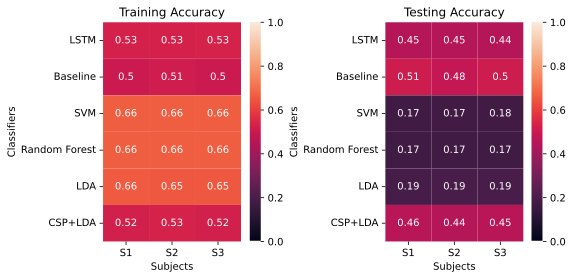

In [11]:
fig, (a1, a2) = plt.subplots(1, 2, figsize=(8, 4))

x_axis_labels = ['S1', 'S2', 'S3']
y_axis_labels = ['LSTM', 'Baseline', 'SVM', 'Random Forest', 'LDA', 'CSP+LDA']

ax1 = sns.heatmap(experiment_results_avg_exp[:, :, 0].T, 
                 vmin=0, vmax=1,
                 xticklabels=x_axis_labels, 
                 yticklabels=y_axis_labels,
                 annot=True,
                 ax=a1)

ax2 = sns.heatmap(experiment_results_avg_exp[:, :, 1].T, 
                 vmin=0, vmax=1,
                 xticklabels=x_axis_labels, 
                 yticklabels=y_axis_labels,
                 annot=True,
                 ax=a2)

ax1.set_title('Training Accuracy')
ax1.set_xlabel('Subjects')
ax1.set_ylabel('Classifiers')
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0)

ax2.set_title('Testing Accuracy')
ax2.set_xlabel('Subjects')
ax2.set_ylabel('Classifiers')
ax2.set_yticklabels(ax2.get_yticklabels(), rotation=0)

fig.tight_layout()
plt.show()

The results shown above are averaged on the 10 experiment instances. From these results, we clearly see that SVM, Random Forest, and LDA heavily overfit to the training data. On the other hand, LSTM, Baseline, and CSP+LDA do not overfit as much. However, no classifier achieved significantly higher than chance performance, although Baseline performs slightly less poor.

## 4b. Results on Data with Epochs Partitioned by Frequency Bands

In [12]:
## Load and average data
experiment_results_fb = np.load(experiment_results_fb_path)
experiment_results_fb_avg_exp = np.mean(experiment_results_fb, axis=0)
experiment_results_fb_avg_exp_avg_sbj = np.mean(experiment_results_fb_avg_exp, axis=0)

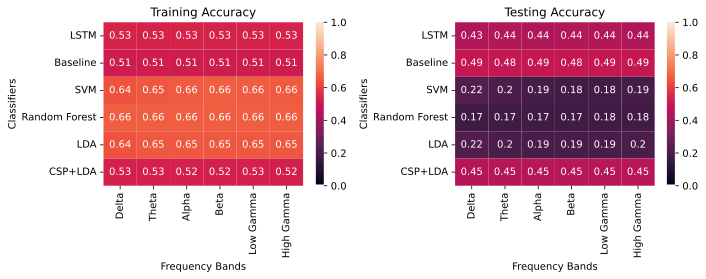

In [13]:
fig, (a1, a2) = plt.subplots(1, 2, figsize=(10, 4))

x_axis_labels = ['Delta', 'Theta', 'Alpha', 'Beta', 'Low Gamma', 'High Gamma']
y_axis_labels = ['LSTM', 'Baseline', 'SVM', 'Random Forest', 'LDA', 'CSP+LDA']

ax1 = sns.heatmap(experiment_results_fb_avg_exp_avg_sbj[:, :, 0].T, 
                 vmin=0, vmax=1,
                 xticklabels=x_axis_labels, 
                 yticklabels=y_axis_labels,
                 annot=True,
                 ax=a1)

ax2 = sns.heatmap(experiment_results_fb_avg_exp_avg_sbj[:, :, 1].T, 
                 vmin=0, vmax=1,
                 xticklabels=x_axis_labels, 
                 yticklabels=y_axis_labels,
                 annot=True,
                 ax=a2)

ax1.set_title('Training Accuracy')
ax1.set_xlabel('Frequency Bands')
ax1.set_ylabel('Classifiers')
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0)

ax2.set_title('Testing Accuracy')
ax2.set_xlabel('Frequency Bands')
ax2.set_ylabel('Classifiers')
ax2.set_yticklabels(ax2.get_yticklabels(), rotation=0)

fig.tight_layout()
plt.show()

The results shown above are averaged on the 10 experiment instances and the 3 subjects. From these results, we see the same trend as before, where no classifier produces meaningful performance.

## 4c. Results on Data with Epochs Partitioned by Time Ranges

In [14]:
## Load and average data
experiment_results_tr = np.load(experiment_results_tr_path)
experiment_results_tr_avg_exp = np.mean(experiment_results_tr, axis=0)
experiment_results_tr_avg_exp_avg_sbj = np.mean(experiment_results_tr_avg_exp, axis=0)

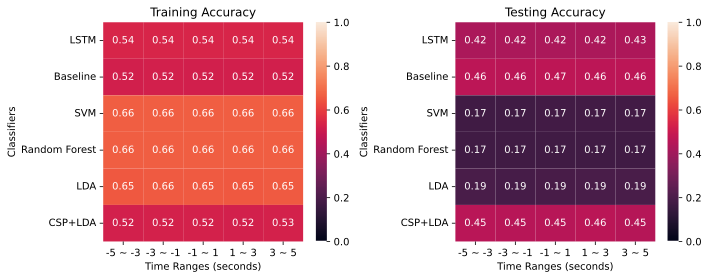

In [15]:
fig, (a1, a2) = plt.subplots(1, 2, figsize=(10, 4))

x_axis_labels = ['-5 ~ -3', '-3 ~ -1', '-1 ~ 1', '1 ~ 3', '3 ~ 5']
y_axis_labels = ['LSTM', 'Baseline', 'SVM', 'Random Forest', 'LDA', 'CSP+LDA']

ax1 = sns.heatmap(experiment_results_tr_avg_exp_avg_sbj[:, :, 0].T, 
                 vmin=0, vmax=1,
                 xticklabels=x_axis_labels, 
                 yticklabels=y_axis_labels,
                 annot=True,
                 ax=a1)

ax2 = sns.heatmap(experiment_results_tr_avg_exp_avg_sbj[:, :, 1].T, 
                 vmin=0, vmax=1,
                 xticklabels=x_axis_labels, 
                 yticklabels=y_axis_labels,
                 annot=True,
                 ax=a2)

ax1.set_title('Training Accuracy')
ax1.set_xlabel('Time Ranges (seconds)')
ax1.set_ylabel('Classifiers')
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0)

ax2.set_title('Testing Accuracy')
ax2.set_xlabel('Time Ranges (seconds)')
ax2.set_ylabel('Classifiers')
ax2.set_yticklabels(ax2.get_yticklabels(), rotation=0)

fig.tight_layout()
plt.show()

## 4d. Results on Data with Epochs Partitioned by Both Frequency Bands and Time Ranges

In [16]:
## Load and average data
experiment_results_fbtr = np.load(experiment_results_fbtr_path)
experiment_results_fbtr_avg_exp = np.mean(experiment_results_fbtr, axis=0)
experiment_results_fbtr_avg_exp_avg_sbj = np.mean(experiment_results_fbtr_avg_exp, axis=0)

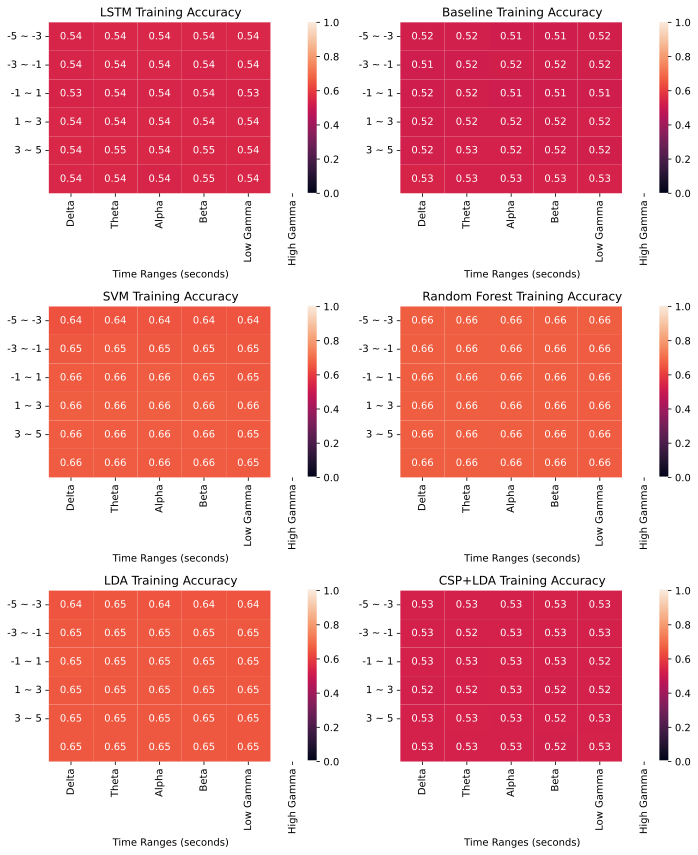

In [17]:
fig, axs = plt.subplots(3, 2, figsize=(10, 12))

classifiers = ['LSTM', 'Baseline', 'SVM', 'Random Forest', 'LDA', 'CSP+LDA']
x_axis_labels = ['Delta', 'Theta', 'Alpha', 'Beta', 'Low Gamma', 'High Gamma']
y_axis_labels = ['-5 ~ -3', '-3 ~ -1', '-1 ~ 1', '1 ~ 3', '3 ~ 5']

for i in range(6):
    ax = sns.heatmap(experiment_results_fbtr_avg_exp_avg_sbj[:, :, i, 0], 
                                     vmin=0, vmax=1,
                                     xticklabels=x_axis_labels, 
                                     yticklabels=y_axis_labels,
                                     annot=True,
                                     ax=axs[i // 2, i % 2])
    
    ax.set_title(classifiers[i] + ' Training Accuracy')
    ax.set_xlabel('Time Ranges (seconds)')
    #axs[i // 2, i % 2].set_ylabel('Frequency Bands')
    #axs[i // 2, i % 2].set_yticklabels(ax1.get_yticklabels(), rotation=0)

fig.tight_layout()
plt.show()

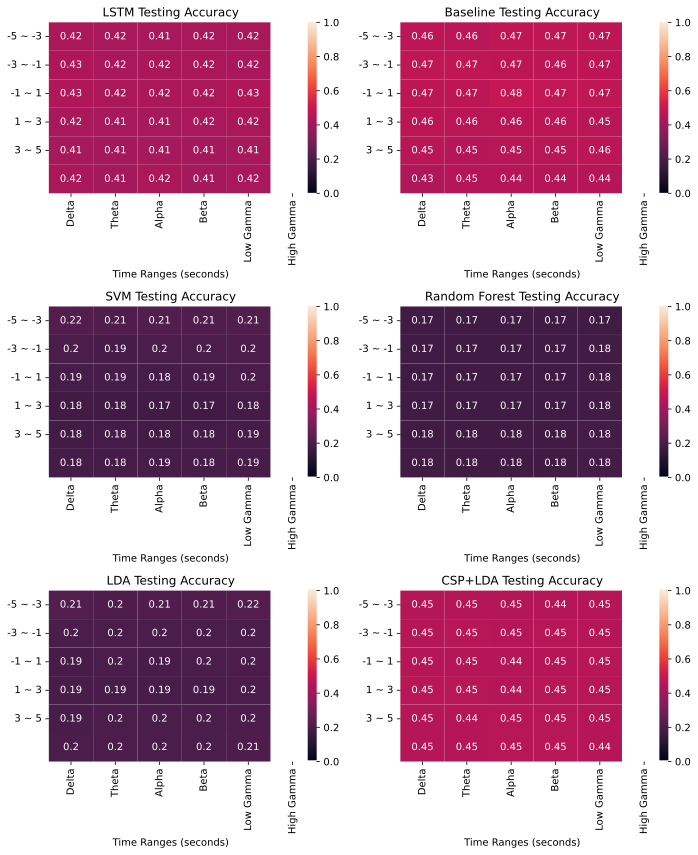

In [18]:
fig, axs = plt.subplots(3, 2, figsize=(10, 12))

classifiers = ['LSTM', 'Baseline', 'SVM', 'Random Forest', 'LDA', 'CSP+LDA']
x_axis_labels = ['Delta', 'Theta', 'Alpha', 'Beta', 'Low Gamma', 'High Gamma']
y_axis_labels = ['-5 ~ -3', '-3 ~ -1', '-1 ~ 1', '1 ~ 3', '3 ~ 5']

for i in range(6):
    ax = sns.heatmap(experiment_results_fbtr_avg_exp_avg_sbj[:, :, i, 1], 
                                     vmin=0, vmax=1,
                                     xticklabels=x_axis_labels, 
                                     yticklabels=y_axis_labels,
                                     annot=True,
                                     ax=axs[i // 2, i % 2])
    
    ax.set_title(classifiers[i] + ' Testing Accuracy')
    ax.set_xlabel('Time Ranges (seconds)')
    #axs[i // 2, i % 2].set_ylabel('Frequency Bands')
    #axs[i // 2, i % 2].set_yticklabels(ax1.get_yticklabels(), rotation=0)

fig.tight_layout()
plt.show()

Overall, from the numerical results, we have not found cases where a classifier can effectively detect any type of epoch associated with an entrance event.

# 5. Feature Importance Visualizations

In this section, we want to visualize the weight placed on each feature in decision making.

## 5.1 iEEG Channel Importance

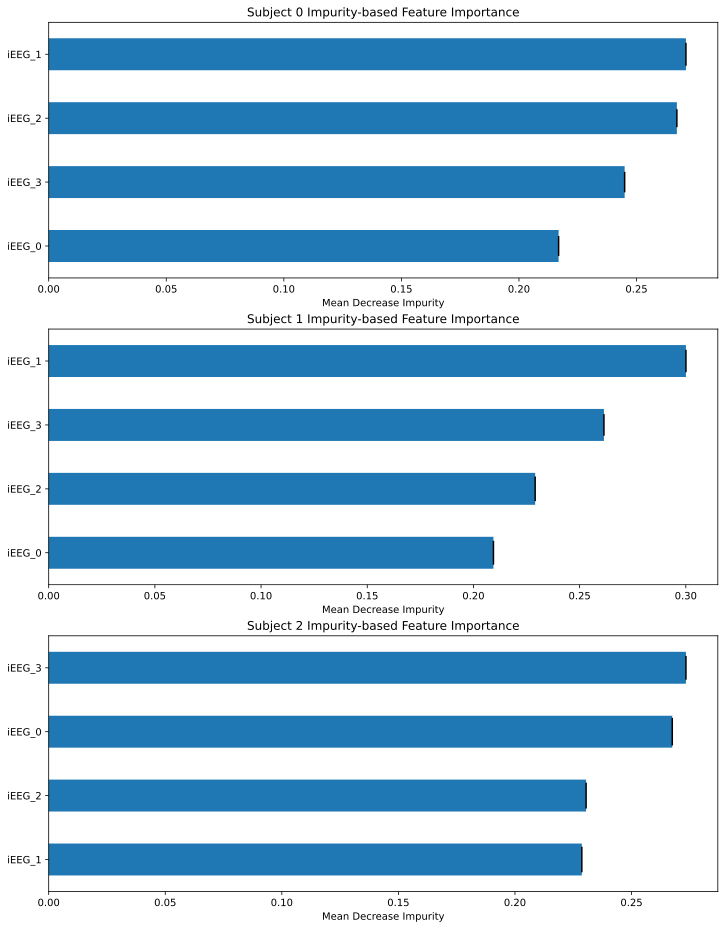

In [22]:
fig, axs = plt.subplots(3, 1, figsize=(12, 16))

for subject_idx in range(num_subjects):
        
    ## Load epochs
    pt_entrance_epochs = np.load(pt_entrance_epochs_paths[subject_idx])
    non_entrance_epochs = np.load(non_entrance_epochs_paths[subject_idx])
    
    data = np.concatenate((pt_entrance_epochs, non_entrance_epochs), axis=0)
    labels = np.concatenate((np.ones(pt_entrance_epochs.shape[0]), np.zeros(non_entrance_epochs.shape[0])))
    
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.33, random_state=42)
    
    # Flatten channel data
    X_train_channel = np.mean(X_train, axis=2)
    
    feature_names = ['iEEG_' + str(i) for i in range(4)]
    forest = RandomForestClassifier(n_estimators=100, random_state=42)
    forest.fit(X_train_channel, y_train)
    
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
    forest_importances = pd.Series(importances, index=feature_names).sort_values(ascending=True)
    
    forest_importances.plot(kind='barh', ax=axs[subject_idx], yerr=std, align='center')
    axs[subject_idx].set_title('Subject ' + str(subject_idx) + ' Impurity-based Feature Importance')
    axs[subject_idx].set_xlabel('Mean Decrease Impurity')

## 5.2 Frequency Band Importance

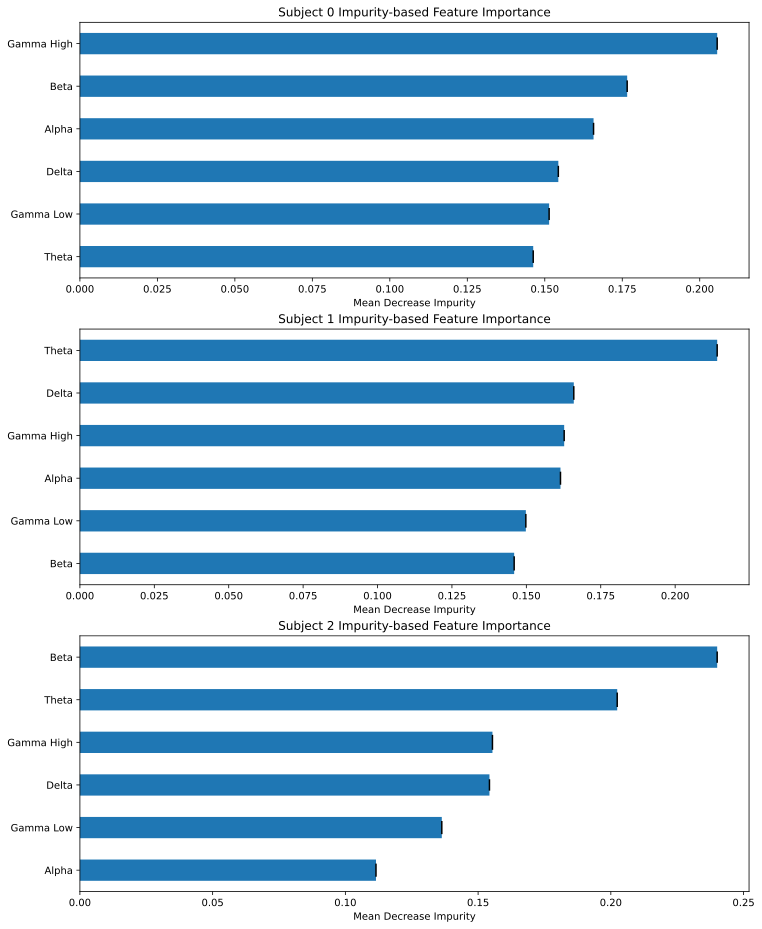

In [24]:
fig, axs = plt.subplots(3, 1, figsize=(12, 16))

for subject_idx in range(num_subjects):
        
    ## Load epochs
    pt_entrance_epochs_fb = np.load(pt_entrance_epochs_fb_paths[subject_idx])
    non_entrance_epochs_fb = np.load(non_entrance_epochs_fb_paths[subject_idx])
    
    fb_data = np.concatenate((pt_entrance_epochs_fb, non_entrance_epochs_fb), axis=0)
    labels = np.concatenate((np.ones(pt_entrance_epochs_fb.shape[0]), np.zeros(non_entrance_epochs_fb.shape[0])))
    
    # flatten the EEG channels
    fb_data = fb_data.reshape(fb_data.shape[0], fb_data.shape[1], fb_data.shape[2] * fb_data.shape[3])

    # Reduce dimensionality by taking the mean of the third dimension
    fb_data = np.mean(fb_data, axis=2)
    
    X_train, X_test, y_train, y_test = train_test_split(fb_data, labels, test_size=0.33, random_state=42)
    
    feature_names = ["Delta", "Theta", "Alpha", "Beta", "Gamma Low", "Gamma High"]
    forest = RandomForestClassifier(n_estimators=100, random_state=42)
    forest.fit(X_train, y_train)
    
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
    forest_importances = pd.Series(importances, index=feature_names).sort_values(ascending=True)
    
    forest_importances.plot(kind='barh', ax=axs[subject_idx], yerr=std, align='center')
    axs[subject_idx].set_title('Subject ' + str(subject_idx) + ' Impurity-based Feature Importance')
    axs[subject_idx].set_xlabel('Mean Decrease Impurity')

## 5.3 Time Range Importance

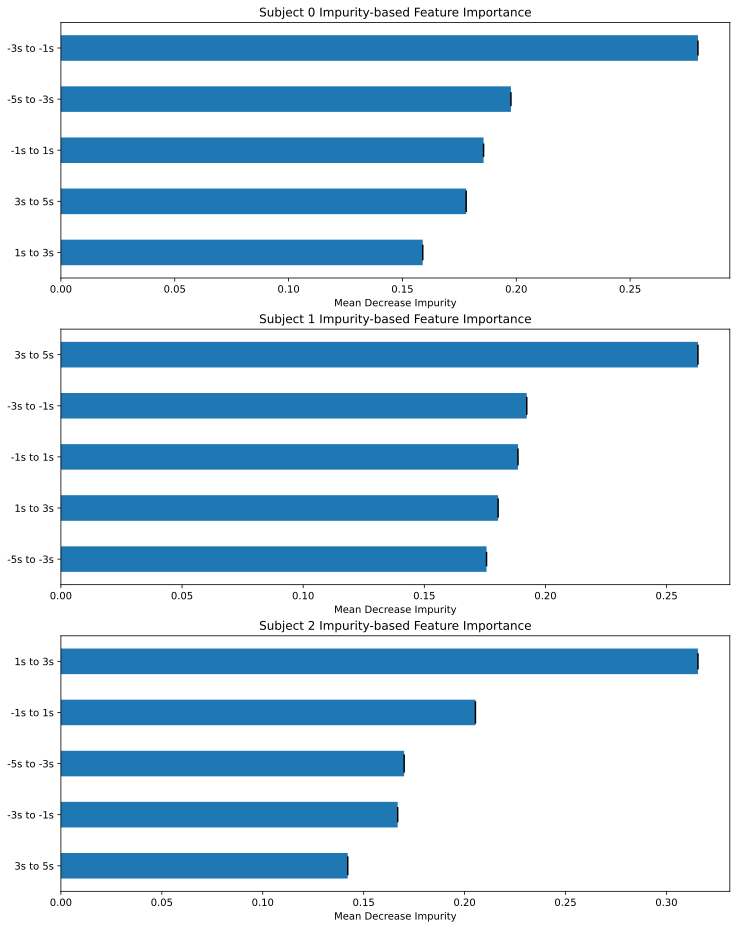

In [26]:
fig, axs = plt.subplots(3, 1, figsize=(12, 16))

for subject_idx in range(num_subjects):
        
    ## Load epochs
    pt_entrance_epochs_tr = np.load(pt_entrance_epochs_tr_paths[subject_idx])
    non_entrance_epochs_tr = np.load(non_entrance_epochs_tr_paths[subject_idx])
    
    tr_data = np.concatenate((pt_entrance_epochs_tr, non_entrance_epochs_tr), axis=0)
    labels = np.concatenate((np.ones(pt_entrance_epochs_tr.shape[0]), np.zeros(non_entrance_epochs_tr.shape[0])))
    
    ## flatten the EEG channels
    tr_data = tr_data.reshape(tr_data.shape[0], tr_data.shape[1], tr_data.shape[2] * tr_data.shape[3])

    ## Reduce dimensionality by taking the mean of the third dimension
    tr_data = np.mean(tr_data, axis=2)
    
    X_train, X_test, y_train, y_test = train_test_split(tr_data, labels, test_size=0.33, random_state=42)
    
    feature_names = [f'{i}s to {i + 2}s' for i in range(-5, 5, 2)]
    forest = RandomForestClassifier(n_estimators=100, random_state=42)
    forest.fit(X_train, y_train)
    
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
    forest_importances = pd.Series(importances, index=feature_names).sort_values(ascending=True)
    
    forest_importances.plot(kind='barh', ax=axs[subject_idx], yerr=std, align='center')
    axs[subject_idx].set_title('Subject ' + str(subject_idx) + ' Impurity-based Feature Importance')
    axs[subject_idx].set_xlabel('Mean Decrease Impurity')

From the weights visualized above, we find no commonality with respect to subjects. Although we know that different people may produce different neural signals, it is likely the case that the frequency associated with similar types of tasks are similar. The fact that there is no commonality even in frequency suggests that no significant patterns are found from the iEEG data. 

Furthermore, we also suspected that closeness in time to the entrance event may also result in different brain signals that would be detectable. This is apparently also not the case as shown above. 

# Conclusion & Discussion

### Addressing Experimental Questions and Hypotheses

From the results produced, we must reject both of our hypotheses for now. 

As shown by the numerical classification results, no classifier tested is able to effectively identify the difference between entrance and non-entrance epochs, regardless of frequency or time partitioning.

As shown by the feature importance visualizations, no feature is commonly weighted more across the subjects. Although, from prior knowledge, frequency would be highly likely used as a useful discriminating factor, we have not found relevant evidence in our results.

### Limitation of Analysis

1. We find limitations in the dataset. Although iEEG electrodes, being embedded in the brain, should ideally produce much higher quality recordings than EEG electrodes, the former only records a small part of the brain. Plus, we are not given prior information regarding the specific placement of the iEEG electrodes in each subject. It could be the case that the electrodes are placed in brain areas that are likely irrelevant to boundary-anchored neural mechanisms. If we were also given EEG recordings instead or in addition, we could mitigate this issue although at the cost of lower resolution and more noise. 
2. We originally planned to extract all possible non-entrance epochs and study the closeness of detected entrance events to the actual entrance events. However, since the number of epochs with entrance events are extremely minute compared to those without, and due to the fact that saving all non-entrance epochs would take approximately 60 GB storage, we chose to only sample 10 times the number of entrance events for each subject. In this way, we reduced the computation time significantly but may have also reduced our chance to find meaningful classifiers.
3. While our marker mitigation solution may have visually improved the quality of input signals, its actual effect on the data is less known. The act of copying and pasting signals around can likely interrupt the continuity in the recordings. Furthermore, resampling disrupts the frequencies. We find these to be potential problems. Although we have verified that no marker ranges overlap with entrance events, having minite-long marker ranges without reliable ways to remove them could have hidden important details from the classifiers.

### Future Directions

Since the datasets are not produced by ourselves, and many limitations are due to the limitation on data and experimental setups, we think that it is more sensible for us to give advice to research teams who are able to produce similar datasets and are interested in re-attempting similar hypotheses. 

1. Increase the number of entrance events within a walk.
2. Increase the number of participants who perform the walk to reduce the effects of individual differences.
3. Produce and utilize both scalp EEG and intracranial EEG recordings.
4. Specify the location of intracranial EEG electrodes implanted for each subject. 
5. Use synchronization markers with reliable methods of removal.